In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 30 14:17:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/HAM10000_segmentations_lesion_tschandl.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/HAM10000/')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from skimage.io import imread
from PIL import Image
import csv
import torch
import copy
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils import data
import torchvision.transforms as transf
import torch.nn.functional as F
from torchvision.transforms.transforms import RandomAdjustSharpness
import torch.nn as nn
import random
import cv2
import math
import os
from torch import optim
from torch.nn.modules.conv import ConvTranspose2d
from torch.autograd import Function
import glob
#import ReliefF

In [ ]:
class SegDataset(data.Dataset):

  def __init__(self, img_list, msk_list, transform=None):
    self.img_list = img_list
    self.msk_list = msk_list
    # self.transforms = transf.Compose([transf.ToTensor(),
    #                                   transf.Normalize([0.485, 0.456, 0.406],
    #                                                    [0.229, 0.224, 0.225]),
    #                                   transf.ToPILImage()])

  def __len__(self):
    return len(self.img_list)

  @classmethod
  def preprocess(self,pil_img, size):
    # w,h = pil_img.size
    # W,H = int(scale*w), int(scale*h)
    pil_img = pil_img.resize((size,size))

    img_nd = np.array(pil_img)

    if len(img_nd.shape) == 2:
      img_nd = np.expand_dims(img_nd, axis=2)

    '''if tranforms are present paste them here'''

    #HWC to CHW
    img_trans = img_nd.transpose((2,0,1))
    if img_trans.max() > 1:
      img_trans = img_trans/225

    return img_trans

  def __getitem__(self, index):
    input_ID = self.img_list[index]
    target_ID = self.msk_list[index]

    img = Image.open(input_ID)
    msk = Image.open(target_ID)

    '''
    assert img.size == msk.size, \
    f'Image and mask for {index} should be the same, but are {img.size} and {msk.size}'

    '''
    # preprocessing
    img = self.preprocess(img, 224)
    msk = self.preprocess(msk, 52)

    return {
        'image': torch.from_numpy(img).type(torch.FloatTensor),
        'mask': torch.from_numpy(msk).type(torch.FloatTensor)
    }

## Training with normal samples first

In [ ]:
# PH2
input_tr = glob.glob('/content/drive/MyDrive/PH2/train/input/*.bmp')
target_tr = ['/content/drive/MyDrive/PH2/train/target/'+element[-10:-4]+'_lesion.bmp' for element in input_tr]
input_val = glob.glob('/content/drive/MyDrive/PH2/val/input/*.bmp')
target_val = ['/content/drive/MyDrive/PH2/val/target/'+element[-10:-4]+'_lesion.bmp' for element in input_val]

In [ ]:
data_input = glob.glob('/content/drive/MyDrive/ISBI-2016_pre-processed/input/*.jpg')
input_tr = data_input[:int(0.8*len(data_input))]
target_tr = ['/content/drive/MyDrive/ISBI-2016_pre-processed/target/'+element[-16:-4]+'_Segmentation.png' for element in input_tr]
input_val = data_input[int(0.8*len(data_input)):]
target_val = ['/content/drive/MyDrive/ISBI-2016_pre-processed/target/'+element[-16:-4]+'_Segmentation.png' for element in input_val]

In [ ]:
sorted(os.listdir('/content/drive/MyDrive/HAM10000/train/'))

['1(nv)', '2(mel)', '3(bkl)', '4(bcc)', '5(akiec)', '6(vasc)', '7(df)']

In [ ]:
len(input_tr)

720

In [ ]:
# Hyperparameter Tuning
batch_size_tr = 10
batch_size_val = 10
epoch_n = 100
n_channels = 3
n_classes = 1
l_rate = 0.01

In [ ]:
train_ds = SegDataset(input_tr, target_tr)#,transform=transforms_tr)
val_ds = SegDataset(input_val, target_val)#,transform=transforms_val)
# test_ds = ImageFolder('/content/drive/MyDrive/Lung_Carcinoma/data_folder_2/test/', transform=val_transform)
train_load = DataLoader(dataset=train_ds, batch_size=batch_size_tr, shuffle=False, drop_last=False)
val_load = DataLoader(dataset=val_ds, batch_size=batch_size_val, shuffle=False, drop_last=False)
# test_load = DataLoader(dataset=test_ds, batch_size=batch_size_val, shuffle=True, drop_last=False)
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

In [ ]:
len(train_load)

72

# Structure of U-Net

In [ ]:
cs_model = torchvision.models.convnext_large(pretrained=True)
print(*list(cs_model.children())[0][1:2])
#print(*list(rs_model.children())[:-7])

In [ ]:
# Segmentation architecture
# U-Net with ConvNext & SqExc Attention

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if mid_channels is None:
      mid_channels = out_channels
    mid_channels = int(in_channels/4)
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, 3, 1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, 3, 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, 2, 2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1=self.up(x1)
    delta_W = x2.size()[3]-x1.size()[3]
    delta_H = x2.size()[2]-x1.size()[2]
    x1 = F.pad(x1,[delta_W//2,delta_W-delta_W//2,delta_H//2,delta_H-delta_H//2])
    x = torch.cat([x2,x1],dim=1)
    return self.conv(x)

class Squeeze_Excitation(nn.Module):
  def __init__(self, factor, in_channels):
    super().__init__()
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.conv = nn.Sequential(nn.Conv2d(in_channels, int(in_channels//factor), 1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(int(in_channels//factor), in_channels, 1),
                              nn.ReLU(inplace=True),)
  def forward(self, input):
    x = self.pool(input)
    x = self.conv(x).sigmoid()

    return x

class FinalConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_final = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self,x):
    return self.conv_final(x)


class U_Net(nn.Module):
  def __init__(self, in_channels, out_classes):
    super(U_Net,self).__init__()
    self.in_channels = in_channels
    self.out_classes = out_classes

    # resnet-34 encoder initialization
    convnex_model = torchvision.models.convnext_large(pretrained=True)

    # self.initial_conv = nn.Sequential(*list(convnex_model.children())[:-7])#(112*112*64)
    self.down1 = nn.Sequential(*list(convnex_model.children())[0][0:2])#(56*56*192)
    self.down2 = nn.Sequential(*list(convnex_model.children())[0][2:4])#(28*28*384)
    self.down3 = nn.Sequential(*list(convnex_model.children())[0][4:6])#(14*14*768)
    self.down4 = nn.Sequential(*list(convnex_model.children())[0][6:8])#(7*7*1536)
    self.up1 = Up(1536,768)
    self.up2 = Up(768,384)
    self.up3 = Up(384,192)
    self.final = FinalConv(192, out_classes)
    self.attention1 = Squeeze_Excitation(0.5, 192)
    self.attention2 = Squeeze_Excitation(0.5, 384)
    self.attention3 = Squeeze_Excitation(0.5, 768)
    self.attention4 = Squeeze_Excitation(0.5, 1536)
    self.conv_atten1 = nn.Conv2d(192,384,1)
    self.conv_atten2 = nn.Conv2d(192,768,1)
    self.conv_atten3 = nn.Conv2d(192,1536,1)
    self.conv_atten4 = nn.Conv2d(384,768,1)
    self.conv_atten5 = nn.Conv2d(384,1536,1)
    self.conv_atten6 = nn.Conv2d(768,1536,1)


  def forward(self,i):

    i1 = self.down1(i)#(56*56*192)

    # attentions from level 1 to lower ones
    atten_1_1 = self.attention1(i1)
    atten_1_2 = self.conv_atten1(atten_1_1)
    atten_1_3 = self.conv_atten2(atten_1_1)
    atten_1_4 = self.conv_atten3(atten_1_1)

    i2 = self.down2(i1*atten_1_1)#(28*28*384)

    # attentions from level 2 to lower ones
    atten_2_2 = self.attention2(i2)
    atten_2_3 = self.conv_atten4(atten_2_2)
    atten_2_4 = self.conv_atten5(atten_2_2)


    i3 = self.down3(i2*atten_2_2)#(14*14*768)

    # attentions from level 3 to lower ones
    atten_3_3 = self.attention3(i3)
    atten_3_4 = self.conv_atten6(atten_3_3)


    i4 = self.down4(i3*atten_3_3)#(7*7*1536)

    # attentions from level 4 to same level
    atten_4_4 = self.attention4(i4)

    # cumulative attentions
    atten4 = (atten_4_4)*(atten_3_4)*(atten_2_4)*(atten_1_4)
    atten3 = (atten_3_3)*(atten_2_3)*(atten_1_3)
    atten2 = (atten_2_2)*(atten_1_2)
    atten1 = atten_1_1

    #decoding with attention for both skip connections and
    i = self.up1(i4*atten4,i3*atten_3_3)
    i = self.up2(i*atten3,i2*atten_2_2)
    i = self.up3(i*atten2,i1*atten_1_1)
    i = self.final(i*atten1)
    return torch.sigmoid(i)

# Loss Functions (IoU Score and IoU Loss)

In [ ]:
''' IoU Score '''

def IoU_score(mask_gen, mask):
  s = torch.FloatTensor(1).cuda().zero_()
  for i,t in enumerate(zip(mask_gen, mask)):
    s += get_IoU(t[0], t[1])
  return s/(i+1)

In [ ]:
# loss functions

'''IoU-Loss'''

def get_IoU(src, tar):

  inter = (src*tar).sum(dim=(1,2))
  union_inter = (src+tar).sum(dim=(1,2))
  #print(inter, union_inter)
  score = (inter.float()+1)/((union_inter-inter).float()+1)
  return score

def loss_iou(mask_gen, mask):
    s=torch.FloatTensor(1).cuda().zero_()
    for i,t in enumerate(zip(mask_gen, mask)):
      # print(t[0].shape, t[1].shape)
      s += get_IoU(t[0], t[1])
    return 1-(s/(i+1))

# Loss Functions (Dice Loss)

In [ ]:
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        # target = _make_one_hot(target, 2)
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps
        # print("inter,uniun:",self.inter,self.union)

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    # print("size of input, target:", input.shape, target.shape)

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)


def dice_coeff_loss(input, target):
    return 1 - dice_coeff(input, target)

## Hybrid Loss between Cross-Entropy and IoU

In [ ]:
'''IoU and BCE hybrid loss'''


def hybrid_loss(mask_gen, mask, smooth=1, eps=1e-9):

  s=torch.FloatTensor(1).cuda().zero_()
  for i,t in enumerate(zip(mask_gen, mask)):
    s += BCE_IoU_loss(t[0], t[1], eps)
  return 1-(s/(i+1))


def BCE_IoU_loss(pred, mask, eps):

  wiou = get_IoU(pred, mask)

  weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
  wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
  wbce = (weit*wbce).sum(dim=(1, 2)) / weit.sum(dim=(1, 2))

  return (wbce + wiou).mean()


# Loss Functions (Focal-Tversky Loss)

In [ ]:
def tversky(y_true, y_pred):
    y_true_pos = torch.flatten(y_true)
    y_pred_pos = torch.flatten(y_pred)
    true_pos = torch.sum(y_true_pos * y_pred_pos)
    false_neg = torch.sum(y_true_pos * (1-y_pred_pos))
    false_pos = torch.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return torch.pow((1-pt_1), gamma)

# Model specifications and training

In [ ]:
model = U_Net(n_channels, n_classes)
state=torch.load('/content/drive/MyDrive/ISBI-2016_pre-processed/models/U_Net_weights_ConvNext_Diceloss.pth') # ekhane previous weight ta src korbi
model.load_state_dict(state['model_state'])
model = model.to(device)
# criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), l_rate)
optim.load_state_dict(state['optimizer_state'])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

In [ ]:
# Training

def train(model, epoch_n, optim): #,criterion):
  best_loss=0.008184416 # ekhane previous best acc ta dibi in the format 0.XX
  train_loss_list = []
  val_loss_list = []
  for epoch in range(epoch_n):
    model.train()
    train_loss=iou_tr=total=dice_tr=0.0
    for _,data in enumerate(train_load):
      image = data['image'].to(device, dtype=torch.float32)
      mask_type = torch.float32 if n_classes == 1 else torch.long
      mask = data['mask'].to(device, dtype=mask_type)
      with torch.set_grad_enabled(True):
        mask_gen = model(image)
        # print(mask_gen.shape)
        # print(mask.shape)
        loss = focal_tversky(mask_gen,mask)
        #loss = hybrid_loss(mask_gen, mask)
        loss.backward()
        optim.step()
      optim.zero_grad()
      train_loss += loss.item()
      total += mask.size(0)
      dice_tr += dice_coeff(mask_gen, mask).item()
      iou_tr += IoU_score(mask_gen,mask).item()
    val_loss, iou_val, dice_val = eval(model)#, criterion)
    epoch_train_loss = train_loss/len(train_ds)
    print("Epoch: {}".format(epoch+1))
    print('-'*10)
    print('Train Loss: {:.9f}'.format(epoch_train_loss))
    epoch_val_loss = val_loss/len(val_ds)
    print('Val Loss: {:.9f}'.format(epoch_val_loss))
    print('\n')
    print('Dice score train: {:.9f}'.format(dice_tr/len(train_load)))
    print('\n')
    print('Dice score val: {:.9f}'.format(dice_val/len(val_load)))
    print('\n')
    print('IoU score train: {:.9f}'.format(iou_tr/len(train_load)))
    print('\n')
    print('IoU score val: {:.9f}'.format(iou_val/len(val_load)))
    print('\n')
    plt.imshow(mask_gen.cpu().detach().numpy()[0][0])
    _, axarr = plt.subplots(1,3)
    axarr[0] = plt.imshow(image.cpu().detach().numpy()[0].transpose((1,2,0)))
    if best_loss > val_loss:
      state={
        "model_state":model.state_dict(),
        "optimizer_state":optim.state_dict(),
          }
      torch.save(state,'/content/drive/MyDrive/ISBI-2016_pre-processed/models/U_Net_weights_ConvNext_Diceloss_preprocessed_focal-tversky.pth') # ekhane notun weight er src ta korbi
      best_loss = val_loss
    train_loss_list = train_loss_list + [epoch_train_loss]
    val_loss_list = val_loss_list + [epoch_val_loss]
  #print("The model with the best performance has a score of :{:.4f}".format(best_loss))
  return model, train_loss_list, val_loss_list


def eval(model):#, criterion):
  model.eval()
  with torch.no_grad():
    val_loss=dice_val=iou_val=0.0
    for _,data in enumerate(val_load):
      image = data['image'].to(device, dtype=torch.float32)
      mask_type = torch.float32 if n_classes == 1 else torch.long
      mask = data['mask'].to(device, dtype=mask_type)
      mask_gen = model(image)
      loss = focal_tversky(mask_gen, mask)
      # loss = hybrid_loss(mask_gen, mask)
      val_loss += loss.item()
      iou_val += IoU_score(mask_gen,mask).item()
      dice_val += dice_coeff(mask_gen,mask).item()
  return val_loss, iou_val, dice_val


# Mask generation of entire dataset

Epoch: 1
----------
Train Loss: 0.034601785
Val Loss: 0.023079328


Dice score train: 0.653982152


Dice score val: 0.769206719


IoU score train: 0.549289403


IoU score val: 0.687021544




Epoch: 2
----------
Train Loss: 0.023231038
Val Loss: 0.040362838


Dice score train: 0.767689617


Dice score val: 0.596371618


IoU score train: 0.680029538


IoU score val: 0.495256135




Epoch: 3
----------
Train Loss: 0.021348985
Val Loss: 0.025614536


Dice score train: 0.786510147


Dice score val: 0.743854642


IoU score train: 0.702998780


IoU score val: 0.655937872




Epoch: 4
----------
Train Loss: 0.022314422
Val Loss: 0.053868660


Dice score train: 0.776855776


Dice score val: 0.461313395


IoU score train: 0.692389479


IoU score val: 0.345929589




Epoch: 5
----------
Train Loss: 0.022775771
Val Loss: 0.020140965


Dice score train: 0.772242288


Dice score val: 0.798590346


IoU score train: 0.688236464


IoU score val: 0.715774503




Epoch: 6
----------
Train Loss: 0.021655877
Val Loss: 0.018718906


Dice score train: 0.783441234


Dice score val: 0.812810944


IoU score train: 0.700224607


IoU score val: 0.734873659




Epoch: 7
----------
Train Loss: 0.021564497
Val Loss: 0.020357699


Dice score train: 0.784355028


Dice score val: 0.796423008


IoU score train: 0.702501345


IoU score val: 0.714920074




Epoch: 8
----------
Train Loss: 0.020591012
Val Loss: 0.021472327


Dice score train: 0.794089883


Dice score val: 0.785276734


IoU score train: 0.712315446


IoU score val: 0.702768150




Epoch: 9
----------
Train Loss: 0.021239246
Val Loss: 0.033012940


Dice score train: 0.787607542


Dice score val: 0.669870597


IoU score train: 0.705081212


IoU score val: 0.564074385




Epoch: 10
----------
Train Loss: 0.019912159
Val Loss: 0.019092058


Dice score train: 0.800878411


Dice score val: 0.809079415


IoU score train: 0.715195896


IoU score val: 0.721656793




Epoch: 11
----------
Train Loss: 0.021636589
Val Loss: 0.039547365


Dice score train: 0.783634106


Dice score val: 0.604526349


IoU score train: 0.699593319


IoU score val: 0.499410350




Epoch: 12
----------
Train Loss: 0.020332620
Val Loss: 0.036066404


Dice score train: 0.796673804


Dice score val: 0.639335958


IoU score train: 0.714896032


IoU score val: 0.531943543




Epoch: 13
----------
Train Loss: 0.020003881
Val Loss: 0.020923529


Dice score train: 0.799961192


Dice score val: 0.790764709


IoU score train: 0.717451491


IoU score val: 0.698479146




Epoch: 14
----------
Train Loss: 0.018108021
Val Loss: 0.020019955


Dice score train: 0.818919787


Dice score val: 0.799800446


IoU score train: 0.736615273


IoU score val: 0.715261496




Epoch: 15
----------
Train Loss: 0.017241227
Val Loss: 0.019756338


Dice score train: 0.827587728


Dice score val: 0.802436623


IoU score train: 0.747606033


IoU score val: 0.714221511




Epoch: 16
----------
Train Loss: 0.016689229
Val Loss: 0.019459717


Dice score train: 0.833107713


Dice score val: 0.805402829


IoU score train: 0.752465549


IoU score val: 0.717563358




Epoch: 17
----------
Train Loss: 0.016448888
Val Loss: 0.019437862


Dice score train: 0.835511117


Dice score val: 0.805621376


IoU score train: 0.757883223


IoU score val: 0.718198895




Epoch: 18
----------
Train Loss: 0.016399143
Val Loss: 0.019011718


Dice score train: 0.836008574


Dice score val: 0.809882816


IoU score train: 0.757120671


IoU score val: 0.722732640




Epoch: 19
----------
Train Loss: 0.015709274
Val Loss: 0.021312670


Dice score train: 0.842907256


Dice score val: 0.786873301


IoU score train: 0.765467692


IoU score val: 0.695445276




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch: 20
----------
Train Loss: 0.015357705
Val Loss: 0.018297923


Dice score train: 0.846422946


Dice score val: 0.817020771


IoU score train: 0.769990617


IoU score val: 0.734284898




Epoch: 21
----------
Train Loss: 0.015727305
Val Loss: 0.019468689


Dice score train: 0.842726947


Dice score val: 0.805313110


IoU score train: 0.765853796


IoU score val: 0.714467959




Epoch: 22
----------
Train Loss: 0.015137294
Val Loss: 0.018692625


Dice score train: 0.848627061


Dice score val: 0.813073754


IoU score train: 0.771789497


IoU score val: 0.726702448




Epoch: 23
----------
Train Loss: 0.014981806
Val Loss: 0.018345481


Dice score train: 0.850181942


Dice score val: 0.816545185


IoU score train: 0.774030637


IoU score val: 0.731951697




Epoch: 24
----------
Train Loss: 0.015201136
Val Loss: 0.018586427


Dice score train: 0.847988644


Dice score val: 0.814135734


IoU score train: 0.771803486


IoU score val: 0.728859590




Epoch: 25
----------
Train Loss: 0.014793499
Val Loss: 0.018276259


Dice score train: 0.852065011


Dice score val: 0.817237407


IoU score train: 0.775997803


IoU score val: 0.732995646




Epoch: 26
----------
Train Loss: 0.014702602
Val Loss: 0.018420420


Dice score train: 0.852973982


Dice score val: 0.815795802


IoU score train: 0.777608476


IoU score val: 0.734065519




Epoch: 27
----------
Train Loss: 0.015091621
Val Loss: 0.020725449


Dice score train: 0.849083787


Dice score val: 0.792745507


IoU score train: 0.773010738


IoU score val: 0.704197761




Epoch: 28
----------
Train Loss: 0.014666473
Val Loss: 0.018212308


Dice score train: 0.853335273


Dice score val: 0.817876915


IoU score train: 0.777368715


IoU score val: 0.733919892




Epoch: 29
----------
Train Loss: 0.014429972
Val Loss: 0.018148733


Dice score train: 0.855700278


Dice score val: 0.818512672


IoU score train: 0.781267071


IoU score val: 0.736108790




Epoch: 30
----------
Train Loss: 0.014271647
Val Loss: 0.019030875


Dice score train: 0.857283534


Dice score val: 0.809691247


IoU score train: 0.783694972


IoU score val: 0.727240152




Epoch: 31
----------
Train Loss: 0.014227759
Val Loss: 0.018715320


Dice score train: 0.857722413


Dice score val: 0.812846800


IoU score train: 0.784331250


IoU score val: 0.731122252




Epoch: 32
----------
Train Loss: 0.014030457
Val Loss: 0.019262033


Dice score train: 0.859695430


Dice score val: 0.807379673


IoU score train: 0.786492629


IoU score val: 0.724005868




Epoch: 33
----------
Train Loss: 0.013829583
Val Loss: 0.018922126


Dice score train: 0.861704170


Dice score val: 0.810778740


IoU score train: 0.788855491


IoU score val: 0.727332711




Epoch: 34
----------
Train Loss: 0.013834785
Val Loss: 0.018121698


Dice score train: 0.861652155


Dice score val: 0.818783022


IoU score train: 0.788344419


IoU score val: 0.735916770




Epoch: 35
----------
Train Loss: 0.013759197
Val Loss: 0.019518890


Dice score train: 0.862408030


Dice score val: 0.804811103


IoU score train: 0.789031869


IoU score val: 0.721754683




Epoch: 36
----------
Train Loss: 0.013648058
Val Loss: 0.019176778


Dice score train: 0.863519415


Dice score val: 0.808232221


IoU score train: 0.790461962


IoU score val: 0.724571390




Epoch: 37
----------
Train Loss: 0.013634870
Val Loss: 0.018202216


Dice score train: 0.863651300


Dice score val: 0.817977842


IoU score train: 0.790992298


IoU score val: 0.737586445




Epoch: 38
----------
Train Loss: 0.013272408
Val Loss: 0.019448838


Dice score train: 0.867275917


Dice score val: 0.805511620


IoU score train: 0.795434741


IoU score val: 0.710111237




Epoch: 39
----------
Train Loss: 0.014223335
Val Loss: 0.020645905


Dice score train: 0.857766651


Dice score val: 0.793540955


IoU score train: 0.783238273


IoU score val: 0.706639376




Epoch: 40
----------
Train Loss: 0.013763593
Val Loss: 0.018538954


Dice score train: 0.862364069


Dice score val: 0.814610458


IoU score train: 0.788613800


IoU score val: 0.732207417




Epoch: 41
----------
Train Loss: 0.013306836
Val Loss: 0.017550365


Dice score train: 0.866931642


Dice score val: 0.824496345


IoU score train: 0.794475777


IoU score val: 0.744015949




Epoch: 42
----------
Train Loss: 0.013778770
Val Loss: 0.017271121


Dice score train: 0.862212295


Dice score val: 0.827288787


IoU score train: 0.787635175


IoU score val: 0.744290143




Epoch: 43
----------
Train Loss: 0.013099996
Val Loss: 0.018133930


Dice score train: 0.869000035


Dice score val: 0.818660700


IoU score train: 0.797137813


IoU score val: 0.732253124




Epoch: 44
----------
Train Loss: 0.012785440
Val Loss: 0.017846876


Dice score train: 0.872145601


Dice score val: 0.821531236


IoU score train: 0.801793089


IoU score val: 0.734351804




Epoch: 45
----------
Train Loss: 0.012782677
Val Loss: 0.017800249


Dice score train: 0.872173228


Dice score val: 0.821997510


IoU score train: 0.801675007


IoU score val: 0.735624999




Epoch: 46
----------
Train Loss: 0.012541153
Val Loss: 0.018461729


Dice score train: 0.874588472


Dice score val: 0.815382712


IoU score train: 0.804642097


IoU score val: 0.724443124




Epoch: 47
----------
Train Loss: 0.012713755
Val Loss: 0.017650586


Dice score train: 0.872862453


Dice score val: 0.823494143


IoU score train: 0.802457796


IoU score val: 0.739534785




Epoch: 48
----------
Train Loss: 0.012342688
Val Loss: 0.018151154


Dice score train: 0.876573117


Dice score val: 0.818488455


IoU score train: 0.807445103


IoU score val: 0.728761418




Epoch: 49
----------
Train Loss: 0.012697532
Val Loss: 0.017335821


Dice score train: 0.873024683


Dice score val: 0.826641791


IoU score train: 0.802886522


IoU score val: 0.742759211




Epoch: 50
----------
Train Loss: 0.012401729
Val Loss: 0.020351992


Dice score train: 0.875982713


Dice score val: 0.796480083


IoU score train: 0.807016430


IoU score val: 0.704683294




Epoch: 51
----------
Train Loss: 0.012199262
Val Loss: 0.017996150


Dice score train: 0.878007385


Dice score val: 0.820038497


IoU score train: 0.809138307


IoU score val: 0.731897553




Epoch: 52
----------
Train Loss: 0.012459529
Val Loss: 0.017264861


Dice score train: 0.875404707


Dice score val: 0.827351388


IoU score train: 0.805904277


IoU score val: 0.742167890




Epoch: 53
----------
Train Loss: 0.012452547
Val Loss: 0.017144161


Dice score train: 0.875474535


Dice score val: 0.828558385


IoU score train: 0.806303071


IoU score val: 0.748640898




Epoch: 54
----------
Train Loss: 0.011908734
Val Loss: 0.026669948


Dice score train: 0.880912658


Dice score val: 0.733300520


IoU score train: 0.813226134


IoU score val: 0.609580851




Epoch: 55
----------
Train Loss: 0.012955816
Val Loss: 0.020797029


Dice score train: 0.870441843


Dice score val: 0.792029709


IoU score train: 0.798307602


IoU score val: 0.706167301




Epoch: 56
----------
Train Loss: 0.012307708
Val Loss: 0.018004279


Dice score train: 0.876922924


Dice score val: 0.819957207


IoU score train: 0.807084626


IoU score val: 0.739463485




Epoch: 57
----------
Train Loss: 0.011884875
Val Loss: 0.021208596


Dice score train: 0.881151248


Dice score val: 0.787914038


IoU score train: 0.813547436


IoU score val: 0.683634410




Epoch: 58
----------
Train Loss: 0.012501291
Val Loss: 0.016904635


Dice score train: 0.874987095


Dice score val: 0.830953651


IoU score train: 0.804578633


IoU score val: 0.749381807




Epoch: 59
----------
Train Loss: 0.012063950
Val Loss: 0.016873304


Dice score train: 0.879360497


Dice score val: 0.831266956


IoU score train: 0.810542005


IoU score val: 0.750304113




Epoch: 60
----------
Train Loss: 0.011838360
Val Loss: 0.015677902


Dice score train: 0.881616399


Dice score val: 0.843220982


IoU score train: 0.813758302


IoU score val: 0.764642752




Epoch: 61
----------
Train Loss: 0.011127110
Val Loss: 0.017396251


Dice score train: 0.888728901


Dice score val: 0.826037486


IoU score train: 0.823528299


IoU score val: 0.742894265




Epoch: 62
----------
Train Loss: 0.011292210
Val Loss: 0.015882455


Dice score train: 0.887077902


Dice score val: 0.841175450


IoU score train: 0.821379811


IoU score val: 0.762721135




Epoch: 63
----------
Train Loss: 0.011285303
Val Loss: 0.015741234


Dice score train: 0.887146974


Dice score val: 0.842587663


IoU score train: 0.821220770


IoU score val: 0.763779945




Epoch: 64
----------
Train Loss: 0.011219809
Val Loss: 0.016755650


Dice score train: 0.887801908


Dice score val: 0.832443502


IoU score train: 0.822171579


IoU score val: 0.751254651




Epoch: 65
----------
Train Loss: 0.011084077
Val Loss: 0.017904651


Dice score train: 0.889159226


Dice score val: 0.820953495


IoU score train: 0.823646878


IoU score val: 0.734166274




Epoch: 66
----------
Train Loss: 0.011030879
Val Loss: 0.021394743


Dice score train: 0.889691212


Dice score val: 0.786052571


IoU score train: 0.825677382


IoU score val: 0.695719149




Epoch: 67
----------
Train Loss: 0.010917637
Val Loss: 0.016091726


Dice score train: 0.890823625


Dice score val: 0.839082744


IoU score train: 0.826151186


IoU score val: 0.754469332




Epoch: 68
----------
Train Loss: 0.010534885
Val Loss: 0.018589806


Dice score train: 0.894651148


Dice score val: 0.814101944


IoU score train: 0.831185776


IoU score val: 0.724889398




Epoch: 69
----------
Train Loss: 0.010560102
Val Loss: 0.021205168


Dice score train: 0.894398978


Dice score val: 0.787948317


IoU score train: 0.830474194


IoU score val: 0.689002679




Epoch: 70
----------
Train Loss: 0.010643291
Val Loss: 0.018394917


Dice score train: 0.893567094


Dice score val: 0.816050831


IoU score train: 0.830097754


IoU score val: 0.732693934




Epoch: 71
----------
Train Loss: 0.010438273
Val Loss: 0.016845979


Dice score train: 0.895617271


Dice score val: 0.831540207


IoU score train: 0.833323234


IoU score val: 0.748382691




Epoch: 72
----------
Train Loss: 0.010071395
Val Loss: 0.015856703


Dice score train: 0.899286048


Dice score val: 0.841432969


IoU score train: 0.838142986


IoU score val: 0.767099261


Epoch: 73
----------
Train Loss: 0.009740928
Val Loss: 0.018058287


Dice score train: 0.902590721


Dice score val: 0.819417129


IoU score train: 0.842936595


IoU score val: 0.729478820




Epoch: 74
----------
Train Loss: 0.009768096
Val Loss: 0.015202622


Dice score train: 0.902319041


Dice score val: 0.847973780


IoU score train: 0.842480446


IoU score val: 0.773710801




Epoch: 75
----------
Train Loss: 0.009880161
Val Loss: 0.018194447


Dice score train: 0.901198385


Dice score val: 0.818055534


IoU score train: 0.840810255


IoU score val: 0.729778260




Epoch: 76
----------
Train Loss: 0.009345098
Val Loss: 0.016486661


Dice score train: 0.906549018


Dice score val: 0.835133394


IoU score train: 0.849711155


IoU score val: 0.760634889




Epoch: 77
----------
Train Loss: 0.009406923
Val Loss: 0.015146267


Dice score train: 0.905930770


Dice score val: 0.848537332


IoU score train: 0.848169002


IoU score val: 0.768085688




Epoch: 78
----------
Train Loss: 0.009631482
Val Loss: 0.015271733


Dice score train: 0.903685178


Dice score val: 0.847282671


IoU score train: 0.844740460


IoU score val: 0.768501769




Epoch: 79
----------
Train Loss: 0.009207424
Val Loss: 0.017126575


Dice score train: 0.907925757


Dice score val: 0.828734252


IoU score train: 0.850937129


IoU score val: 0.748261333




Epoch: 80
----------
Train Loss: 0.009134107
Val Loss: 0.015862466


Dice score train: 0.908658926


Dice score val: 0.841375338


IoU score train: 0.851639291


IoU score val: 0.757787622




Epoch: 81
----------
Train Loss: 0.008814292
Val Loss: 0.015667535


Dice score train: 0.911857082


Dice score val: 0.843324648


IoU score train: 0.856663561


IoU score val: 0.763814767




Epoch: 82
----------
Train Loss: 0.009191002
Val Loss: 0.021206714


Dice score train: 0.908089980


Dice score val: 0.787932856


IoU score train: 0.852010445


IoU score val: 0.705544025




Epoch: 83
----------
Train Loss: 0.008777973
Val Loss: 0.016059772


Dice score train: 0.912220267


Dice score val: 0.839402285


IoU score train: 0.857619242


IoU score val: 0.765404797




Epoch: 84
----------
Train Loss: 0.008740291
Val Loss: 0.016300777


Dice score train: 0.912597087


Dice score val: 0.836992227


IoU score train: 0.857906434


IoU score val: 0.755538808




Epoch: 85
----------
Train Loss: 0.008548309
Val Loss: 0.013507629


Dice score train: 0.914516906


Dice score val: 0.864923706


IoU score train: 0.861047732


IoU score val: 0.791712274




Epoch: 86
----------
Train Loss: 0.008697347
Val Loss: 0.014588686


Dice score train: 0.913026527


Dice score val: 0.854113135


IoU score train: 0.858893101


IoU score val: 0.780543456




Epoch: 87
----------
Train Loss: 0.008383691
Val Loss: 0.018992900


Dice score train: 0.916163089


Dice score val: 0.810071005


IoU score train: 0.863101070


IoU score val: 0.718930930




Epoch: 88
----------
Train Loss: 0.008443344
Val Loss: 0.014200417


Dice score train: 0.915566559


Dice score val: 0.857995831


IoU score train: 0.862305796


IoU score val: 0.780918221




Epoch: 89
----------
Train Loss: 0.008071236
Val Loss: 0.017202418


Dice score train: 0.919287641


Dice score val: 0.827975816


IoU score train: 0.868018510


IoU score val: 0.738275707




Epoch: 90
----------
Train Loss: 0.008370879
Val Loss: 0.019881958


Dice score train: 0.916291206


Dice score val: 0.801180419


IoU score train: 0.863410971


IoU score val: 0.702588336




Epoch: 91
----------
Train Loss: 0.007951112
Val Loss: 0.013751524


Dice score train: 0.920488882


Dice score val: 0.862484756


IoU score train: 0.869457798


IoU score val: 0.787614650




Epoch: 92
----------
Train Loss: 0.007851649
Val Loss: 0.013901342


Dice score train: 0.921483505


Dice score val: 0.860986580


IoU score train: 0.871398857


IoU score val: 0.787630383




Epoch: 93
----------
Train Loss: 0.007523971
Val Loss: 0.019496034


Dice score train: 0.924760293


Dice score val: 0.805039664


IoU score train: 0.876192026


IoU score val: 0.711748295




Epoch: 94
----------
Train Loss: 0.009927588
Val Loss: 0.034079347


Dice score train: 0.900724117


Dice score val: 0.659206526


IoU score train: 0.843160795


IoU score val: 0.550390608




Epoch: 95
----------
Train Loss: 0.013518096
Val Loss: 0.016855832


Dice score train: 0.864819037


Dice score val: 0.831441677


IoU score train: 0.792929610


IoU score val: 0.751530647




Epoch: 96
----------
Train Loss: 0.012485340
Val Loss: 0.024742082


Dice score train: 0.875146603


Dice score val: 0.752579179


IoU score train: 0.807011583


IoU score val: 0.653107673




Epoch: 97
----------
Train Loss: 0.010278084
Val Loss: 0.016290041


Dice score train: 0.897219157


Dice score val: 0.837099592


IoU score train: 0.835813126


IoU score val: 0.756259435




Epoch: 98
----------
Train Loss: 0.009211654
Val Loss: 0.027670355


Dice score train: 0.907883464


Dice score val: 0.723296454


IoU score train: 0.851431745


IoU score val: 0.611051737




Epoch: 99
----------
Train Loss: 0.009517016
Val Loss: 0.021955370


Dice score train: 0.904829843


Dice score val: 0.780446298


IoU score train: 0.846908030


IoU score val: 0.685979399


Epoch: 100
----------
Train Loss: 0.008647364
Val Loss: 0.013363923


Dice score train: 0.913526364


Dice score val: 0.866360770


IoU score train: 0.859444265


IoU score val: 0.792236994




Epoch: 101
----------
Train Loss: 0.008480552
Val Loss: 0.013793664


Dice score train: 0.915194479


Dice score val: 0.862063365


IoU score train: 0.862110255


IoU score val: 0.792616347




Epoch: 102
----------
Train Loss: 0.007779479
Val Loss: 0.014343706


Dice score train: 0.922205208


Dice score val: 0.856562939


IoU score train: 0.872431510


IoU score val: 0.780436791




Epoch: 103
----------
Train Loss: 0.007492720
Val Loss: 0.013382852


Dice score train: 0.925072803


Dice score val: 0.866171476


IoU score train: 0.876667873


IoU score val: 0.797816485




Epoch: 104
----------
Train Loss: 0.007162356
Val Loss: 0.011878972


Dice score train: 0.928376438


Dice score val: 0.881210281


IoU score train: 0.881741596


IoU score val: 0.813641604




Epoch: 105
----------
Train Loss: 0.007063660
Val Loss: 0.011987470


Dice score train: 0.929363402


Dice score val: 0.880125297


IoU score train: 0.882844193


IoU score val: 0.812488076




Epoch: 106
----------
Train Loss: 0.006985394
Val Loss: 0.013925245


Dice score train: 0.930146055


Dice score val: 0.860747553


IoU score train: 0.884566402


IoU score val: 0.787547433




Epoch: 107
----------
Train Loss: 0.006809379
Val Loss: 0.013132193


Dice score train: 0.931906205


Dice score val: 0.868678073


IoU score train: 0.886714652


IoU score val: 0.795258562




Epoch: 108
----------
Train Loss: 0.006678557
Val Loss: 0.013056826


Dice score train: 0.933214434


Dice score val: 0.869431744


IoU score train: 0.888967930


IoU score val: 0.796654658




Epoch: 109
----------
Train Loss: 0.006528591
Val Loss: 0.011875242


Dice score train: 0.934714088


Dice score val: 0.881247580


IoU score train: 0.890921149


IoU score val: 0.814562466




Epoch: 110
----------
Train Loss: 0.006268660
Val Loss: 0.011723131


Dice score train: 0.937313396


Dice score val: 0.882768694


IoU score train: 0.895160163


IoU score val: 0.815531595




Epoch: 111
----------
Train Loss: 0.006268483
Val Loss: 0.014019525


Dice score train: 0.937315174


Dice score val: 0.859804753


IoU score train: 0.895019126


IoU score val: 0.787300299




Epoch: 112
----------
Train Loss: 0.006097651
Val Loss: 0.023058929


Dice score train: 0.939023493


Dice score val: 0.769410710


IoU score train: 0.897782354


IoU score val: 0.668211540




Epoch: 113
----------
Train Loss: 0.006631758
Val Loss: 0.012525338


Dice score train: 0.933682416


Dice score val: 0.874746617


IoU score train: 0.888421624


IoU score val: 0.802584562




Epoch: 114
----------
Train Loss: 0.006275815
Val Loss: 0.011389864


Dice score train: 0.937241849


Dice score val: 0.886101358


IoU score train: 0.894116976


IoU score val: 0.822730455




Epoch: 115
----------
Train Loss: 0.005753417
Val Loss: 0.011043041


Dice score train: 0.942465828


Dice score val: 0.889569587


IoU score train: 0.903138292


IoU score val: 0.823647718




Epoch: 116
----------
Train Loss: 0.005869650
Val Loss: 0.012131081


Dice score train: 0.941303502


Dice score val: 0.878689186


IoU score train: 0.901259279


IoU score val: 0.805332098




Epoch: 117
----------
Train Loss: 0.005815690
Val Loss: 0.010573949


Dice score train: 0.941843104


Dice score val: 0.894260506


IoU score train: 0.901815318


IoU score val: 0.833603366




Epoch: 118
----------
Train Loss: 0.005678866
Val Loss: 0.016154444


Dice score train: 0.943211339


Dice score val: 0.838455564


IoU score train: 0.903934841


IoU score val: 0.758207715




Epoch: 119
----------
Train Loss: 0.006222993
Val Loss: 0.010189747


Dice score train: 0.937770073


Dice score val: 0.898102525


IoU score train: 0.896324781


IoU score val: 0.838948700




Epoch: 120
----------
Train Loss: 0.005590604
Val Loss: 0.011115404


Dice score train: 0.944093956


Dice score val: 0.888845960


IoU score train: 0.905264686


IoU score val: 0.829095599




Epoch: 121
----------
Train Loss: 0.005333915
Val Loss: 0.012128964


Dice score train: 0.946660848


Dice score val: 0.878710363


IoU score train: 0.910347503


IoU score val: 0.818161269




Epoch: 122
----------
Train Loss: 0.005227702
Val Loss: 0.010826717


Dice score train: 0.947722980


Dice score val: 0.891732828


IoU score train: 0.911703289


IoU score val: 0.832466569




Epoch: 123
----------
Train Loss: 0.006906936
Val Loss: 0.023696963


Dice score train: 0.930930639


Dice score val: 0.763030373


IoU score train: 0.888898681


IoU score val: 0.660954257




Epoch: 124
----------
Train Loss: 0.013733538
Val Loss: 0.018366105


Dice score train: 0.862664623


Dice score val: 0.816338946


IoU score train: 0.791012568


IoU score val: 0.732218537




Epoch: 125
----------
Train Loss: 0.011762486
Val Loss: 0.015294135


Dice score train: 0.882375140


Dice score val: 0.847058651


IoU score train: 0.817372703


IoU score val: 0.770797193




Epoch: 126
----------
Train Loss: 0.009232002
Val Loss: 0.014741414


Dice score train: 0.907679984


Dice score val: 0.852585859


IoU score train: 0.850779398


IoU score val: 0.774340994




Epoch: 127
----------
Train Loss: 0.007824982
Val Loss: 0.026794438


Dice score train: 0.921750182


Dice score val: 0.732055621


IoU score train: 0.872390045


IoU score val: 0.627149211




Epoch: 128
----------
Train Loss: 0.007328795
Val Loss: 0.015449677


Dice score train: 0.926712054


Dice score val: 0.845503234


IoU score train: 0.879828896


IoU score val: 0.765839249


Epoch: 129
----------
Train Loss: 0.006824256
Val Loss: 0.016949305


Dice score train: 0.931757442


Dice score val: 0.830506954


IoU score train: 0.886927104


IoU score val: 0.742998845




Epoch: 130
----------
Train Loss: 0.006538890
Val Loss: 0.013789284


Dice score train: 0.934611102


Dice score val: 0.862107161


IoU score train: 0.891388098


IoU score val: 0.782222311




Epoch: 131
----------
Train Loss: 0.006387634
Val Loss: 0.013549384


Dice score train: 0.936123663


Dice score val: 0.864506155


IoU score train: 0.894287368


IoU score val: 0.788776384




Epoch: 132
----------
Train Loss: 0.006381095
Val Loss: 0.012701452


Dice score train: 0.936189055


Dice score val: 0.872985479


IoU score train: 0.893718144


IoU score val: 0.800433603




Epoch: 133
----------
Train Loss: 0.006057954
Val Loss: 0.013715875


Dice score train: 0.939420464


Dice score val: 0.862841249


IoU score train: 0.898616982


IoU score val: 0.782491273




Epoch: 134
----------
Train Loss: 0.006155332
Val Loss: 0.011314939


Dice score train: 0.938446682


Dice score val: 0.886850609


IoU score train: 0.897436956


IoU score val: 0.822623200




Epoch: 135
----------
Train Loss: 0.005851658
Val Loss: 0.011883897


Dice score train: 0.941483416


Dice score val: 0.881161031


IoU score train: 0.902038038


IoU score val: 0.812974691




Epoch: 136
----------
Train Loss: 0.005778334
Val Loss: 0.010542732


Dice score train: 0.942216664


Dice score val: 0.894572679


IoU score train: 0.903392203


IoU score val: 0.835478935




Epoch: 137
----------
Train Loss: 0.005554885
Val Loss: 0.011089824


Dice score train: 0.944451146


Dice score val: 0.889101757


IoU score train: 0.906417100


IoU score val: 0.827317894




Epoch: 138
----------
Train Loss: 0.005556762
Val Loss: 0.011816866


Dice score train: 0.944432379


Dice score val: 0.881831341


IoU score train: 0.906599441


IoU score val: 0.814441598




Epoch: 139
----------
Train Loss: 0.005321009
Val Loss: 0.013022505


Dice score train: 0.946789914


Dice score val: 0.869774948


IoU score train: 0.910366079


IoU score val: 0.793773393




Epoch: 140
----------
Train Loss: 0.005556921
Val Loss: 0.012142160


Dice score train: 0.944430793


Dice score val: 0.878578398


IoU score train: 0.907199707


IoU score val: 0.809442427




Epoch: 141
----------
Train Loss: 0.005228457
Val Loss: 0.011732508


Dice score train: 0.947715430


Dice score val: 0.882674923


IoU score train: 0.911836704


IoU score val: 0.820377757




Epoch: 142
----------
Train Loss: 0.004975056
Val Loss: 0.011540595


Dice score train: 0.950249435


Dice score val: 0.884594046


IoU score train: 0.915642290


IoU score val: 0.823160261




Epoch: 143
----------
Train Loss: 0.005067983
Val Loss: 0.011666137


Dice score train: 0.949320172


Dice score val: 0.883338630


IoU score train: 0.914308682


IoU score val: 0.824513942




Epoch: 144
----------
Train Loss: 0.005032741
Val Loss: 0.013547035


Dice score train: 0.949672589


Dice score val: 0.864529646


IoU score train: 0.914556304


IoU score val: 0.798990342




Epoch: 145
----------
Train Loss: 0.005299125
Val Loss: 0.012836859


Dice score train: 0.947008750


Dice score val: 0.871631414


IoU score train: 0.910304209


IoU score val: 0.806283706




Epoch: 146
----------
Train Loss: 0.004868551
Val Loss: 0.013353213


Dice score train: 0.951314490


Dice score val: 0.866467867


IoU score train: 0.917297548


IoU score val: 0.803783794




Epoch: 147
----------
Train Loss: 0.004782029
Val Loss: 0.012475137


Dice score train: 0.952179706


Dice score val: 0.875248628


IoU score train: 0.918749316


IoU score val: 0.813382907




Epoch: 148
----------
Train Loss: 0.004641673
Val Loss: 0.011990172


Dice score train: 0.953583274


Dice score val: 0.880098280


IoU score train: 0.920935349


IoU score val: 0.817371196




Epoch: 149
----------
Train Loss: 0.004485563
Val Loss: 0.012169376


Dice score train: 0.955144370


Dice score val: 0.878306237


IoU score train: 0.923677463


IoU score val: 0.810801039




Epoch: 150
----------
Train Loss: 0.004896431
Val Loss: 0.011929052


Dice score train: 0.951035686


Dice score val: 0.880709483


IoU score train: 0.917548545


IoU score val: 0.820733219




Epoch: 151
----------
Train Loss: 0.004643180
Val Loss: 0.010883415


Dice score train: 0.953568195


Dice score val: 0.891165849


IoU score train: 0.920962294


IoU score val: 0.827795310




Epoch: 152
----------
Train Loss: 0.004371938
Val Loss: 0.012380939


Dice score train: 0.956280616


Dice score val: 0.876190609


IoU score train: 0.925472584


IoU score val: 0.808343281




Epoch: 153
----------
Train Loss: 0.004273461
Val Loss: 0.010616780


Dice score train: 0.957265393


Dice score val: 0.893832200


IoU score train: 0.926975312


IoU score val: 0.832400554




Epoch: 154
----------
Train Loss: 0.004666417
Val Loss: 0.011042979


Dice score train: 0.953335835


Dice score val: 0.889570206


IoU score train: 0.920682516


IoU score val: 0.828823633




Epoch: 155
----------
Train Loss: 0.004512943
Val Loss: 0.010128881


Dice score train: 0.954870569


Dice score val: 0.898711188


IoU score train: 0.923266282


IoU score val: 0.839733839




Epoch: 156
----------
Train Loss: 0.004388553
Val Loss: 0.011176472


Dice score train: 0.956114468


Dice score val: 0.888235278


IoU score train: 0.925374935


IoU score val: 0.822400739




Epoch: 157
----------
Train Loss: 0.004088646
Val Loss: 0.010019296


Dice score train: 0.959113538


Dice score val: 0.899807043


IoU score train: 0.929885267


IoU score val: 0.840154118




Epoch: 158
----------
Train Loss: 0.004510406
Val Loss: 0.012966165


Dice score train: 0.954895943


Dice score val: 0.870338347


IoU score train: 0.923098396


IoU score val: 0.806043552




Epoch: 159
----------
Train Loss: 0.004644216
Val Loss: 0.012175944


Dice score train: 0.953557841


Dice score val: 0.878240559


IoU score train: 0.921783303


IoU score val: 0.822895249




Epoch: 160
----------
Train Loss: 0.004144258
Val Loss: 0.010203953


Dice score train: 0.958557419


Dice score val: 0.897960471


IoU score train: 0.929134832


IoU score val: 0.843929509




Epoch: 161
----------
Train Loss: 0.004092443
Val Loss: 0.011067581


Dice score train: 0.959075569


Dice score val: 0.889324195


IoU score train: 0.930348960


IoU score val: 0.832965795




Epoch: 162
----------
Train Loss: 0.004325595
Val Loss: 0.010498982


Dice score train: 0.956744048


Dice score val: 0.895010180


IoU score train: 0.926429138


IoU score val: 0.838166383




Epoch: 163
----------
Train Loss: 0.004372724
Val Loss: 0.010378193


Dice score train: 0.956272761


Dice score val: 0.896218075


IoU score train: 0.925401525


IoU score val: 0.841455854




Epoch: 164
----------
Train Loss: 0.003982320
Val Loss: 0.010448339


Dice score train: 0.960176797


Dice score val: 0.895516614


IoU score train: 0.931561636


IoU score val: 0.840764811




Epoch: 165
----------
Train Loss: 0.003967663
Val Loss: 0.009603298


Dice score train: 0.960323369


Dice score val: 0.903967020


IoU score train: 0.932184194


IoU score val: 0.850745433




Epoch: 166
----------
Train Loss: 0.003934319
Val Loss: 0.010293915


Dice score train: 0.960656808


Dice score val: 0.897060848


IoU score train: 0.932735190


IoU score val: 0.842753003




Epoch: 167
----------
Train Loss: 0.003790423
Val Loss: 0.010940198


Dice score train: 0.962095775


Dice score val: 0.890598016


IoU score train: 0.934854258


IoU score val: 0.828684585




Epoch: 168
----------
Train Loss: 0.003835280
Val Loss: 0.012684573


Dice score train: 0.961647200


Dice score val: 0.873154273


IoU score train: 0.933798225


IoU score val: 0.815747956




Epoch: 169
----------
Train Loss: 0.003757386
Val Loss: 0.011476677


Dice score train: 0.962426135


Dice score val: 0.885233233


IoU score train: 0.935364970


IoU score val: 0.828531613




Epoch: 170
----------
Train Loss: 0.003827143
Val Loss: 0.011101329


Dice score train: 0.961728574


Dice score val: 0.888986713


IoU score train: 0.934461372


IoU score val: 0.833475093


Epoch: 171
----------
Train Loss: 0.003590205
Val Loss: 0.014351154


Dice score train: 0.964097952


Dice score val: 0.856488463


IoU score train: 0.938131659


IoU score val: 0.796392007




Epoch: 172
----------
Train Loss: 0.003614970
Val Loss: 0.011205898


Dice score train: 0.963850303


Dice score val: 0.887941019


IoU score train: 0.937937447


IoU score val: 0.832842638




Epoch: 173
----------
Train Loss: 0.003673632
Val Loss: 0.011708121


Dice score train: 0.963263678


Dice score val: 0.882918785


IoU score train: 0.937133062


IoU score val: 0.827180836




Epoch: 174
----------
Train Loss: 0.003741875
Val Loss: 0.011195662


Dice score train: 0.962581247


Dice score val: 0.888043380


IoU score train: 0.936195945


IoU score val: 0.832127902




Epoch: 175
----------
Train Loss: 0.003996942
Val Loss: 0.012622499


Dice score train: 0.960030582


Dice score val: 0.873775005


IoU score train: 0.931640844


IoU score val: 0.816448092




Epoch: 176
----------
Train Loss: 0.004050786
Val Loss: 0.014023145


Dice score train: 0.959492137


Dice score val: 0.859768553


IoU score train: 0.930598409


IoU score val: 0.801079889




Epoch: 177
----------
Train Loss: 0.003992238
Val Loss: 0.010875381


Dice score train: 0.960077615


Dice score val: 0.891246186


IoU score train: 0.931870276


IoU score val: 0.838772919




Epoch: 178
----------
Train Loss: 0.003586254
Val Loss: 0.009675007


Dice score train: 0.964137456


Dice score val: 0.903249926


IoU score train: 0.937962846


IoU score val: 0.852903995




Epoch: 179
----------
Train Loss: 0.003302060
Val Loss: 0.011819086


Dice score train: 0.966979403


Dice score val: 0.881809135


IoU score train: 0.942977721


IoU score val: 0.825025317




Epoch: 180
----------
Train Loss: 0.003453118
Val Loss: 0.010268397


Dice score train: 0.965468816


Dice score val: 0.897316032


IoU score train: 0.940394416


IoU score val: 0.841983113




Epoch: 181
----------
Train Loss: 0.003275348
Val Loss: 0.009472559


Dice score train: 0.967246519


Dice score val: 0.905274411


IoU score train: 0.943510401


IoU score val: 0.853506403




Epoch: 182
----------
Train Loss: 0.003572603
Val Loss: 0.011394546


Dice score train: 0.964273973


Dice score val: 0.886054536


IoU score train: 0.938968294


IoU score val: 0.831420097




Epoch: 183
----------
Train Loss: 0.003326256
Val Loss: 0.009340668


Dice score train: 0.966737438


Dice score val: 0.906593316


IoU score train: 0.942328229


IoU score val: 0.852767362




Epoch: 184
----------
Train Loss: 0.003245709
Val Loss: 0.009684942


Dice score train: 0.967542906


Dice score val: 0.903150578


IoU score train: 0.943880349


IoU score val: 0.853995999




Epoch: 185
----------
Train Loss: 0.003227822
Val Loss: 0.009467818


Dice score train: 0.967721779


Dice score val: 0.905321823


IoU score train: 0.943971338


IoU score val: 0.853702128




Epoch: 186
----------
Train Loss: 0.003137287
Val Loss: 0.009829512


Dice score train: 0.968627130


Dice score val: 0.901704884


IoU score train: 0.945954277


IoU score val: 0.849842628




Epoch: 187
----------
Train Loss: 0.003131978
Val Loss: 0.009247573


Dice score train: 0.968680216


Dice score val: 0.907524271


IoU score train: 0.945789122


IoU score val: 0.858747194




Epoch: 188
----------
Train Loss: 0.002889476
Val Loss: 0.010648841


Dice score train: 0.971105239


Dice score val: 0.893511590


IoU score train: 0.949922055


IoU score val: 0.840012984




Epoch: 189
----------
Train Loss: 0.003178220
Val Loss: 0.010108801


Dice score train: 0.968217798


Dice score val: 0.898911993


IoU score train: 0.944659015


IoU score val: 0.846894529




Epoch: 190
----------
Train Loss: 0.002933033
Val Loss: 0.010547067


Dice score train: 0.970669665


Dice score val: 0.894529333


IoU score train: 0.948850903


IoU score val: 0.841933926




Epoch: 191
----------
Train Loss: 0.002784864
Val Loss: 0.009758797


Dice score train: 0.972151361


Dice score val: 0.902412034


IoU score train: 0.951706674


IoU score val: 0.851169060




Epoch: 192
----------
Train Loss: 0.002689503
Val Loss: 0.009599193


Dice score train: 0.973104966


Dice score val: 0.904008067


IoU score train: 0.953074493


IoU score val: 0.854527550




Epoch: 193
----------
Train Loss: 0.002788266
Val Loss: 0.009025493


Dice score train: 0.972117343


Dice score val: 0.909745074


IoU score train: 0.951911987


IoU score val: 0.860628446




Epoch: 194
----------
Train Loss: 0.002736660
Val Loss: 0.009685562


Dice score train: 0.972633399


Dice score val: 0.903144376


IoU score train: 0.952093465


IoU score val: 0.850839847




Epoch: 195
----------
Train Loss: 0.002819229
Val Loss: 0.009536297


Dice score train: 0.971807714


Dice score val: 0.904637032


IoU score train: 0.950772850


IoU score val: 0.853100611




Epoch: 196
----------
Train Loss: 0.002850541
Val Loss: 0.010041870


Dice score train: 0.971494590


Dice score val: 0.899581303


IoU score train: 0.950245601


IoU score val: 0.849695394




Epoch: 197
----------
Train Loss: 0.002762698
Val Loss: 0.009383851


Dice score train: 0.972373024


Dice score val: 0.906161490


IoU score train: 0.952337596


IoU score val: 0.858135915




Epoch: 198
----------
Train Loss: 0.002730290
Val Loss: 0.009518343


Dice score train: 0.972697096


Dice score val: 0.904816568


IoU score train: 0.952233982


IoU score val: 0.857497493




Epoch: 199
----------
Train Loss: 0.002706166
Val Loss: 0.009921958


Dice score train: 0.972938338


Dice score val: 0.900780420


IoU score train: 0.952481302


IoU score val: 0.850848095




Epoch: 200
----------
Train Loss: 0.002520657
Val Loss: 0.009427121


Dice score train: 0.974793428


Dice score val: 0.905728790


IoU score train: 0.955746316


IoU score val: 0.858542591




Epoch: 201
----------
Train Loss: 0.002369502
Val Loss: 0.010297889


Dice score train: 0.976304981


Dice score val: 0.897021115


IoU score train: 0.958494960


IoU score val: 0.847399582




Epoch: 202
----------
Train Loss: 0.002717867
Val Loss: 0.009369702


Dice score train: 0.972821332


Dice score val: 0.906302975


IoU score train: 0.952631463


IoU score val: 0.854931563




Epoch: 203
----------
Train Loss: 0.002521674
Val Loss: 0.010289036


Dice score train: 0.974783265


Dice score val: 0.897109641


IoU score train: 0.956212012


IoU score val: 0.844905830




Epoch: 204
----------
Train Loss: 0.002576779
Val Loss: 0.009723220


Dice score train: 0.974232212


Dice score val: 0.902767801


IoU score train: 0.955450989


IoU score val: 0.851414929




Epoch: 205
----------
Train Loss: 0.002535599
Val Loss: 0.009673525


Dice score train: 0.974644008


Dice score val: 0.903264754


IoU score train: 0.956039290


IoU score val: 0.851602650




Epoch: 206
----------
Train Loss: 0.002840583
Val Loss: 0.010155283


Dice score train: 0.971594172


Dice score val: 0.898447169


IoU score train: 0.951787275


IoU score val: 0.845780224




Epoch: 207
----------
Train Loss: 0.002869106
Val Loss: 0.009059550


Dice score train: 0.971308938


Dice score val: 0.909404500


IoU score train: 0.949783088


IoU score val: 0.861992243




Epoch: 208
----------
Train Loss: 0.002517177
Val Loss: 0.010772172


Dice score train: 0.974828226


Dice score val: 0.892278284


IoU score train: 0.955898750


IoU score val: 0.842740513




Epoch: 209
----------
Train Loss: 0.002553229
Val Loss: 0.008184416


Dice score train: 0.974467709


Dice score val: 0.918155842


IoU score train: 0.955242346


IoU score val: 0.869308588




Epoch: 210
----------
Train Loss: 0.002458522
Val Loss: 0.011710247


Dice score train: 0.975414783


Dice score val: 0.882897529


IoU score train: 0.957214806


IoU score val: 0.828671498




Epoch: 211
----------
Train Loss: 0.002147974
Val Loss: 0.011030710


Dice score train: 0.978520263


Dice score val: 0.889692903


IoU score train: 0.961855805


IoU score val: 0.836838000




Epoch: 212
----------
Train Loss: 0.002050929
Val Loss: 0.010062095


Dice score train: 0.979490708


Dice score val: 0.899379048


IoU score train: 0.964078464


IoU score val: 0.849621932




Epoch: 213
----------
Train Loss: 0.002285585
Val Loss: 0.008966673


Dice score train: 0.977144145


Dice score val: 0.910333269


IoU score train: 0.959887346


IoU score val: 0.863050424




Epoch: 214
----------
Train Loss: 0.001993175
Val Loss: 0.011490123


Dice score train: 0.980068246


Dice score val: 0.885098772


IoU score train: 0.964926769


IoU score val: 0.832726902




Epoch: 215
----------
Train Loss: 0.002165067
Val Loss: 0.014152391


Dice score train: 0.978349334


Dice score val: 0.858476092


IoU score train: 0.962022820


IoU score val: 0.799603413




Epoch: 216
----------
Train Loss: 0.002502738
Val Loss: 0.011136744


Dice score train: 0.974972617


Dice score val: 0.888632562


IoU score train: 0.956537304


IoU score val: 0.838827517




Epoch: 217
----------
Train Loss: 0.002043914
Val Loss: 0.011036233


Dice score train: 0.979560863


Dice score val: 0.889637669


IoU score train: 0.964079642


IoU score val: 0.837376174




Epoch: 218
----------
Train Loss: 0.002148361
Val Loss: 0.008874541


Dice score train: 0.978516392


Dice score val: 0.911254595


IoU score train: 0.962413191


IoU score val: 0.864386194




Epoch: 219
----------
Train Loss: 0.002080455
Val Loss: 0.008753499


Dice score train: 0.979195452


Dice score val: 0.912465013


IoU score train: 0.963422129


IoU score val: 0.866294261




Epoch: 220
----------
Train Loss: 0.002010914
Val Loss: 0.011087570


Dice score train: 0.979890857


Dice score val: 0.889124304


IoU score train: 0.964677642


IoU score val: 0.835307803




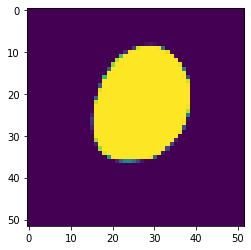

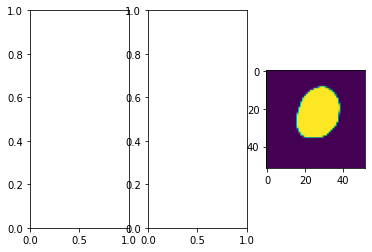

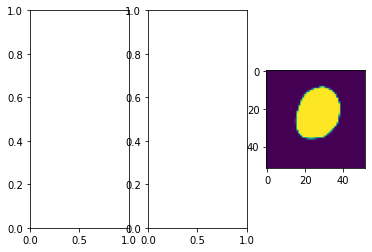

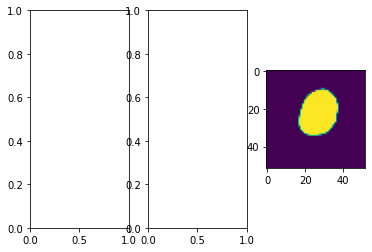

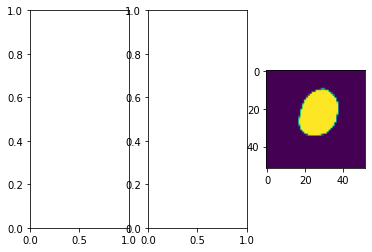

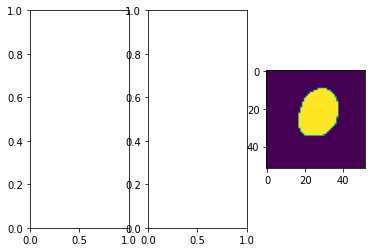

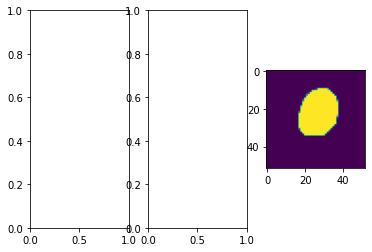

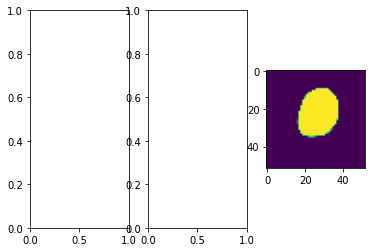

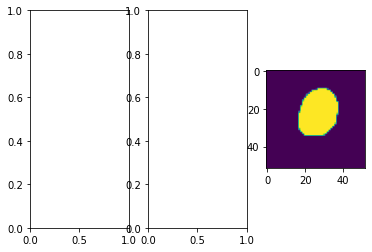

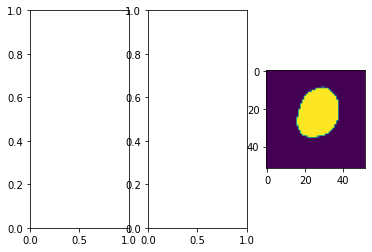

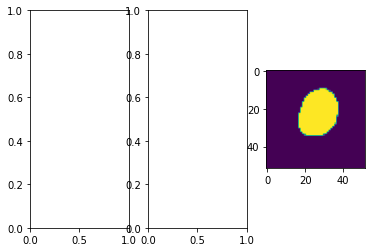

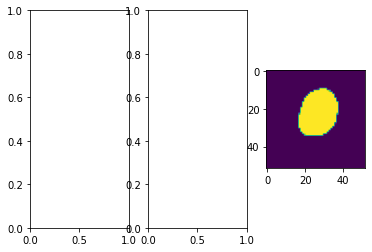

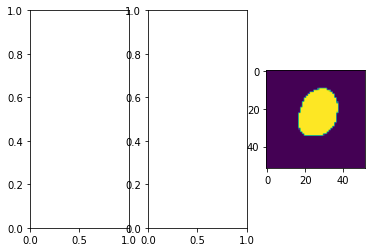

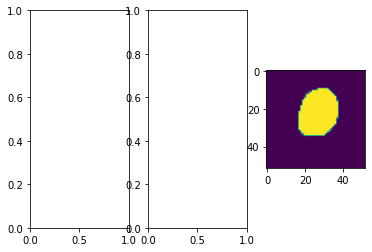

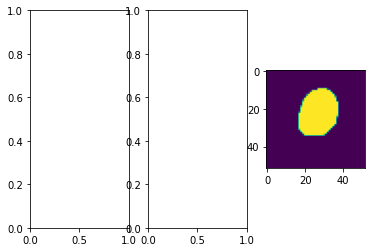

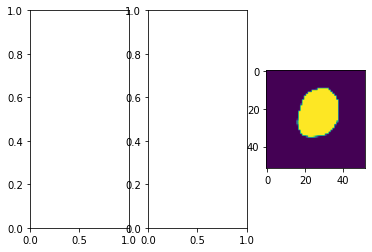

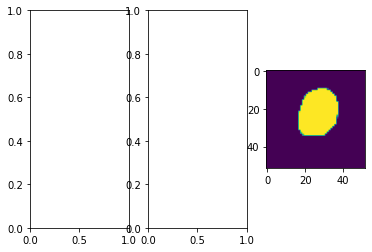

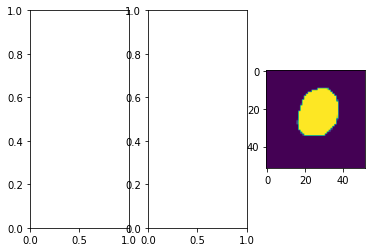

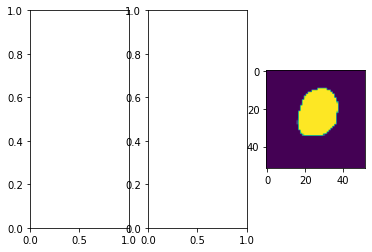

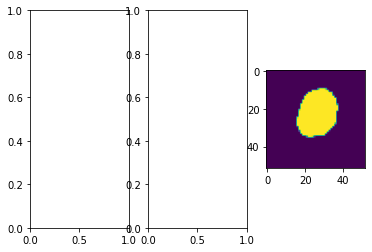

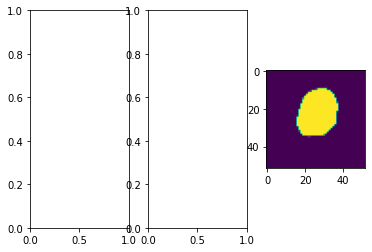

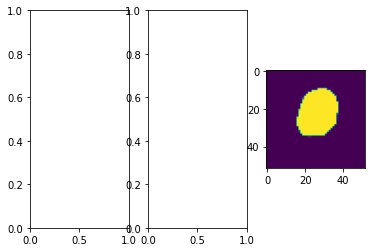

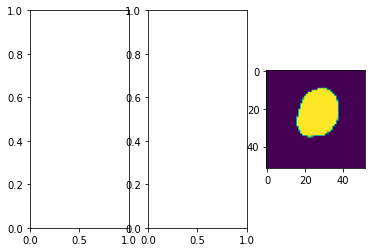

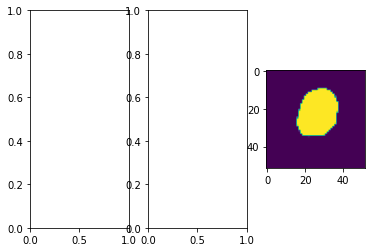

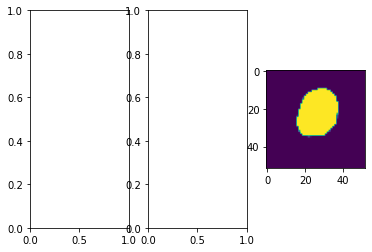

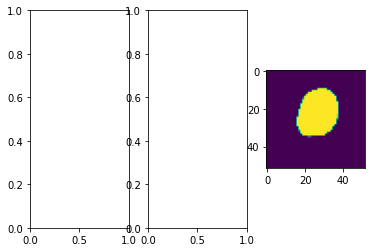

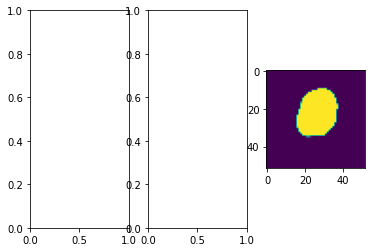

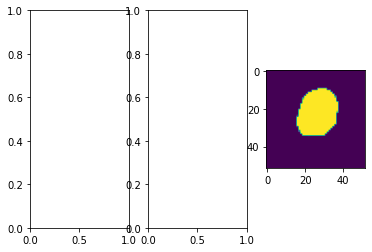

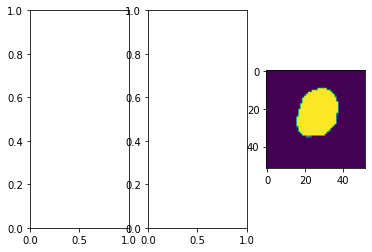

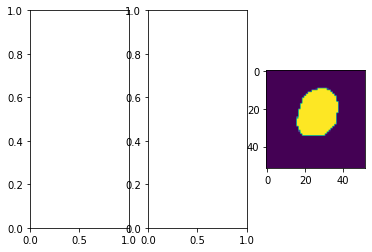

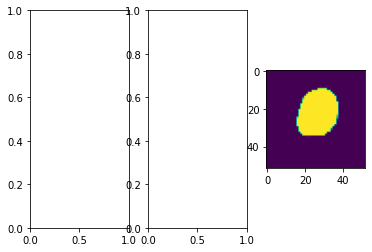

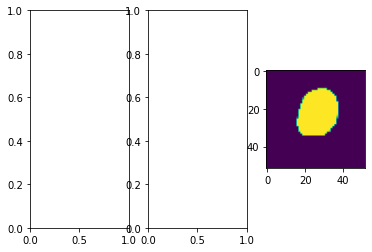

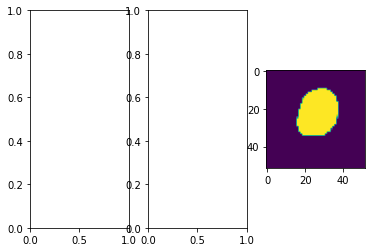

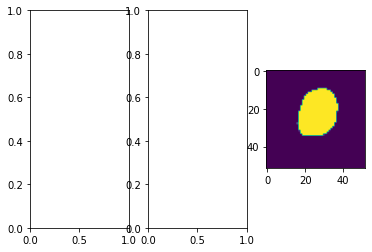

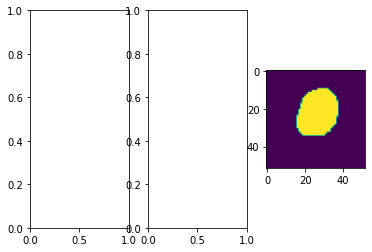

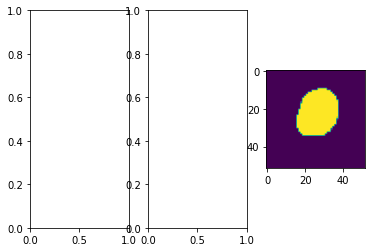

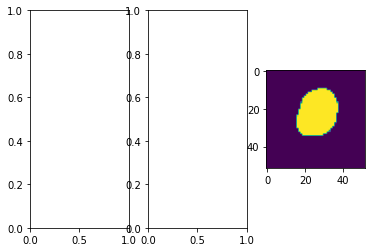

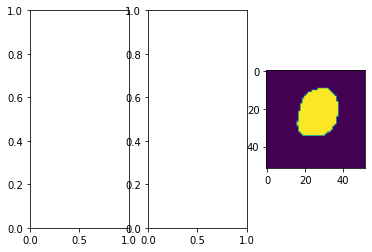

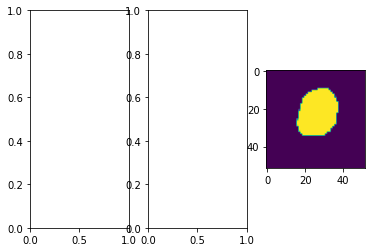

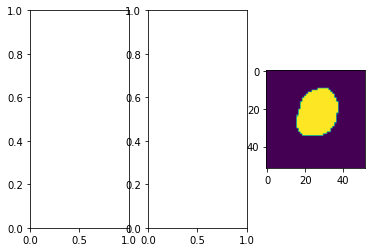

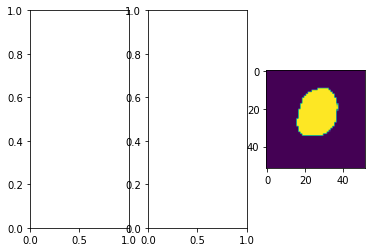

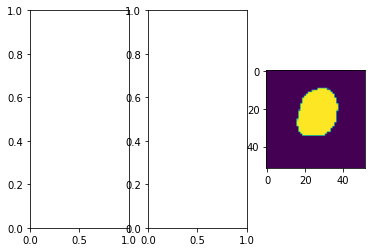

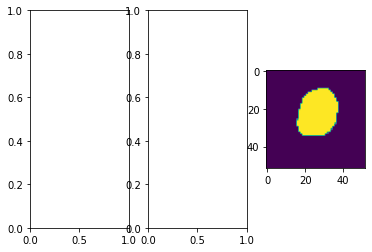

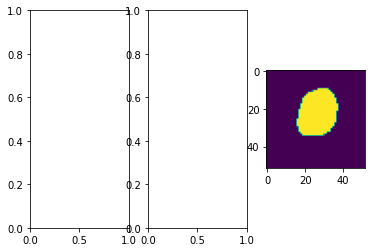

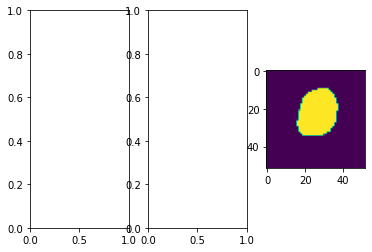

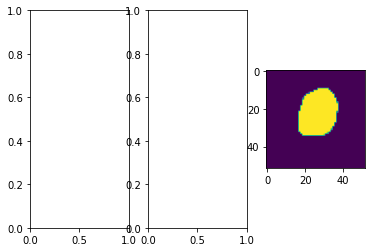

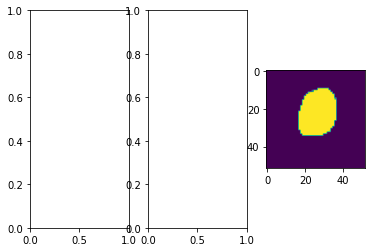

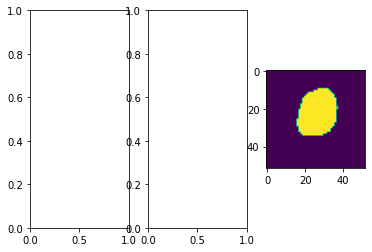

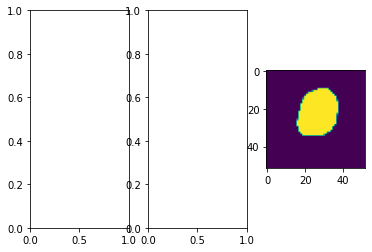

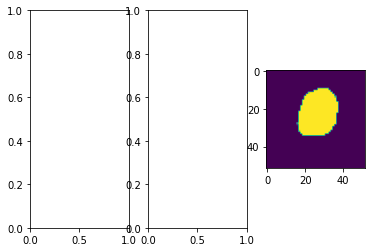

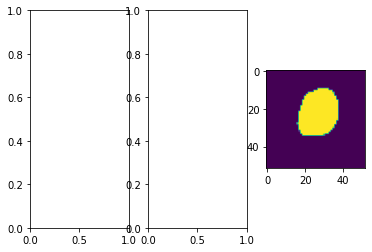

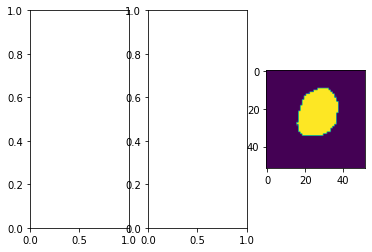

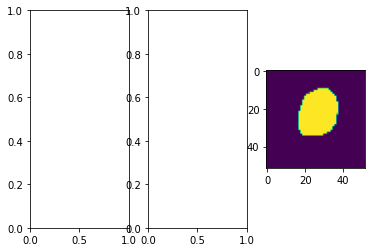

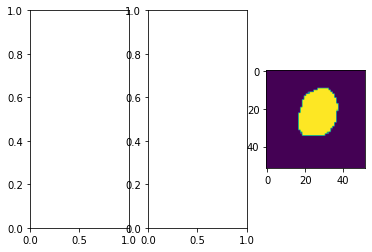

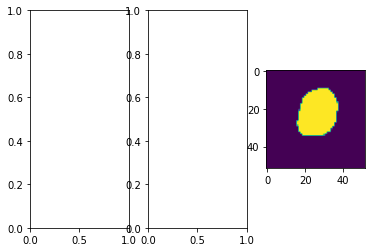

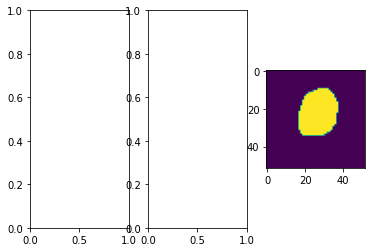

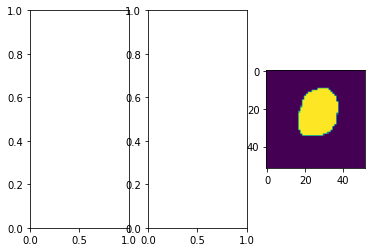

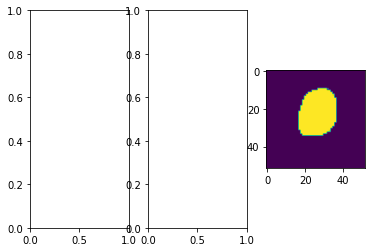

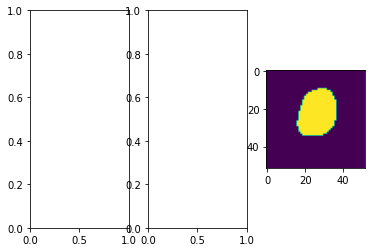

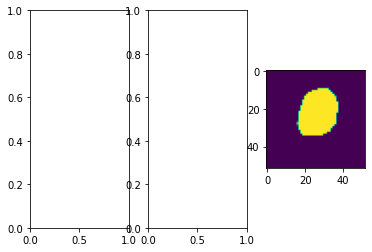

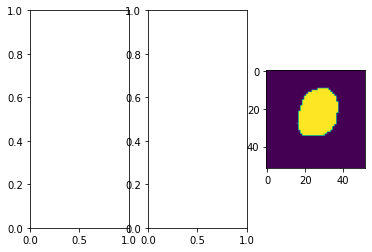

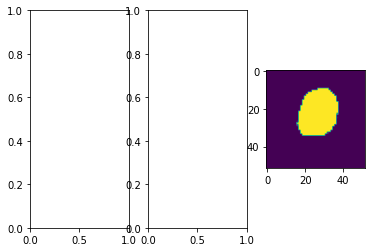

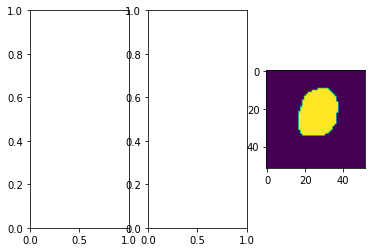

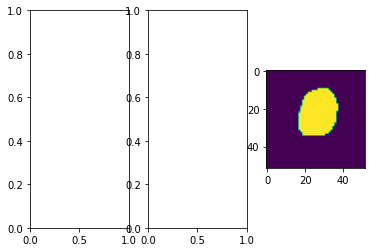

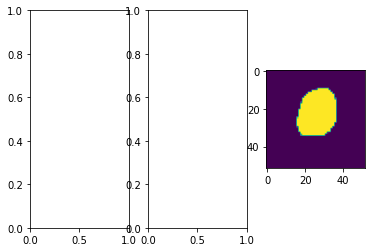

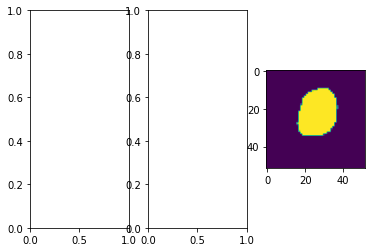

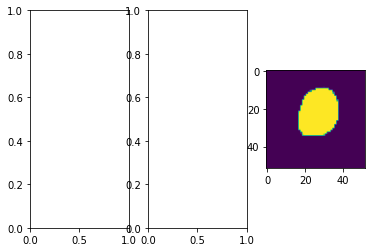

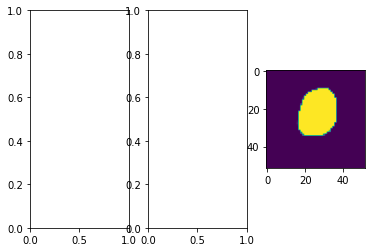

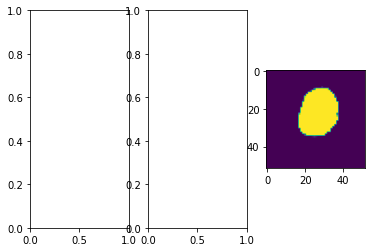

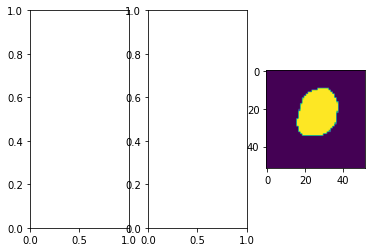

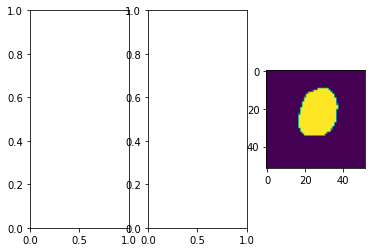

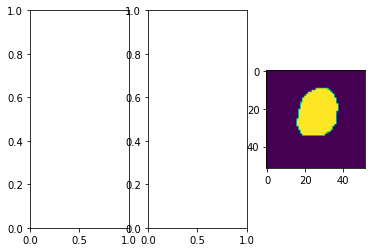

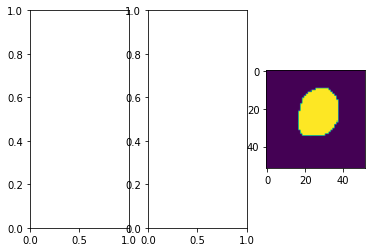

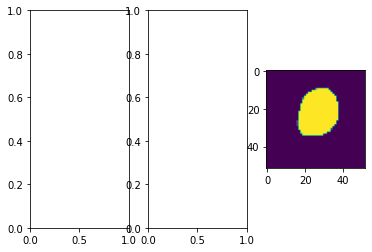

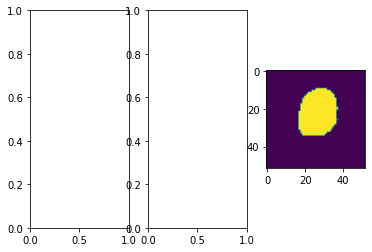

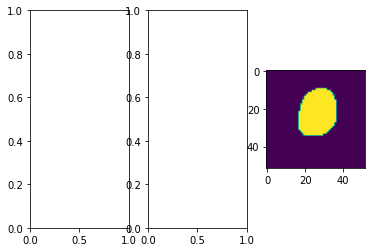

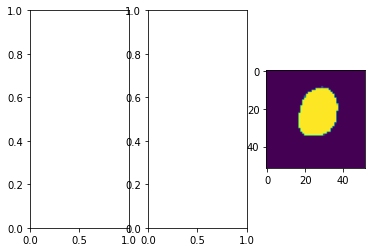

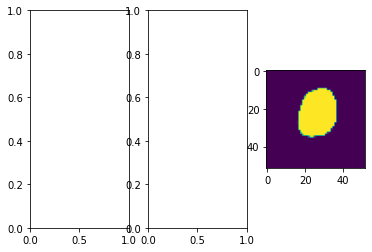

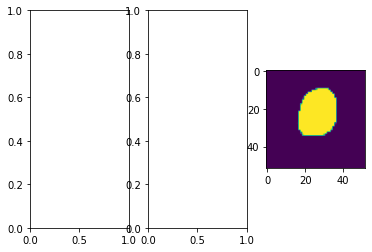

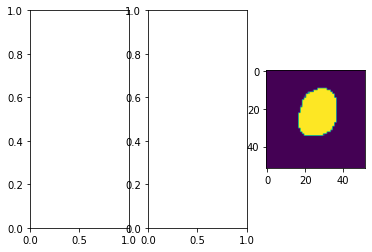

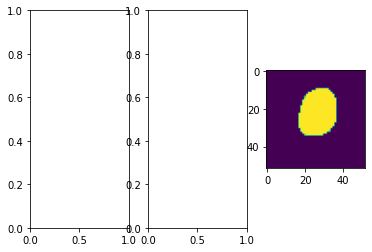

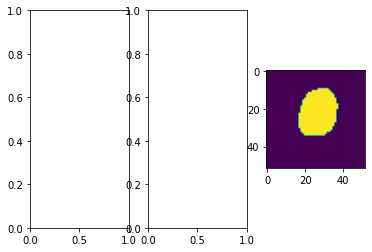

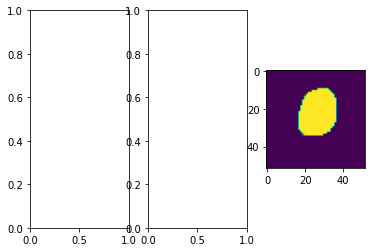

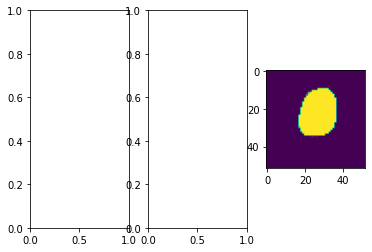

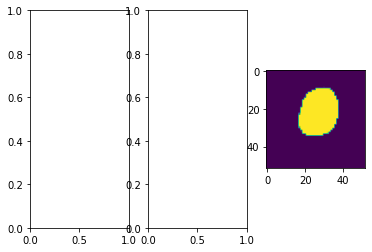

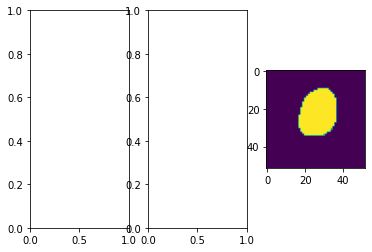

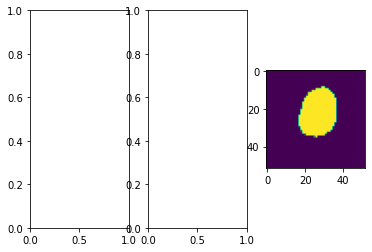

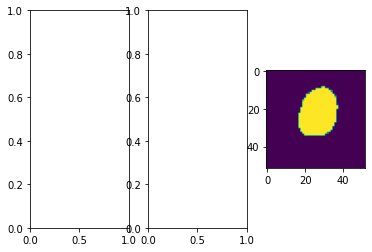

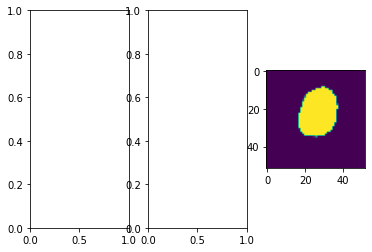

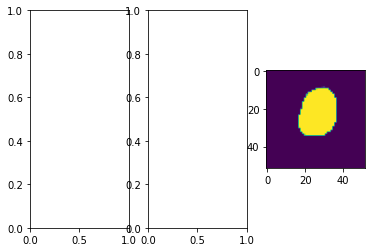

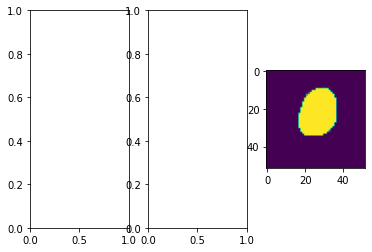

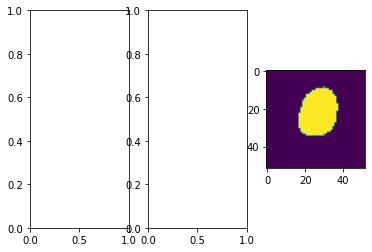

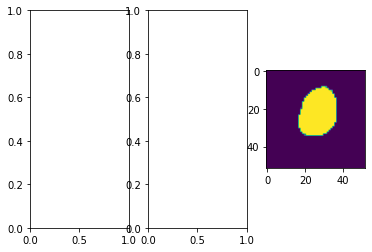

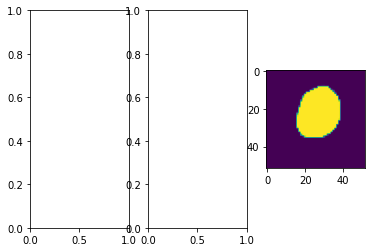

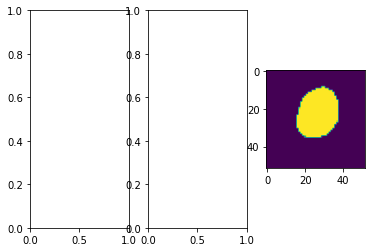

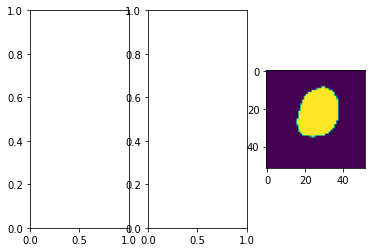

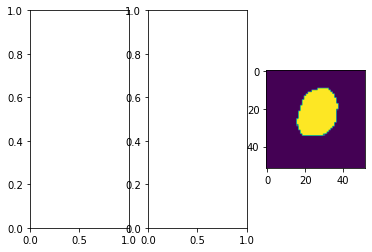

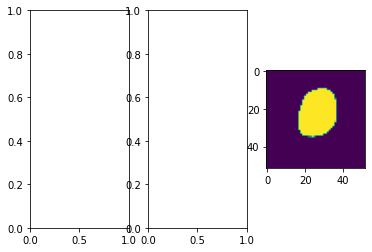

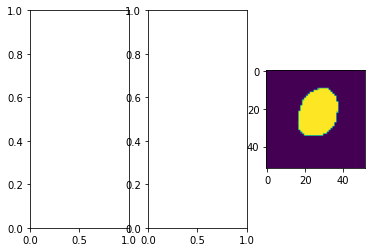

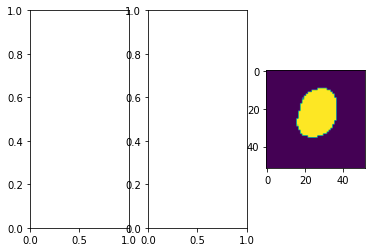

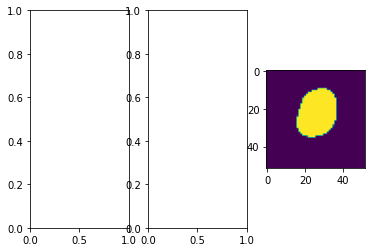

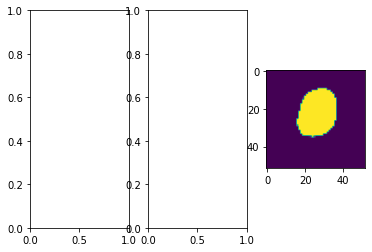

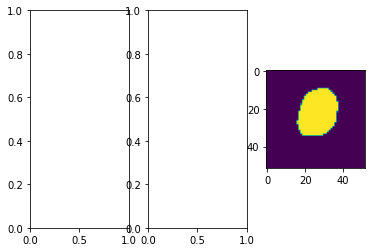

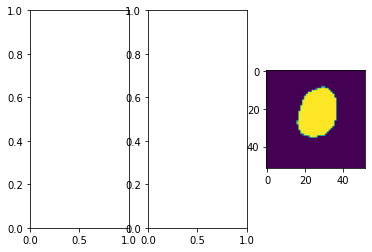

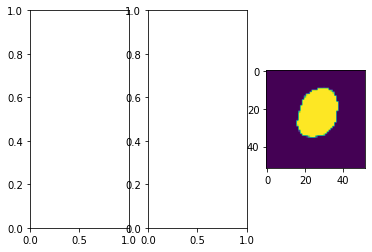

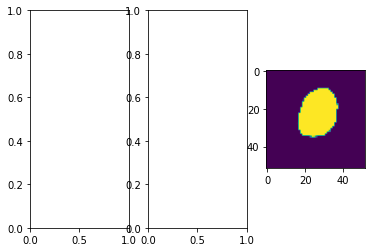

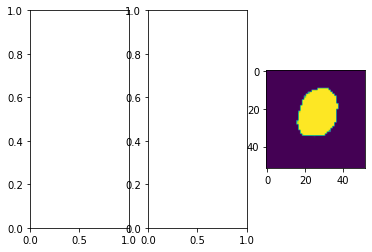

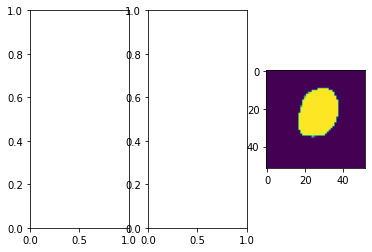

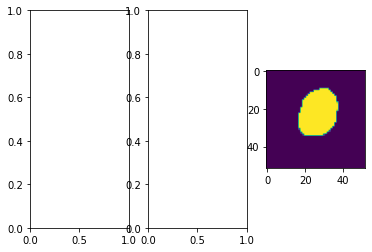

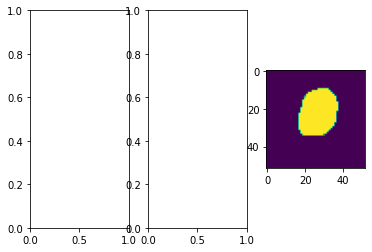

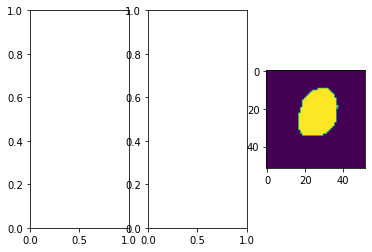

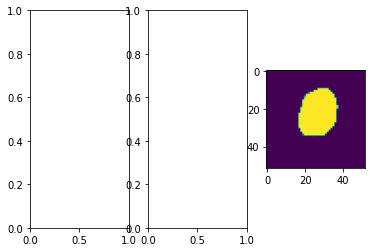

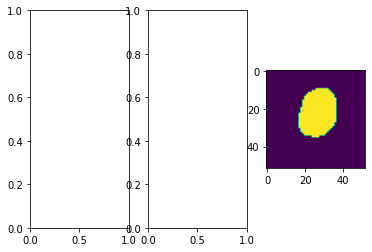

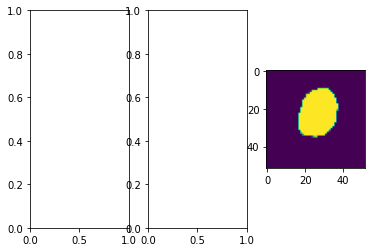

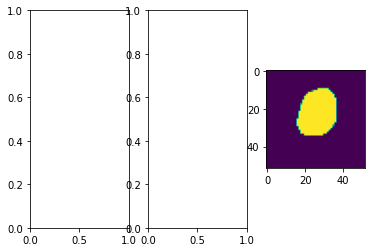

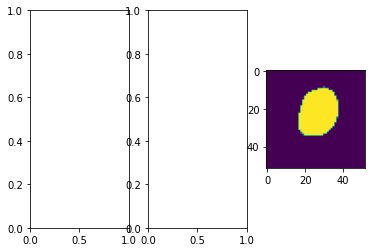

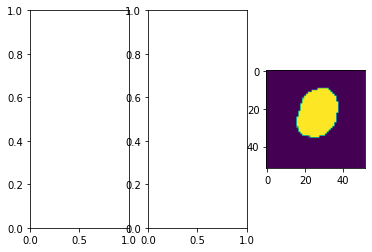

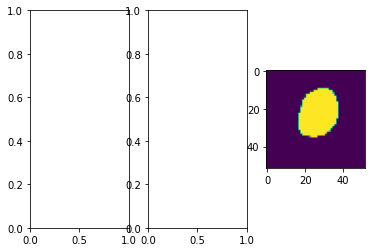

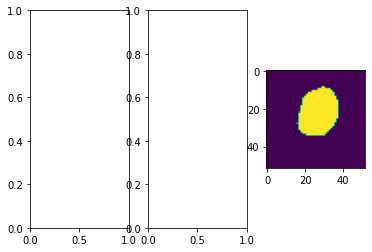

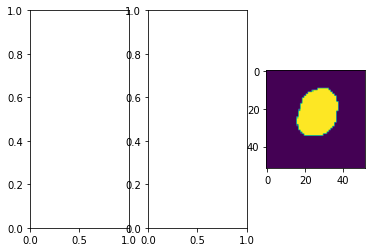

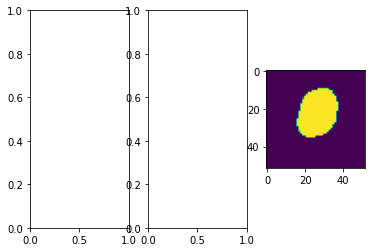

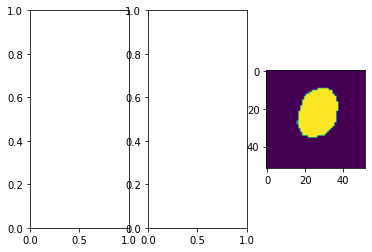

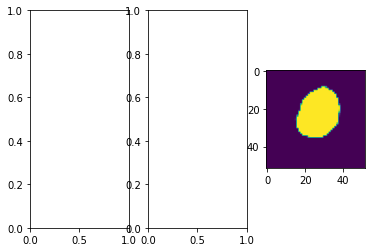

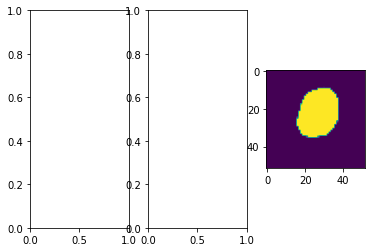

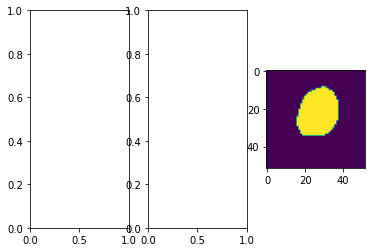

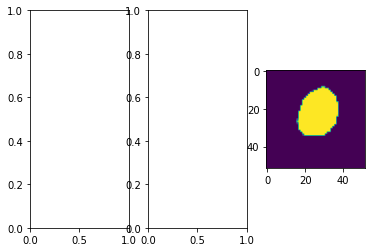

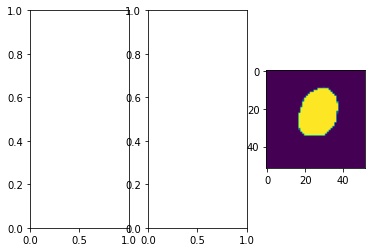

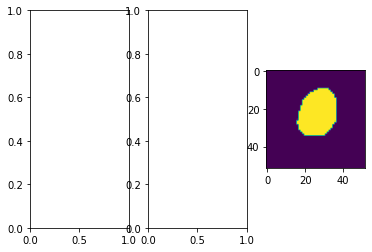

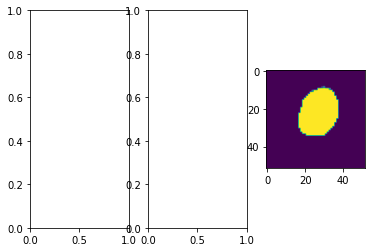

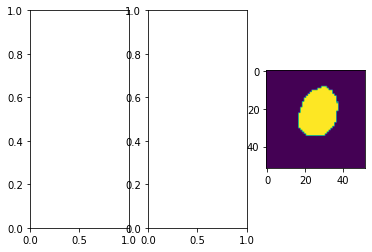

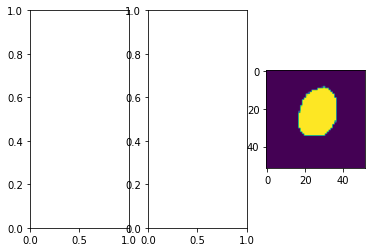

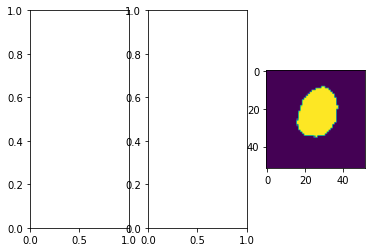

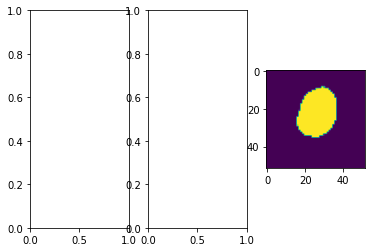

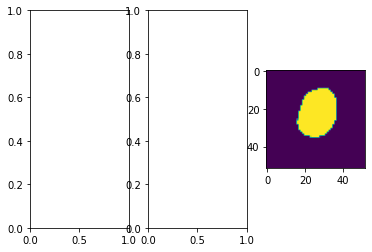

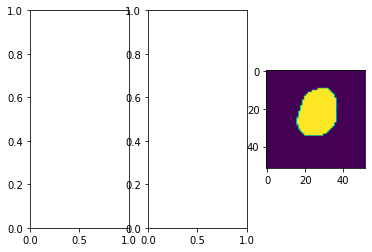

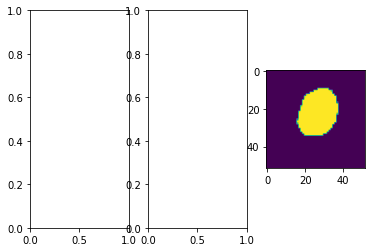

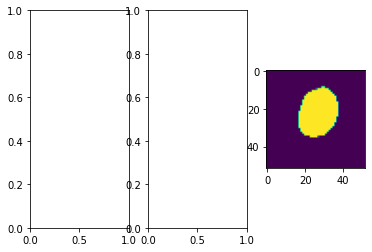

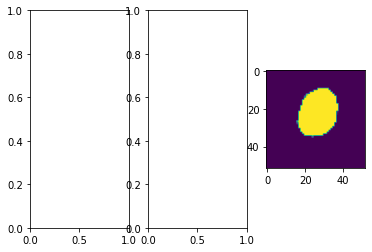

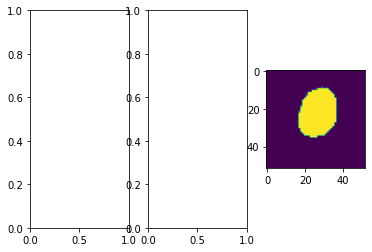

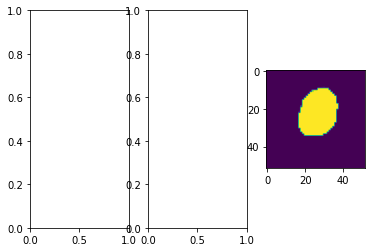

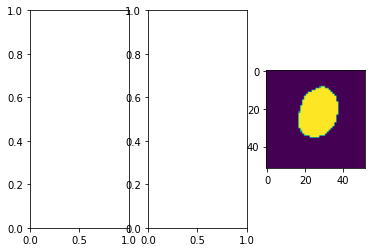

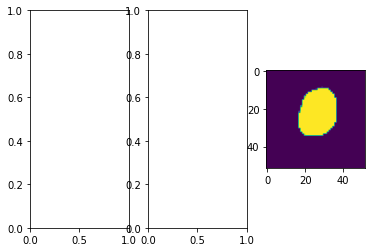

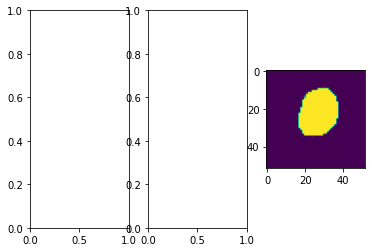

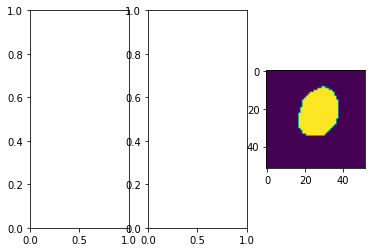

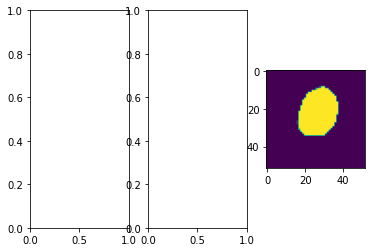

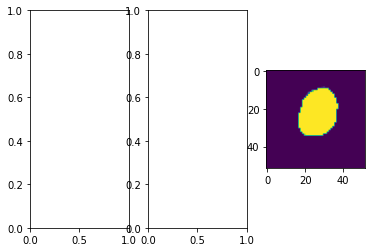

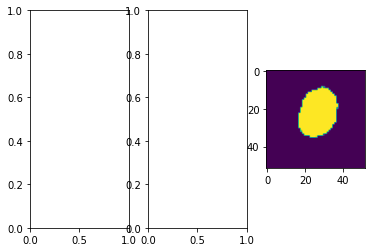

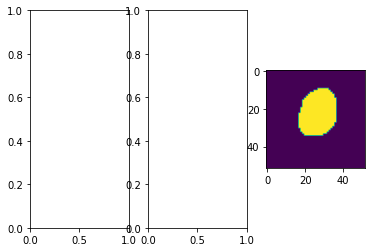

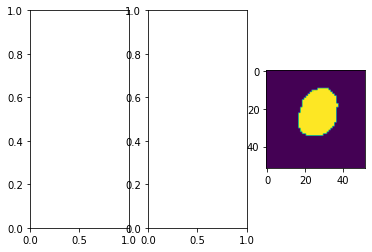

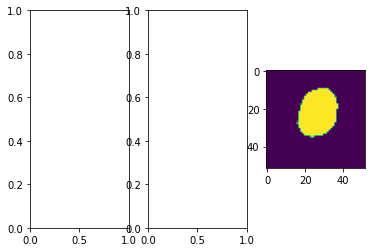

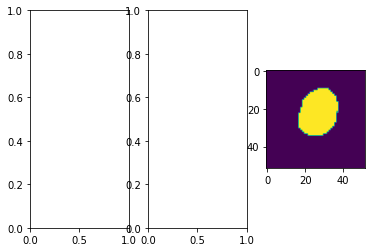

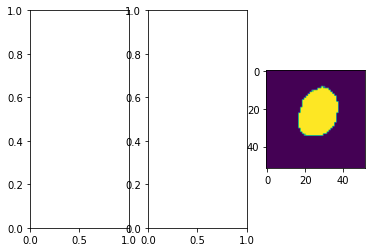

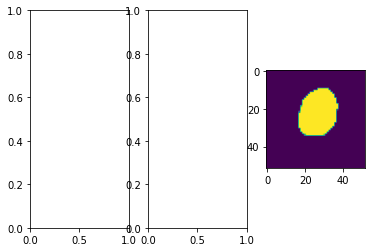

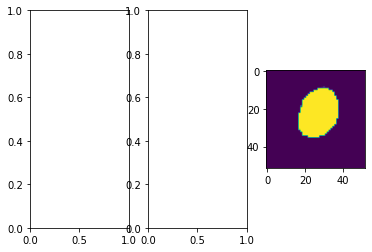

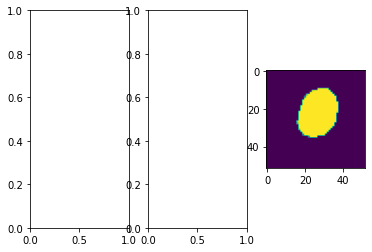

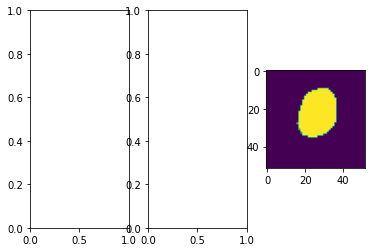

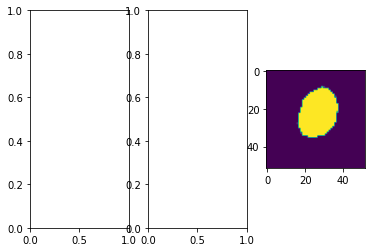

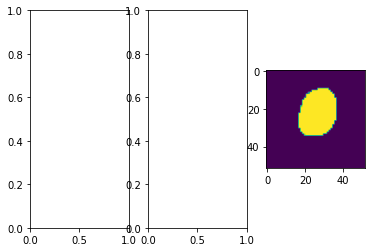

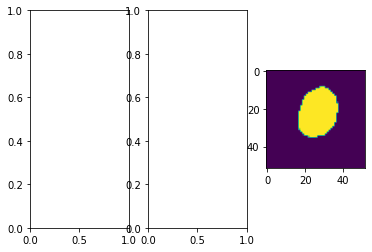

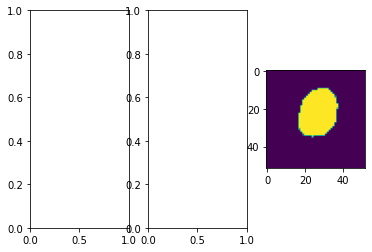

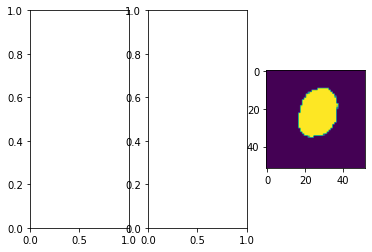

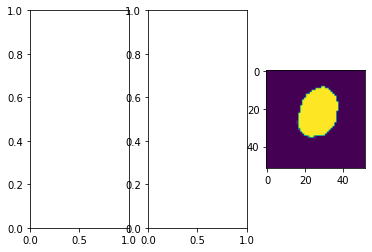

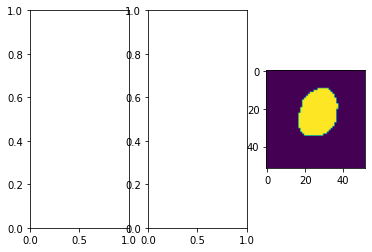

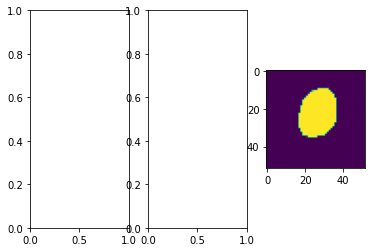

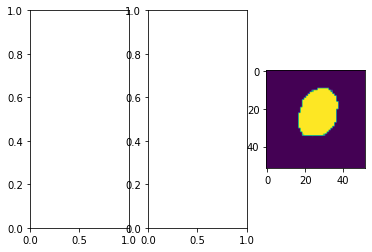

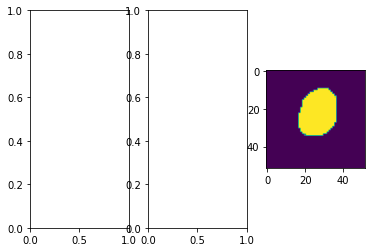

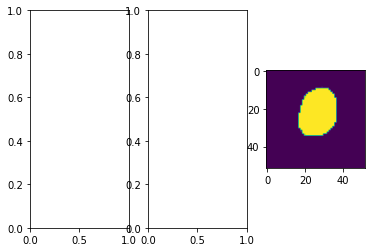

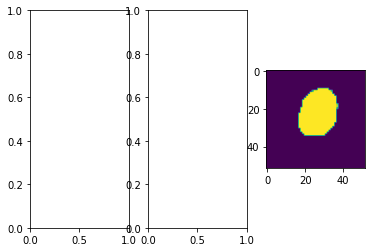

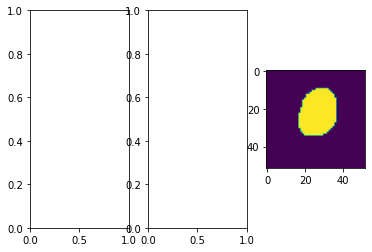

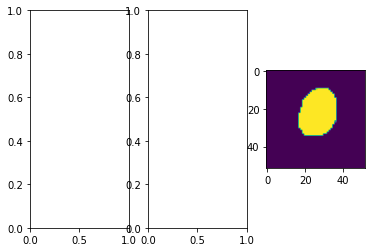

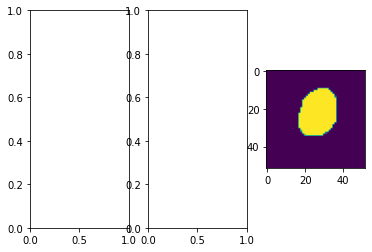

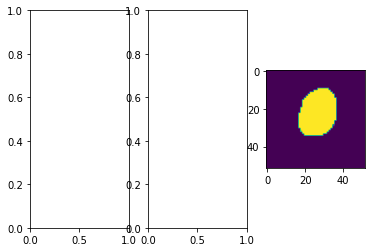

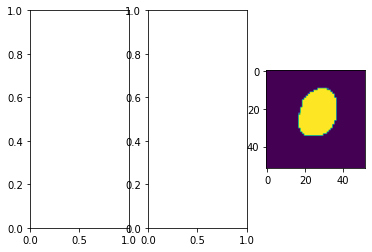

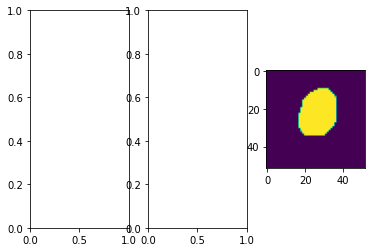

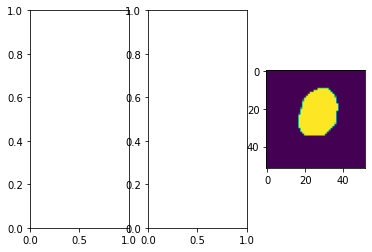

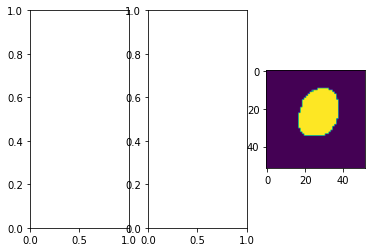

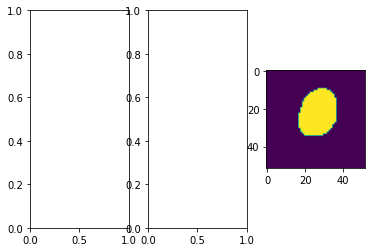

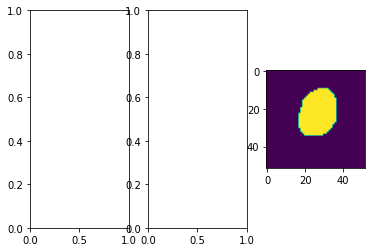

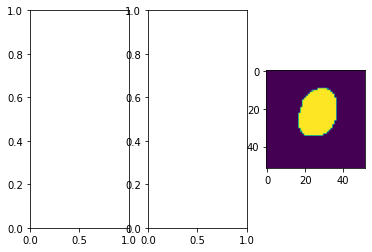

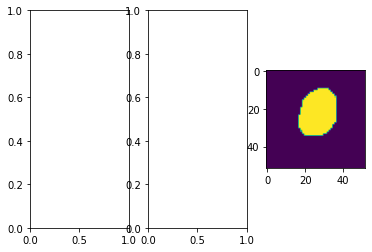

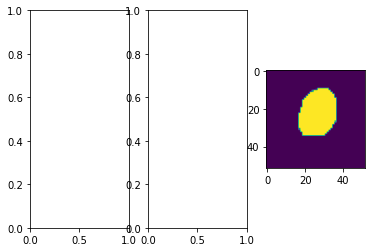

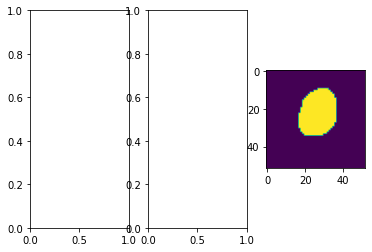

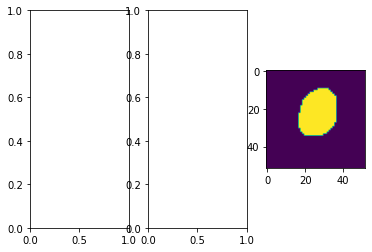

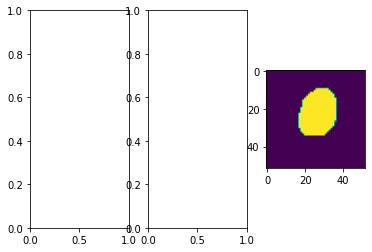

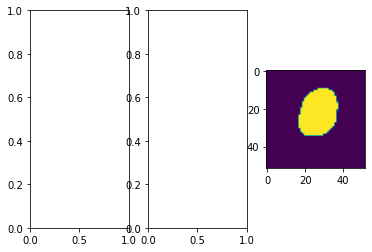

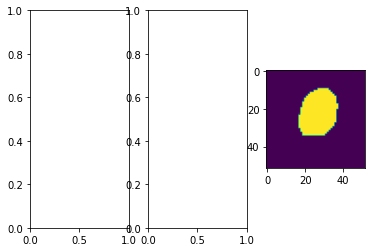

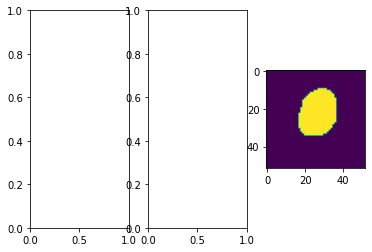

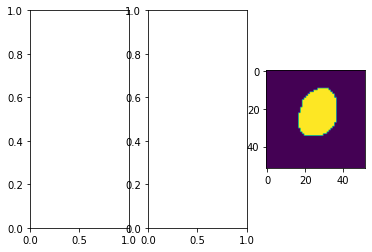

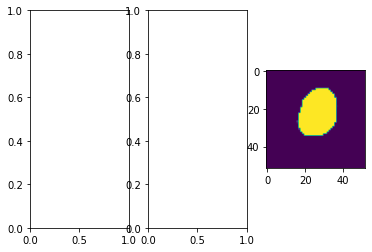

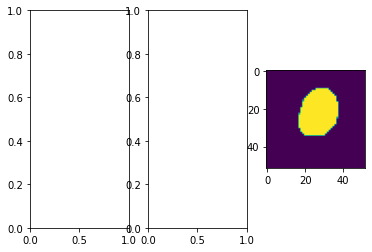

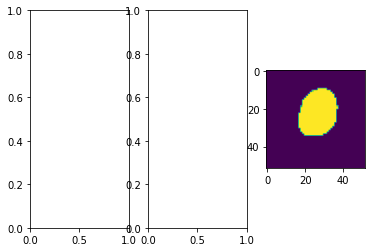

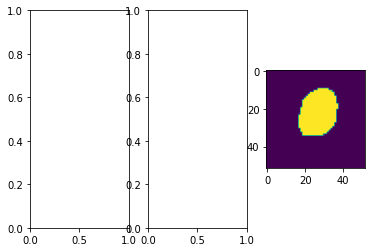

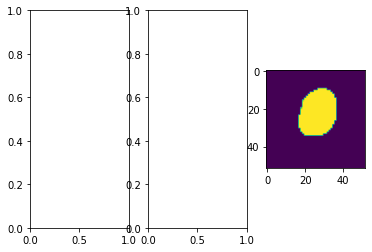

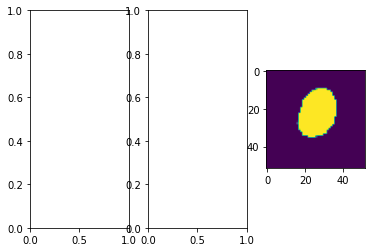

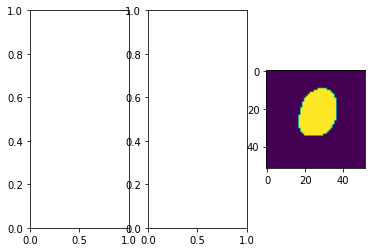

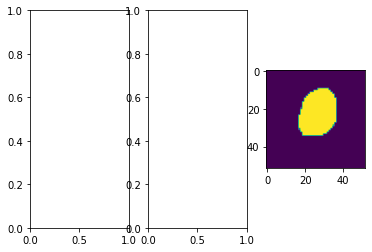

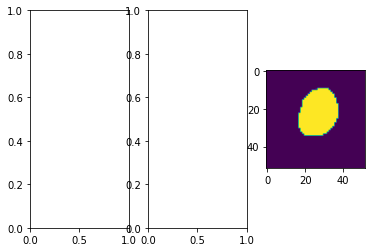

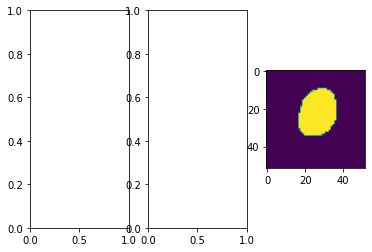

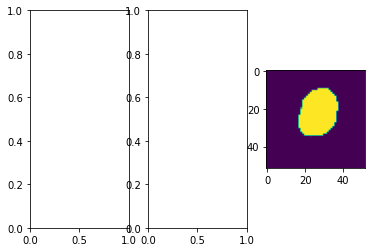

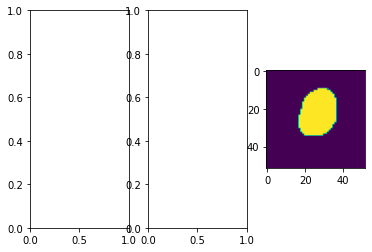

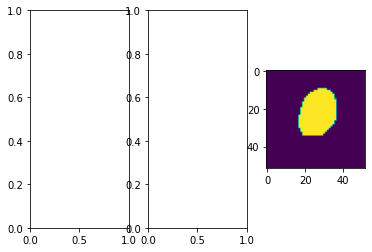

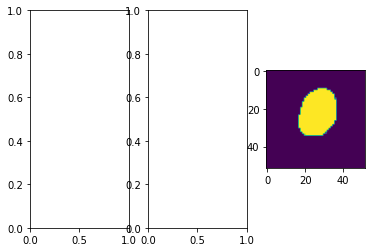

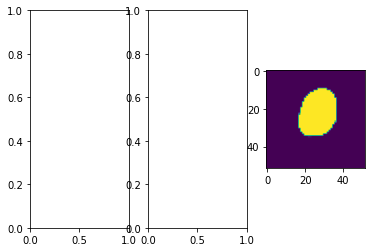

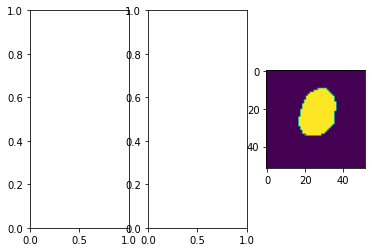

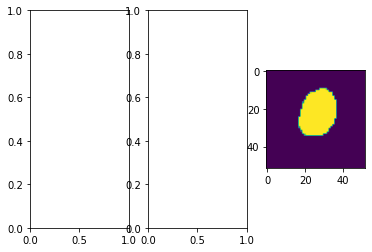

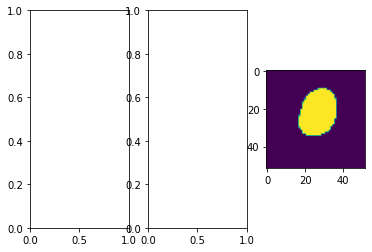

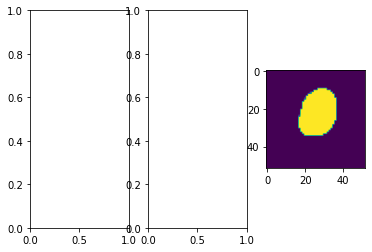

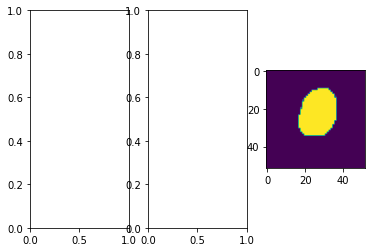

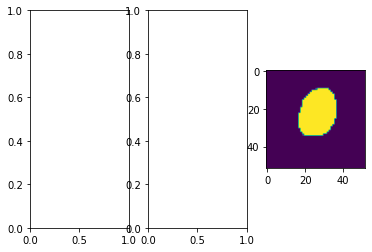

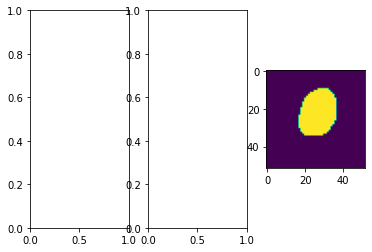

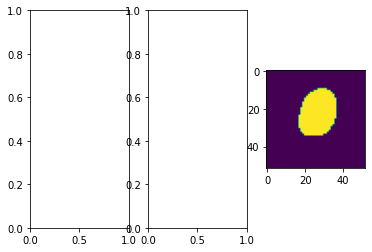

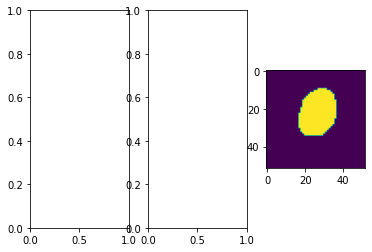

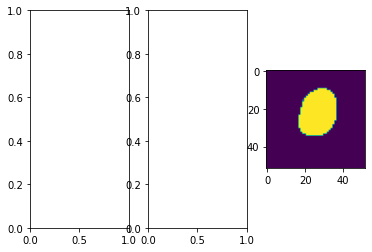

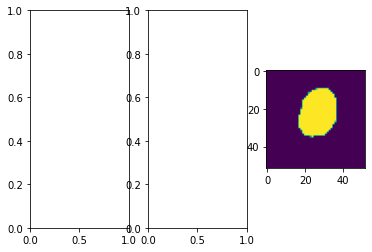

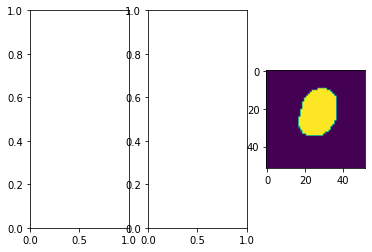

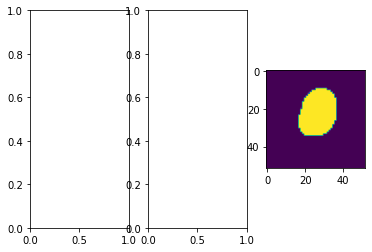

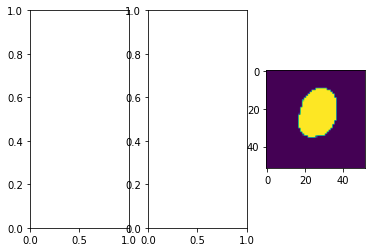

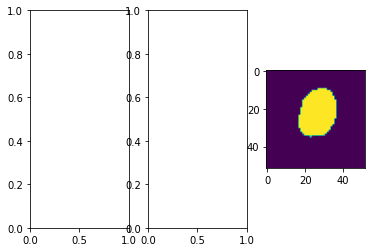

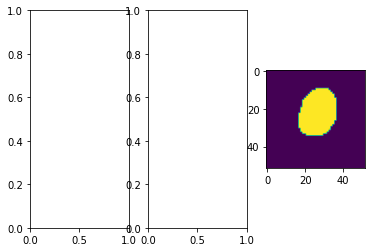

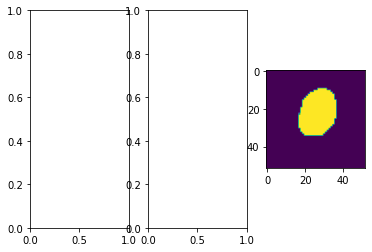

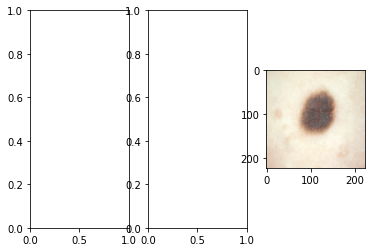

In [ ]:
# ConvNext DiceLoss

model, train_loss_list, val_loss_list = train(model, epoch_n, optim)

Epoch: 1
----------
Train Loss: 0.002373504
Val Loss: 0.011068442


Dice score train: 0.976264956


Dice score val: 0.889315579


IoU score train: 0.958383495


IoU score val: 0.837446064




Epoch: 2
----------
Train Loss: 0.002316359
Val Loss: 0.014302603


Dice score train: 0.976836411


Dice score val: 0.856973969


IoU score train: 0.959402106


IoU score val: 0.798221406




Epoch: 3
----------
Train Loss: 0.002331843
Val Loss: 0.010363321


Dice score train: 0.976681571


Dice score val: 0.896366795


IoU score train: 0.959282803


IoU score val: 0.847664201




Epoch: 4
----------
Train Loss: 0.002215429
Val Loss: 0.010507747


Dice score train: 0.977845707


Dice score val: 0.894922531


IoU score train: 0.961136182


IoU score val: 0.844398157




Epoch: 5
----------
Train Loss: 0.001947046
Val Loss: 0.010089526


Dice score train: 0.980529536


Dice score val: 0.899104741


IoU score train: 0.965685283


IoU score val: 0.849031319




Epoch: 6
----------
Train Loss: 0.002068478
Val Loss: 0.008241409


Dice score train: 0.979315225


Dice score val: 0.917585909


IoU score train: 0.963857343


IoU score val: 0.868307385




Epoch: 7
----------
Train Loss: 0.002343877
Val Loss: 0.008875531


Dice score train: 0.976561234


Dice score val: 0.911244687


IoU score train: 0.959523854


IoU score val: 0.863293886




Epoch: 8
----------
Train Loss: 0.002386209
Val Loss: 0.013602815


Dice score train: 0.976137913


Dice score val: 0.863971849


IoU score train: 0.958765477


IoU score val: 0.808023953




Epoch: 9
----------
Train Loss: 0.002311402
Val Loss: 0.011930509


Dice score train: 0.976885976


Dice score val: 0.880694913


IoU score train: 0.959298187


IoU score val: 0.829269512




Epoch: 10
----------
Train Loss: 0.001965886
Val Loss: 0.009666500


Dice score train: 0.980341141


Dice score val: 0.903335002


IoU score train: 0.965425280


IoU score val: 0.854206532




Epoch: 11
----------
Train Loss: 0.002003336
Val Loss: 0.010212142


Dice score train: 0.979966641


Dice score val: 0.897878581


IoU score train: 0.964586301


IoU score val: 0.849245618




Epoch: 12
----------
Train Loss: 0.002171492
Val Loss: 0.008724092


Dice score train: 0.978285078


Dice score val: 0.912759079


IoU score train: 0.961706176


IoU score val: 0.866100328




Epoch: 13
----------
Train Loss: 0.001981698
Val Loss: 0.010884812


Dice score train: 0.980183015


Dice score val: 0.891151882


IoU score train: 0.965278251


IoU score val: 0.839882784




Epoch: 14
----------
Train Loss: 0.001743131
Val Loss: 0.011281060


Dice score train: 0.982568693


Dice score val: 0.887189402


IoU score train: 0.969676053


IoU score val: 0.836908903




Epoch: 15
----------
Train Loss: 0.001896881
Val Loss: 0.009017859


Dice score train: 0.981031192


Dice score val: 0.909821414


IoU score train: 0.966765902


IoU score val: 0.861211684




Epoch: 16
----------
Train Loss: 0.001660970
Val Loss: 0.010676709


Dice score train: 0.983390305


Dice score val: 0.893232909


IoU score train: 0.970840622


IoU score val: 0.843267381




Epoch: 17
----------
Train Loss: 0.001676954
Val Loss: 0.009611283


Dice score train: 0.983230456


Dice score val: 0.903887169


IoU score train: 0.970586922


IoU score val: 0.854465564




Epoch: 18
----------
Train Loss: 0.001909315
Val Loss: 0.011638099


Dice score train: 0.980906849


Dice score val: 0.883619007


IoU score train: 0.966418107


IoU score val: 0.831941876




Epoch: 19
----------
Train Loss: 0.002102650
Val Loss: 0.011951710


Dice score train: 0.978973502


Dice score val: 0.880482899


IoU score train: 0.962770694


IoU score val: 0.828320752




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch: 20
----------
Train Loss: 0.001930376
Val Loss: 0.011534721


Dice score train: 0.980696240


Dice score val: 0.884652793


IoU score train: 0.966208286


IoU score val: 0.827722162




Epoch: 21
----------
Train Loss: 0.002327611
Val Loss: 0.011047886


Dice score train: 0.976723886


Dice score val: 0.889521142


IoU score train: 0.959036362


IoU score val: 0.835247527




Epoch: 22
----------
Train Loss: 0.002195340
Val Loss: 0.010883721


Dice score train: 0.978046603


Dice score val: 0.891162793


IoU score train: 0.961718111


IoU score val: 0.839206689




Epoch: 23
----------
Train Loss: 0.001894662
Val Loss: 0.009608244


Dice score train: 0.981053381


Dice score val: 0.903917558


IoU score train: 0.966644626


IoU score val: 0.853313645




Epoch: 24
----------
Train Loss: 0.002059792
Val Loss: 0.009255330


Dice score train: 0.979402081


Dice score val: 0.907446696


IoU score train: 0.964009563


IoU score val: 0.860498206




Epoch: 25
----------
Train Loss: 0.002652713
Val Loss: 0.008832577


Dice score train: 0.973472867


Dice score val: 0.911674228


IoU score train: 0.954017825


IoU score val: 0.861249487




Epoch: 26
----------
Train Loss: 0.002215328
Val Loss: 0.009263370


Dice score train: 0.977846719


Dice score val: 0.907366299


IoU score train: 0.961810492


IoU score val: 0.859540509




Epoch: 27
----------
Train Loss: 0.001569109
Val Loss: 0.009526664


Dice score train: 0.984308910


Dice score val: 0.904733357


IoU score train: 0.972652343


IoU score val: 0.855443855




Epoch: 28
----------
Train Loss: 0.001389346
Val Loss: 0.010192000


Dice score train: 0.986106540


Dice score val: 0.898080005


IoU score train: 0.975692396


IoU score val: 0.845890446




Epoch: 29
----------
Train Loss: 0.001472596
Val Loss: 0.010795850


Dice score train: 0.985274036


Dice score val: 0.892041498


IoU score train: 0.974499081


IoU score val: 0.840336684




Epoch: 30
----------
Train Loss: 0.001480102
Val Loss: 0.008976164


Dice score train: 0.985198977


Dice score val: 0.910238359


IoU score train: 0.974090764


IoU score val: 0.861862587




Epoch: 31
----------
Train Loss: 0.001436795
Val Loss: 0.009812956


Dice score train: 0.985632047


Dice score val: 0.901870439


IoU score train: 0.975061837


IoU score val: 0.853578657




Epoch: 32
----------
Train Loss: 0.001286640
Val Loss: 0.008617690


Dice score train: 0.987133599


Dice score val: 0.913823101


IoU score train: 0.977828522


IoU score val: 0.867248406




Epoch: 33
----------
Train Loss: 0.001132490
Val Loss: 0.008506885


Dice score train: 0.988675103


Dice score val: 0.914931155


IoU score train: 0.980532388


IoU score val: 0.868823707




Epoch: 34
----------
Train Loss: 0.001184927
Val Loss: 0.008551713


Dice score train: 0.988150734


Dice score val: 0.914482868


IoU score train: 0.979850926


IoU score val: 0.868723257




Epoch: 35
----------
Train Loss: 0.001345858
Val Loss: 0.009204119


Dice score train: 0.986541423


Dice score val: 0.907958806


IoU score train: 0.976662522


IoU score val: 0.857655886




Epoch: 36
----------
Train Loss: 0.001315451
Val Loss: 0.009956277


Dice score train: 0.986845492


Dice score val: 0.900437226


IoU score train: 0.977217643


IoU score val: 0.850353489




Epoch: 37
----------
Train Loss: 0.001615093
Val Loss: 0.008720702


Dice score train: 0.983849067


Dice score val: 0.912792984


IoU score train: 0.971987690


IoU score val: 0.867325458




Epoch: 38
----------
Train Loss: 0.001049167
Val Loss: 0.009103538


Dice score train: 0.989508325


Dice score val: 0.908964617


IoU score train: 0.982185173


IoU score val: 0.860849669




Epoch: 39
----------
Train Loss: 0.000994044
Val Loss: 0.010674652


Dice score train: 0.990059562


Dice score val: 0.893253479


IoU score train: 0.983005997


IoU score val: 0.839918113


Epoch: 40
----------
Train Loss: 0.000985789
Val Loss: 0.010732718


Dice score train: 0.990142114


Dice score val: 0.892672820


IoU score train: 0.983070811


IoU score val: 0.837491986




Epoch: 41
----------
Train Loss: 0.001287571
Val Loss: 0.008065316


Dice score train: 0.987124286


Dice score val: 0.919346843


IoU score train: 0.977779012


IoU score val: 0.874075979




Epoch: 42
----------
Train Loss: 0.001195372
Val Loss: 0.008853873


Dice score train: 0.988046284


Dice score val: 0.911461267


IoU score train: 0.979320611


IoU score val: 0.860721270




Epoch: 43
----------
Train Loss: 0.000890445
Val Loss: 0.009773425


Dice score train: 0.991095552


Dice score val: 0.902265751


IoU score train: 0.984943868


IoU score val: 0.852124936




Epoch: 44
----------
Train Loss: 0.000914011
Val Loss: 0.011519233


Dice score train: 0.990859887


Dice score val: 0.884807673


IoU score train: 0.984978205


IoU score val: 0.824848970




Epoch: 45
----------
Train Loss: 0.001305931
Val Loss: 0.009709050


Dice score train: 0.986940688


Dice score val: 0.902909501


IoU score train: 0.978269665


IoU score val: 0.851986865




Epoch: 46
----------
Train Loss: 0.001218839
Val Loss: 0.009523754


Dice score train: 0.987811611


Dice score val: 0.904762457


IoU score train: 0.978917208


IoU score val: 0.854036745




Epoch: 47
----------
Train Loss: 0.001070451
Val Loss: 0.010579694


Dice score train: 0.989295494


Dice score val: 0.894203060


IoU score train: 0.981612905


IoU score val: 0.840790990




Epoch: 48
----------
Train Loss: 0.000869523
Val Loss: 0.008325853


Dice score train: 0.991304770


Dice score val: 0.916741470


IoU score train: 0.985625765


IoU score val: 0.872438785




Epoch: 49
----------
Train Loss: 0.000693642
Val Loss: 0.010561213


Dice score train: 0.993063577


Dice score val: 0.894387868


IoU score train: 0.988438232


IoU score val: 0.842469335




Epoch: 50
----------
Train Loss: 0.000708162
Val Loss: 0.008155993


Dice score train: 0.992918384


Dice score val: 0.918440074


IoU score train: 0.988526842


IoU score val: 0.870645609




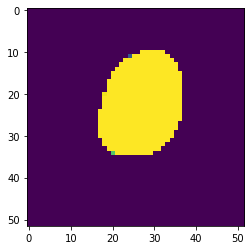

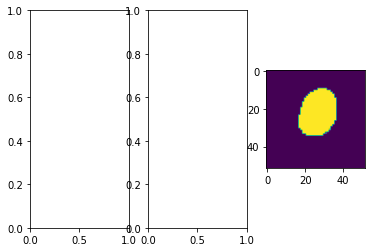

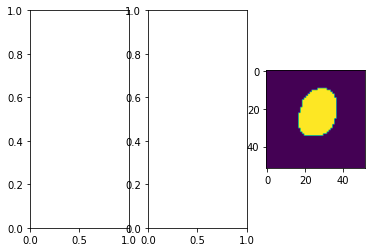

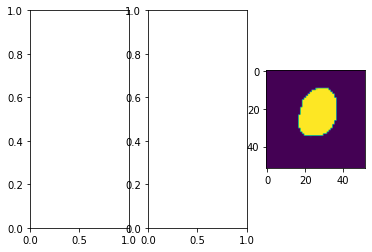

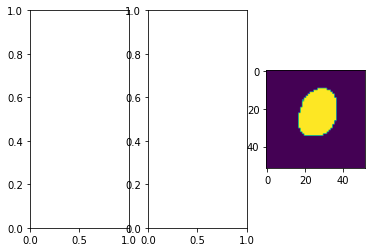

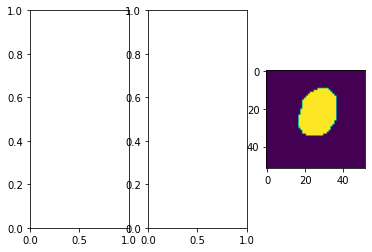

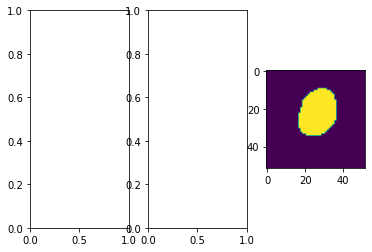

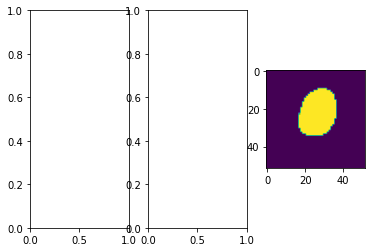

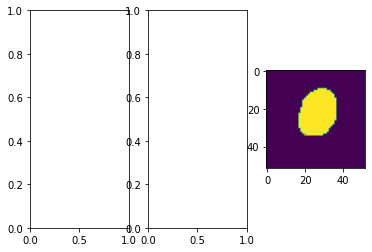

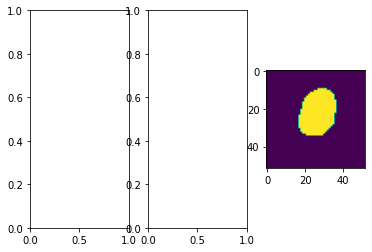

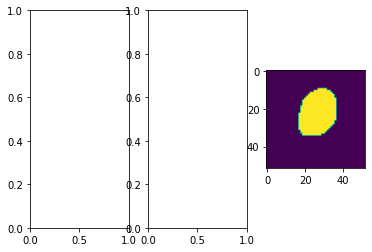

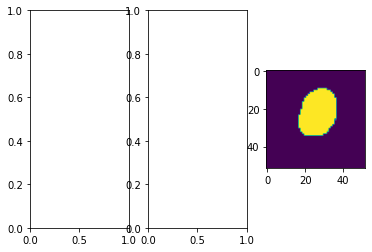

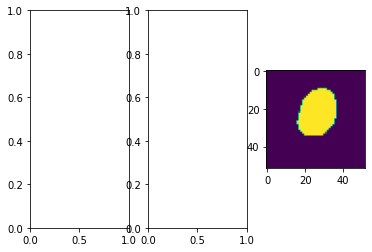

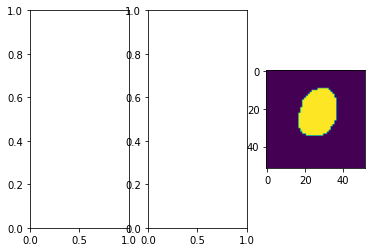

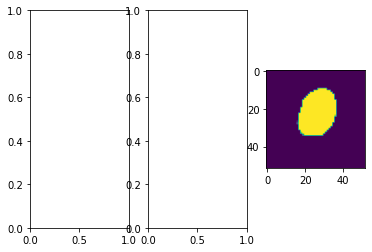

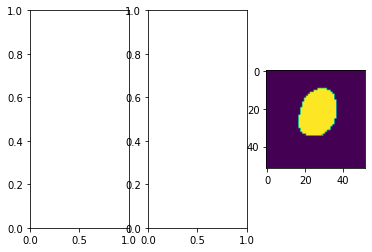

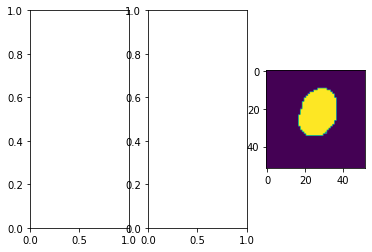

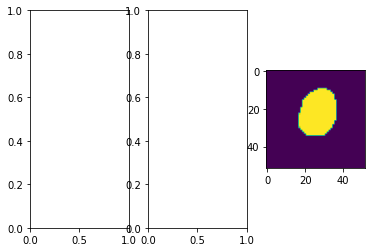

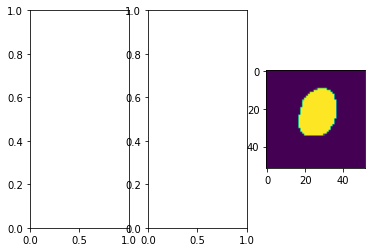

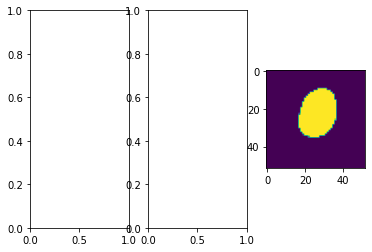

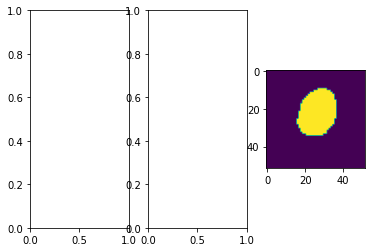

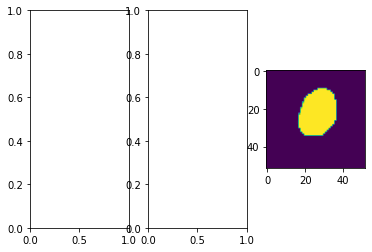

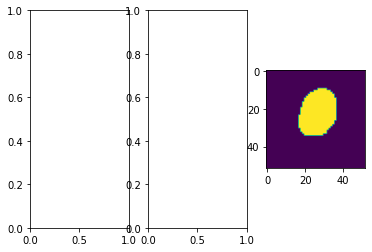

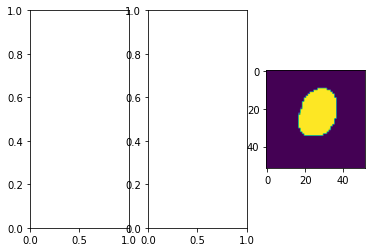

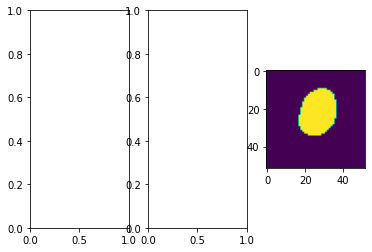

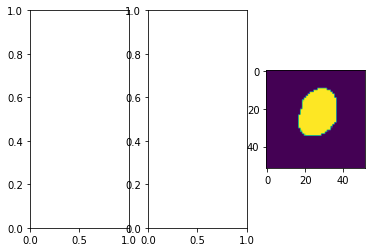

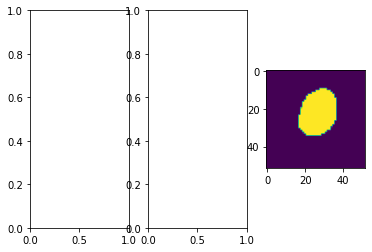

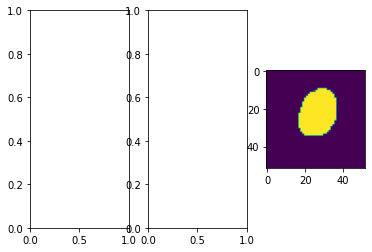

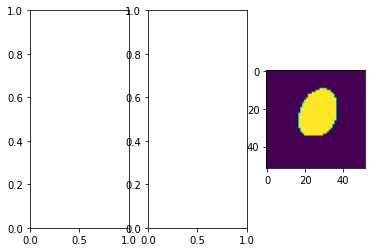

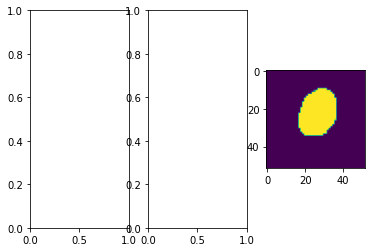

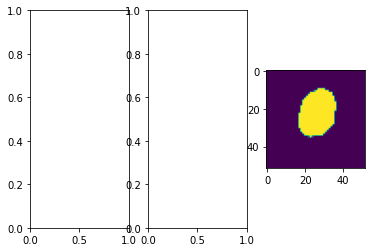

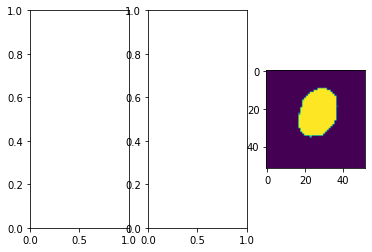

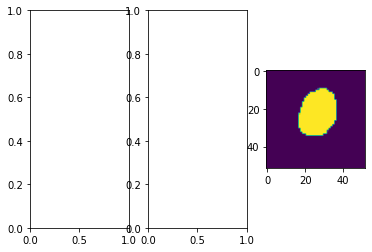

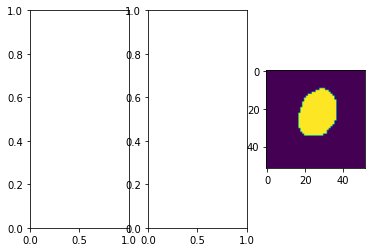

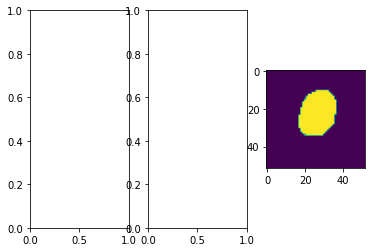

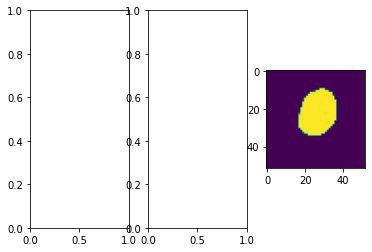

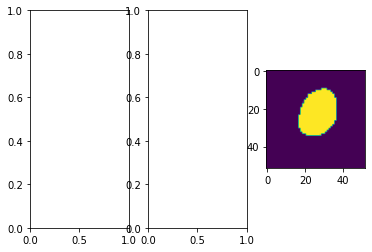

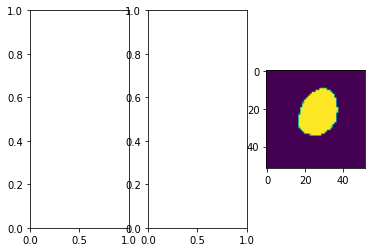

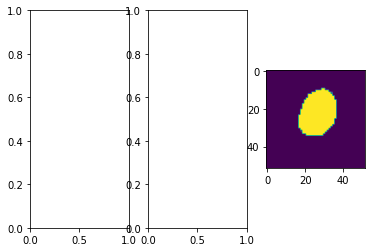

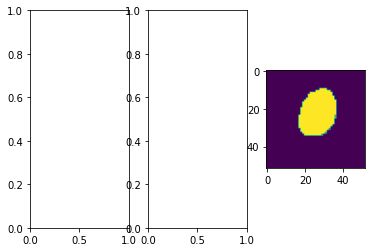

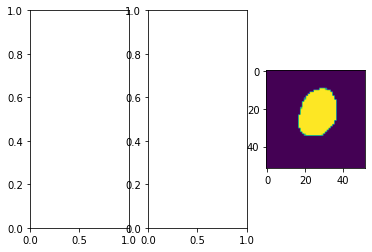

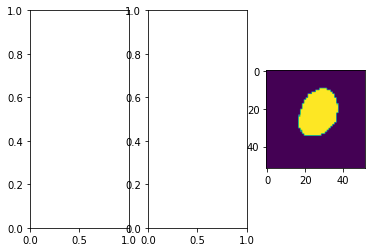

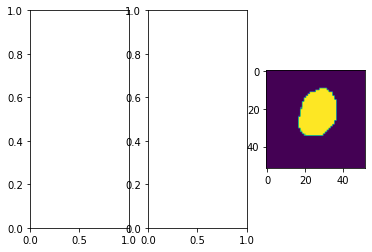

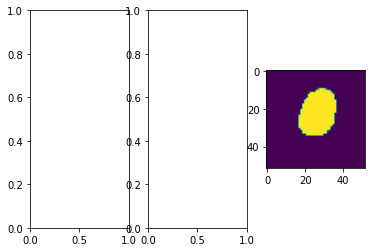

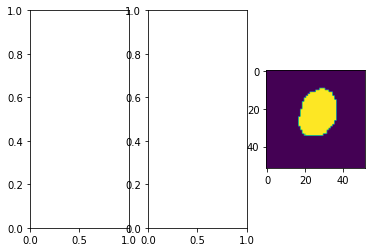

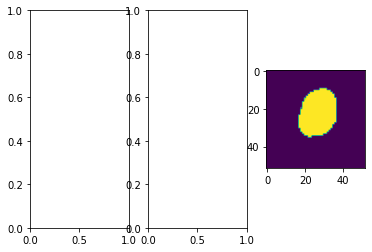

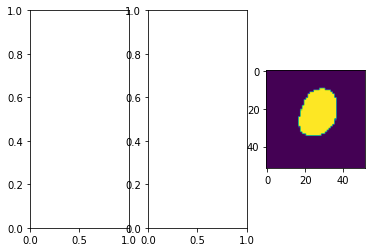

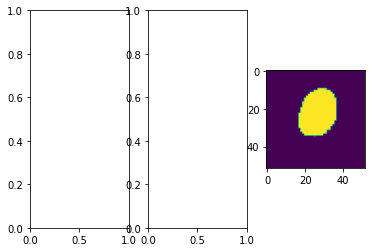

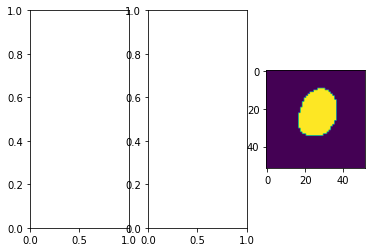

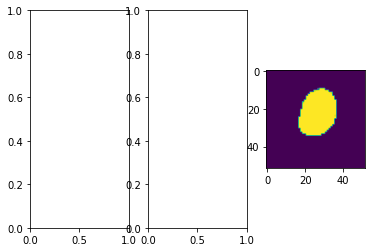

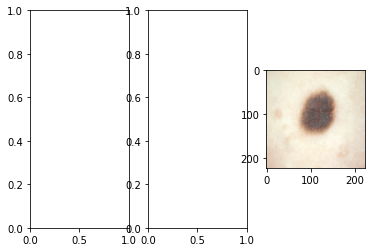

In [ ]:
# ConvNext DiceLoss with lowered LR

model, train_loss_list, val_loss_list = train(model, epoch_n, optim)

In [ ]:
# ConvNext Focal_Tversky_Loss with Preprocessed Images

model, train_loss_list, val_loss_list = train(model, epoch_n, optim)

Epoch: 1
----------
Train Loss: nan
Val Loss: nan


Dice score train: nan


Dice score val: nan


IoU score train: nan


IoU score val: nan




Epoch: 2
----------
Train Loss: nan
Val Loss: nan


Dice score train: nan


Dice score val: nan


IoU score train: nan


IoU score val: nan




Epoch: 3
----------
Train Loss: nan
Val Loss: nan


Dice score train: nan


Dice score val: nan


IoU score train: nan


IoU score val: nan




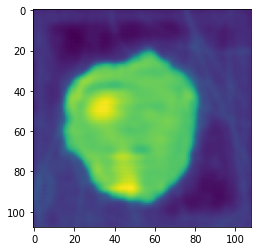

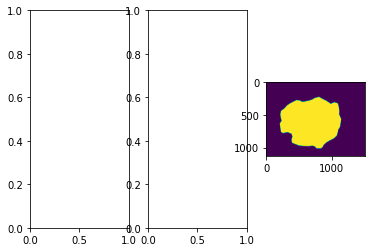

In [ ]:
# mask generation

model = U_Net(n_channels, n_classes)
state=torch.load('/content/drive/MyDrive/ISBI-2016_pre-processed/models/U_Net_weights_IoUloss_Renet-34.pth') # ekhane previous weight ta src korbi
model.load_state_dict(state['model_state'])

def mask_generation(model, img, mask):
  img = torch.from_numpy(np.array([SegDataset.preprocess(img,224)])).type(torch.FloatTensor)
  mask_gen = model(torch.Tensor(img))
  plt.imshow(mask_gen.cpu().detach().numpy()[0][0])
  _, axarr = plt.subplots(1,3)
  # print(mask_gen.shape)
  # print(img.shape)
  axarr[0] = plt.imshow(img.cpu().detach().numpy()[0].transpose((1,2,0)))
  axarr[1] = plt.imshow(mask)

img = Image.open('/content/drive/MyDrive/ISBI-2016_pre-processed/input/ISIC_0000019.jpg')
mask = Image.open('/content/drive/MyDrive/ISBI-2016_pre-processed/target/ISIC_0000019_Segmentation.png')
mask_generation(model, img, mask)

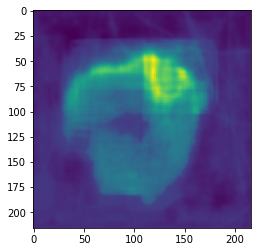

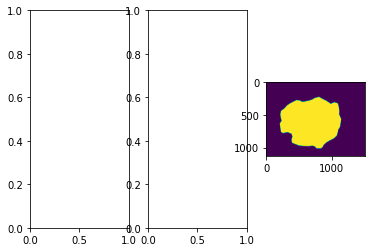

In [ ]:
# mask generation

model = U_Net(n_channels, n_classes)
state=torch.load('/content/drive/MyDrive/ISBI-2016_pre-processed/models/U_Net_weights_IoUloss.pth') # ekhane previous weight ta src korbi
model.load_state_dict(state['model_state'])

def mask_generation(model, img, mask):
  img = torch.from_numpy(np.array([SegDataset.preprocess(img,224)])).type(torch.FloatTensor)
  mask_gen = model(torch.Tensor(img))
  plt.imshow(mask_gen.cpu().detach().numpy()[0][0])
  _, axarr = plt.subplots(1,3)
  # print(mask_gen.shape)
  # print(img.shape)
  axarr[0] = plt.imshow(img.cpu().detach().numpy()[0].transpose((1,2,0)))
  axarr[1] = plt.imshow(mask)

img = Image.open('/content/drive/MyDrive/ISBI-2016_pre-processed/input/ISIC_0000019.jpg')
mask = Image.open('/content/drive/MyDrive/ISBI-2016_pre-processed/target/ISIC_0000019_Segmentation.png')
mask_generation(model, img, mask)

In [ ]:
pip install Py-FS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 5.0 MB/s 


In [ ]:
pip install relieff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.2 MB/s 
  Created wheel for relieff: filename=ReliefF-0.1.2-py3-none-any.whl size=6319 sha256=aacc54e3a866d5028db08c4cb98b20e5ed7fa73c9b9bd79adcc95bc80045479f
  Stored in directory: /root/.cache/pip/wheels/18/8a/4a/3aada56cb869df4c1b1ed6af509c941a25985d1d1258a2e78c
Successfully built relieff


In [ ]:
for folder in ['train','test','val']:
  for folder1 in ['colon_aca','colon_n']:
    for filename in os.listdir('/content/drive/MyDrive/LC25000_grouped/colon_image_sets/{}/{}'.format(folder,folder1)):
      filename_new = filename[2:]
      os.rename('/content/drive/MyDrive/LC25000_grouped/colon_image_sets/{}/{}/{}'.format(folder,folder1,filename),'/content/drive/MyDrive/LC25000_grouped/colon_image_sets/{}/{}/{}'.format(folder,folder1,filename_new))

In [ ]:
eff_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
print(*list(eff_model.children())[2:][1:][2:])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Sequential(
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (squeeze): Flatten()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=1792, out_features=1000, bias=True)
)


In [ ]:
src = '/content/drive/MyDrive/ISBI_2016/'
dest = '/content/drive/MyDrive/ISBI-2016_pre-processed/'
fold_type = ['test/','train/','val/']
class_name = ['benign/','malignant/']

In [ ]:
def pre_process(img):

  img = 255-img

  def DarkChannel(im,sz):
      b,g,r = cv2.split(im)
      dc = cv2.min(cv2.min(r,g),b);
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
      dark = cv2.erode(dc,kernel)
      return dark

  def AtmLight(im,dark):
      [h,w] = im.shape[:2]
      imsz = h*w
      numpx = int(max(math.floor(imsz/1000),1))
      darkvec = dark.reshape(imsz);
      imvec = im.reshape(imsz,3);

      indices = darkvec.argsort();
      indices = indices[imsz-numpx::]

      atmsum = np.zeros([1,3])
      for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]

      A = atmsum / numpx;
      return A

  def TransmissionEstimate(im,A,sz):
      omega = 0.99;
      im3 = np.empty(im.shape,im.dtype);

      for ind in range(0,3):
          im3[:,:,ind] = im[:,:,ind]/A[0,ind]

      transmission = 1 - omega*DarkChannel(im3,sz);
      return transmission

  def Guidedfilter(im,p,r,eps):
      mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
      mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
      mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
      cov_Ip = mean_Ip - mean_I*mean_p;

      mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
      var_I   = mean_II - mean_I*mean_I;

      a = cov_Ip/(var_I + eps);
      b = mean_p - a*mean_I;

      mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
      mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

      q = mean_a*im + mean_b;
      return q;

  def TransmissionRefine(im,et):
      gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
      gray = np.float64(gray)/255;
      r = 60;
      eps = 0.0001;
      t = Guidedfilter(gray,et,r,eps);

      return t;

  def Recover(im,t,A,tx = 0.1):
      res = np.empty(im.shape,im.dtype);
      t = cv2.max(t,tx);

      for ind in range(0,3):
          res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

      return res

  I = img.astype('float64')/255;
  dark = DarkChannel(I,35);
  A = AtmLight(I,dark);
  te = TransmissionEstimate(I,A,7);
  t = TransmissionRefine(img,te);
  J = Recover(I,t,A,0.1);
  J = (J*255).astype('uint8')
  img_final = cv2.cvtColor(J, cv2.COLOR_RGB2LAB)

  return img_final

In [ ]:
for fold in fold_type:
  for class_n in class_name:
    for files in os.listdir(src+fold+class_n):
      img = cv2.imread(src+fold+class_n+files)
      processed_img = pre_process(img)
      cv2.imwrite(dest+fold+class_n+files,processed_img)

In [ ]:
# Hyperparameter Tuning
epoch_n = 50
l_rate = 0.0001
batch_size_tr = 10
batch_size_val = 5

In [ ]:
# Augmentation of dataset

train_transform = transf.Compose([
    transf.Resize((380,380)),
    transf.ColorJitter(brightness=0.5),
    transf.RandomAdjustSharpness(sharpness_factor=5),
    transf.RandomAutocontrast(),
    transf.ToTensor()
])

val_transform = transf.Compose([
    transf.Resize((380,380)),
    transf.ToTensor()
])
train_ds = ImageFolder('/content/drive/MyDrive/Lung_Carcinoma/data_folder_2/train/', transform=train_transform)
val_ds = ImageFolder('/content/drive/MyDrive/Lung_Carcinoma/data_folder_2/val/', transform=val_transform)
test_ds = ImageFolder('/content/drive/MyDrive/Lung_Carcinoma/data_folder_2/test/', transform=val_transform)
train_load = DataLoader(dataset=train_ds, batch_size=batch_size_tr, shuffle=True, drop_last=False)
val_load = DataLoader(dataset=val_ds, batch_size=batch_size_val, shuffle=True, drop_last=False)
test_load = DataLoader(dataset=test_ds, batch_size=batch_size_val, shuffle=True, drop_last=False)
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

KeyboardInterrupt: ignored

In [ ]:
len(os.listdir('/content/drive/MyDrive/Lung_Carcinoma/data_folder_1/colon_image_sets/train/colon_n'))

3600

In [ ]:
len(val_ds)
# train_ds[1520]

3000

In [ ]:
# Deep Feature Extraction

class refined(nn.Module):
  def __init__(self, out_classes=3):
    super(refined,self).__init__()
    eff_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
    self.initial = nn.Sequential(*list(eff_model.children())[:1])
    self.ref_model_freeze = nn.Sequential(*list(eff_model.children())[1][:6])
    self.ref_model = nn.Sequential(*list(eff_model.children())[1][6],
                                   *list(eff_model.children())[2:][0])
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.flat = nn.Flatten()
    # self.pool = nn.AdaptiveAvgPool2d(output_size=1)
    # self.flat = nn.Flatten()
    self.fcc = nn.Sequential(
                 nn.Linear(1792,out_classes))

  def forward(self,images):
    raw_featr_freeze = self.ref_model_freeze(self.initial(images))
    raw_featr = self.flat(self.pool(self.ref_model(raw_featr_freeze)))
    output = self.fcc(raw_featr)
    return raw_featr,output

In [ ]:
def train(model, criterion, optim, epoch_n):
  best_loss=1 # ekhane previous best acc ta dibi in the format 0.XX
  train_loss_list = []
  val_loss_list = []
  best_featr_tr = []
  best_ver_labels_ext_tr = []
  best_featr_val = []
  best_ver_labels_ext_val = []
  best_model_wts = copy.deepcopy(model.state_dict())
  for epoch in range(epoch_n):
    featr_tensor_tr = np.zeros((1,1792))
    labels_ext_tr = []
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    for images,labels in train_load:
      images = images.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(True):
        featr,output = model(images)
        featr_tensor_tr = np.append(featr_tensor_tr,featr.cpu().detach().numpy(), axis=0)
        labels_ext_tr = np.append(labels_ext_tr,labels.cpu().detach().numpy(),axis=0)
        _,pred = torch.max(output,1)
        loss = criterion(output,labels)
        loss.backward()
        optim.step()
      optim.zero_grad()
      running_train_loss += loss.item()*batch_size_tr
      running_train_acc += torch.sum(pred==labels)
    running_val_loss, running_val_acc, featr_tensor_val, labels_ext_val = eval(model, criterion)
    epoch_train_loss = running_train_loss/len(train_ds)
    epoch_train_acc = running_train_acc.double()/len(train_ds)
    print("Epoch: {}".format(epoch+1))
    print('-'*10)
    print('Train Loss: {:.4f}   Train Acc: {:.4f}'.format(epoch_train_loss,epoch_train_acc))
    epoch_val_loss = running_val_loss/len(val_ds)
    epoch_val_acc = running_val_acc.double()/len(val_ds)
    print('Val Loss: {:.4f}   Val Acc: {:.4f}'.format(epoch_val_loss,epoch_val_acc))
    print('\n')
    if best_loss > epoch_val_loss:
      best_loss = epoch_val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      state={
          "model_state":model.state_dict(),
          "optimizer_state":optim.state_dict(),
            }
      torch.save(state,'/content/drive/MyDrive/Lung_Carcinoma/models/effnetb4/model_wts_effnet_3-class.pth') # ekhane notun weight er src ta korbi
      best_featr_tr = featr_tensor_tr
      best_ver_labels_ext_tr = labels_ext_tr
      best_featr_val = featr_tensor_val
      best_ver_labels_ext_val = labels_ext_val
    train_loss_list = train_loss_list + [epoch_train_loss]
    val_loss_list = val_loss_list + [epoch_val_loss]
  model = model.load_state_dict(best_model_wts)
  print("The model with the best performance has an accuracy of :{:.4f}".format(best_loss))
  return model, best_featr_tr, best_ver_labels_ext_tr, best_featr_val, best_ver_labels_ext_val, train_loss_list, val_loss_list


def eval(model, criterion):
  model.eval()
  featr_tensor_val = np.zeros((1,1792))
  labels_ext_val = []
  running_val_loss = 0.0
  running_val_acc = 0.0
  for images,labels in val_load:
    images = images.to(device)
    labels = labels.to(device)
    featr,output = model(images)
    featr_tensor_val = np.append(featr_tensor_val,featr.cpu().detach().numpy(), axis =0)
    labels_ext_val = np.append(labels_ext_val,labels.cpu().detach().numpy(),axis=0)
    _,pred = torch.max(output,1)
    loss = criterion(output,labels)
    running_val_loss += loss.item()*batch_size_val
    running_val_acc += torch.sum(pred==labels)
  return running_val_loss, running_val_acc, featr_tensor_val, labels_ext_val

In [ ]:
cls_num_list_train=[3600, 3600, 3600]
cls_num_list_val=[900, 900, 900]

In [ ]:
# Defining per class weights for CBReweight for train

train_sampler = None
beta = 0.9999
effective_num = 1.0 - np.power(beta, cls_num_list_train)
per_cls_weights = (1.0 - beta) / np.array(effective_num)
per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list_train)
per_cls_weights_tr = torch.FloatTensor(per_cls_weights).to(device)

In [ ]:
# Defining per class weights for CBReweight for validation

train_sampler = None
beta = 0.9999
effective_num = 1.0 - np.power(beta, cls_num_list_val)
per_cls_weights = (1.0 - beta) / np.array(effective_num)
per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list_val)
per_cls_weights_val = torch.FloatTensor(per_cls_weights).to(device)

In [ ]:
num_classes = 3
# IB_Focal Loss
def ib_focal_loss(input_values, ib, gamma):
    """Computes the ib focal loss"""
    p = torch.exp(-input_values)
    loss = (1 - p) ** gamma * input_values * ib
    return loss.mean()

class IB_FocalLoss(nn.Module):
    def __init__(self, weight, alpha, gamma):
        super(IB_FocalLoss, self).__init__()
        assert alpha > 0
        self.alpha = alpha
        self.epsilon = 0.001
        self.weight = weight
        self.gamma = gamma

    def forward(self, input, target, features):
        grads = torch.sum(torch.abs(F.softmax(input, dim=1) - F.one_hot(target, num_classes)),1) # N * 1
        # print(grads.shape)
        ib = grads*(torch.sum(features.reshape(-1)))
        ib = self.alpha / (ib + self.epsilon)
        return ib_focal_loss(F.cross_entropy(input, target, reduction='none', weight=self.weight), ib, self.gamma)

In [ ]:
# LDAM Loss Function

class LDAMLoss(nn.Module):

    def __init__(self, cls_num_list, weight, max_m=0.5, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)

        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m

        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

In [ ]:
# Defining per class weights for IBReweight

train_sampler = None
per_cls_weights = 1.0 / np.array(cls_num_list)
per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
per_cls_weights = torch.FloatTensor(per_cls_weights).to(device)

In [ ]:
# Defining per class weights for DRW

train_sampler = None
idx = epoch_n // 160
betas = [0, 0.9999]
effective_num = 1.0 - np.power(betas[idx], cls_num_list)
per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
per_cls_weights = torch.FloatTensor(per_cls_weights).to(device)

In [ ]:
model = refined()
# child_n = 0
# for child in model.children():
#   child_n+=1
#   for param in child.parameters():
# 	  param.requires_grad = False
#   if child_n>1:
#      break
#model = torch.load('/content/drive/MyDrive/ISBI_2016/model_wts_1')
state=torch.load('/content/drive/MyDrive/Lung_Carcinoma/models/effnetb4/model_wts_effnet_3-class.pth') # ekhane previous weight ta src korbi
model.load_state_dict(state['model_state'])
# model.linear[1] = nn.Linear(model.linear[1].in_features, 7)
model = model.to(device)
# criterion_tr = IB_FocalLoss(weight=per_cls_weights_tr, alpha=1000, gamma=1)
# criterion_val = IB_FocalLoss(weight=per_cls_weights_val, alpha=1000, gamma=1)
# criterion_tr = criterion_tr.to(device)
# criterion_val = criterion_val.to(device)
#criterion_train = LDAMLoss(cls_num_list=cls_num_list_train, max_m=0.5, s=30, weight=per_cls_weights)
#criterion_train = criterion_train.to(device)
#criterion_val = LDAMLoss(cls_num_list=cls_num_list_val, max_m=0.5, s=30, weight=per_cls_weights)
#criterion_val = criterion_val.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optim = torch.optim.Adam(model.parameters(), l_rate)
optim.load_state_dict(state['optimizer_state'])

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b4_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b4_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b4_210412.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [ ]:
len(train_load)

722

In [ ]:
def eval(model):
  model.eval()
  featr_tensor_test = np.zeros((1,1792))
  labels_ext_test = []
  #running_val_loss = 0.0
  #running_val_acc = 0.0
  for images,labels in test_load:
    images = images.to(device)
    labels = labels.to(device)
    featr,_ = model(images)
    featr_tensor_test = np.append(featr_tensor_test,featr.cpu().detach().numpy(), axis =0)
    labels_ext_test = np.append(labels_ext_test,labels.cpu().detach().numpy(),axis=0)
    # _,pred = torch.max(output,1)
    # loss = criterion_val(output,labels,featr)
    # running_val_loss += loss.item()*batch_size_val
    # running_val_acc += torch.sum(pred==labels)
  return featr_tensor_test, labels_ext_test

In [ ]:
featr_tensor_test, labels_ext_test = eval(model)

In [ ]:
print(len(labels_ext_test))

1800


In [ ]:
with open('featr_test_3-class_LDC_effnet.csv', 'a+',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(range(1793))
  for iter in range(labels_ext_test.shape[0]-1):
    writer.writerow(np.append(featr_tensor_test[iter+1],labels_ext_test[iter]))

df1 = pd.read_csv('featr_test_3-class_LDC_effnet.csv')

In [ ]:
df1

0         1         2         3         4         5         6  \
0    -0.074117 -0.158265  0.562994  1.022568  0.037446  1.080322 -0.164608   
1    -0.088276  0.000967 -0.070585 -0.089847 -0.030461  0.297380  0.317986   
2     0.233594  0.287332 -0.058827 -0.148733 -0.060759 -0.096372  0.175045   
3     0.469326  0.002105 -0.033144 -0.033922 -0.058086 -0.088351  0.596958   
4    -0.085496 -0.150393  0.283099  0.625536  0.044100  0.688004 -0.114773   
...        ...       ...       ...       ...       ...       ...       ...   
2994 -0.065456 -0.083340 -0.081043 -0.155161 -0.086126 -0.099872  0.218585   
2995  0.659529  0.090856  0.102416 -0.138227 -0.078371  0.042027  0.441312   
2996  0.357117  0.198130  0.359283 -0.127500  0.151226 -0.075176  0.391387   
2997  0.226392  0.427486 -0.113033  0.497803  0.520804 -0.039219 -0.210296   
2998 -0.061386 -0.013798 -0.076305 -0.109235 -0.108571  0.036855  0.279019   

             7         8         9  ...      1783      1784      1785  \
0    -0.110280 -0.102342 -0.087775  ... -0.152322 -0.041287  0.246920   
1    -0.008053  0.211605  0.946285  ... -0.070544 -0.094743  0.441258   
2     0.677812  0.850759  0.813808  ... -0.102949  0.273496  0.819328   
3     0.693405  0.721679  0.739915  ... -0.073692  0.774189  0.092112   
4    -0.127176 -0.120724  0.036198  ... -0.149579 -0.026062  0.134388   
...        ...       ...       ...  ...       ...       ...       ...   
2994  0.307471  0.085055  0.846559  ... -0.095789 -0.105958  0.240211   
2995  0.388430  0.581392  0.467269  ... -0.079174  0.731974  0.031924   
2996  0.412198  0.724095  0.119984  ... -0.110828  0.814508  0.012641   
2997 -0.132282 -0.048989 -0.147623  ...  0.697795 -0.178415 -0.161220   
2998  0.216087  0.444768  0.473831  ... -0.093541  0.228065  0.322925   

          1786      1787      1788      1789      1790      1791  1792  
0     0.098547 -0.071401  0.493692  0.490931 -0.196643 -0.093492   2.0  
1     0.017844 -0.017214 -0.003419 -0.052045  0.004563  0.279576   0.0  
2     0.158918  0.133745 -0.041952 -0.094872  0.036492  0.451565   0.0  
3     0.838493  0.553392 -0.067435  0.036626 -0.103845  0.238504   0.0  
4     0.033907 -0.031588  0.554983  0.271124 -0.224254 -0.147582   2.0  
...        ...       ...       ...       ...       ...       ...   ...  
2994 -0.014076  0.195771 -0.082368 -0.133254  0.309508  0.082190   0.0  
2995  0.649802  0.571022  0.096825  0.024714  0.011021  0.036945   0.0  
2996  1.015811  1.178996 -0.064575 -0.127152  0.229811  0.269623   0.0  
2997 -0.161439 -0.160992 -0.129256 -0.083083  0.436662  0.406316   1.0  
2998  0.115439  0.306510  0.015721  0.129952 -0.106196  0.026743   0.0  

[2999 rows x 1793 columns]

In [ ]:
with open('featr_val_LDC_Effnet.csv', 'a+',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(range(1793))
  for iter in range(labels_ext_val.shape[0]-1):
    writer.writerow(np.append(featr_tensor_val[iter+1],labels_ext_val[iter]))

df2 = pd.read_csv('featr_val_ISB_Effnet.csv')

In [ ]:
with open('featr_test_ISB_Effnet.csv', 'a+',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(range(1793))
  for iter in range(labels_ext_test.shape[0]-1):
    writer.writerow(np.append(featr_tensor_test[iter+1],labels_ext_test[iter]))

df3 = pd.read_csv('featr_test_ISB_Effnet.csv')

In [ ]:
# 5-class
model, best_featr_tr, labels_tr, best_featr_val, labels_val, train_loss_list, val_loss_list = train(model, criterion, optim, epoch_n)

Epoch: 1
----------
Train Loss: 0.1514   Train Acc: 0.9548
Val Loss: 0.0167   Val Acc: 0.9938


Epoch: 2
----------
Train Loss: 0.0216   Train Acc: 0.9938
Val Loss: 0.0085   Val Acc: 0.9988


Epoch: 3
----------
Train Loss: 0.0131   Train Acc: 0.9966
Val Loss: 0.0028   Val Acc: 0.9992


Epoch: 4
----------
Train Loss: 0.0097   Train Acc: 0.9970
Val Loss: 0.0044   Val Acc: 0.9992


Epoch: 5
----------
Train Loss: 0.0062   Train Acc: 0.9983
Val Loss: 0.0030   Val Acc: 0.9988


Epoch: 6
----------
Train Loss: 0.0097   Train Acc: 0.9975
Val Loss: 0.0006   Val Acc: 0.9998


Epoch: 7
----------
Train Loss: 0.0060   Train Acc: 0.9984
Val Loss: 0.0191   Val Acc: 0.9940


Epoch: 8
----------
Train Loss: 0.0088   Train Acc: 0.9975
Val Loss: 0.0045   Val Acc: 0.9990


Epoch: 9
----------
Train Loss: 0.0036   Train Acc: 0.9987
Val Loss: 0.0003   Val Acc: 1.0000


Epoch: 10
----------
Train Loss: 0.0043   Train Acc: 0.9988
Val Loss: 0.0012   Val Acc: 0.9996




In [ ]:
# 3-class
model, best_featr_tr, labels_tr, best_featr_val, labels_val, train_loss_list, val_loss_list = train(model, criterion, optim, epoch_n)

Epoch: 1
----------
Train Loss: 0.1675   Train Acc: 0.9429
Val Loss: 0.0194   Val Acc: 0.9957


Epoch: 2
----------
Train Loss: 0.0284   Train Acc: 0.9913
Val Loss: 0.0060   Val Acc: 0.9987


Epoch: 3
----------
Train Loss: 0.0117   Train Acc: 0.9959
Val Loss: 0.0131   Val Acc: 0.9977


Epoch: 4
----------
Train Loss: 0.0073   Train Acc: 0.9979
Val Loss: 0.0041   Val Acc: 0.9997


Epoch: 5
----------
Train Loss: 0.0090   Train Acc: 0.9972
Val Loss: 0.0029   Val Acc: 0.9987


Epoch: 6
----------
Train Loss: 0.0061   Train Acc: 0.9984
Val Loss: 0.0116   Val Acc: 0.9970


Epoch: 7
----------
Train Loss: 0.0034   Train Acc: 0.9990
Val Loss: 0.0043   Val Acc: 0.9983


Epoch: 8
----------
Train Loss: 0.0117   Train Acc: 0.9964
Val Loss: 0.0087   Val Acc: 0.9970


Epoch: 9
----------
Train Loss: 0.0047   Train Acc: 0.9988
Val Loss: 0.0017   Val Acc: 0.9997




KeyboardInterrupt: ignored

In [ ]:
ns_prob = [0 for _ in range]

In [ ]:
plt.plot(range(50),train_loss_list, 'r')
plt.plot(range(50),val_loss_list, 'g')

In [ ]:
torch.save(model,'/content/drive/MyDrive/ISBI_2016/model_wts_1')

In [ ]:
print(len(best_featr_tr))

711


In [ ]:
with open('featr_tr_LDC.csv', 'a+',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(range(1793))
  for iter in range(labels_tr.shape[0]):
    writer.writerow(np.append(best_featr_tr[iter+1],labels_tr[iter]))

df1 = pd.read_csv('featr_tr_LDC.csv')

with open('featr_val_LDC.csv', 'a+',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(range(1793))
  for iter in range(labels_val.shape[0]):
    writer.writerow(np.append(best_featr_val[iter+1],labels_val[iter]))

df2 = pd.read_csv('featr_val_LDC.csv')

In [ ]:
import shutil
src = '/content/featr_test_LDC_effnet.csv'
dest = '/content/drive/MyDrive/Lung_Carcinoma/data_folder_1/featr_test_LDC_effnet.csv'
shutil.move(src,dest)
# src = '/content/featr_val_ISB_IBLoss.csv'
# dest = '/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_IBLoss_eff.csv'
# shutil.move(src,dest)

'/content/drive/MyDrive/Lung_Carcinoma/data_folder_1/featr_test_LDC_effnet.csv'

In [ ]:
df = pd.read_csv('/content/featr_tr_LDC_effnet1.csv')
df = df[1:]
df.to_csv('featr_tr_LDC_effnet.csv')

In [ ]:
# df_dense_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Densenet.csv').drop(columns=['1024'])
# df_dense_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Densenet.csv').drop(columns=['1024'])
# df_dense_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Densenet121_IBLoss.csv').drop(columns=['1024'])
df_eff_tr=pd.read_csv('/content/drive/MyDrive/Lung_Carcinoma/featr_train_3-class_LDC_effnet.csv')
df_eff_val=pd.read_csv('/content/drive/MyDrive/Lung_Carcinoma/featr_val_3-class_LDC_effnet.csv')
df_eff_test=pd.read_csv('/content/drive/MyDrive/Lung_Carcinoma/featr_test_3-class_LDC_effnet.csv')
# df_res_tr=pd.read_csv('/content/drive/MyDrive/Lung_Carcinoma/data_folder_1/featr_train_Colon_Resnet18.csv')
# df_res_val=pd.read_csv('/content/drive/MyDrive/Lung_Carcinoma/data_folder_1/featr_val_Colon_Resnet18.csv')
# df_res_test=pd.read_csv('/content/drive/MyDrive/Lung_Carcinoma/data_folder_1/featr_test_Colon_Resnet18.csv')

In [ ]:
df_1 = pd.concat([df_eff_tr,df_res_tr], axis=1)
df_2 = pd.concat([df_eff_val,df_res_val], axis=1)
df_3 = pd.concat([df_eff_test,df_res_test], axis=1)
df_1 = sklearn.utils.shuffle(df_1)
df_2 = sklearn.utils.shuffle(df_2)
df_3 = sklearn.utils.shuffle(df_3)
arr1 = np.asarray(df_1)
arr2 = np.asarray(df_2)

NameError: ignored

In [ ]:
df_train = pd.concat([df_eff_tr,df_eff_val], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_eff_test)

pop_size = 80
pop_for_mating = 40
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

1792


#PSO

In [ ]:
from Py_FS.wrapper.nature_inspired.PSO import PSO as FS
solution = FS(num_agents=pop_size, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

Weight for the classification accuracy [0-1]: 0.2
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.7279136640798226
Number of Features: 173
----------------------------------------

Particle 1 - Fitness: 0.7279136640798226, Number of Features: 173
Particle 2 - Fitness: 0.7235587583148559, Number of Features: 176
Particle 3 - Fitness: 0.7233370288248337, Number of Features: 176
Particle 4 - Fitness: 0.7137402993348115, Number of Features: 182
Particle 5 - Fitness: 0.712732123059867, Number of Features: 183
Particle 6 - Fitness: 0.7074902993348116, Number of Features: 186
Particle 7 - Fitness: 0.7063712583148559, Number of Features: 187
Particle 8 - Fitness: 0.7048087583148559, Number of Features: 188
Particle 9 - Fitness: 0.7043652993348115, Number of Features: 188
Particle 10 - Fitness: 0.7033571230598671, Number of Features: 189
Particle 11 - Fitness: 0.7

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
featr_index_woa

array([  0,   5,   7,  11,  17,  20,  25,  26,  28,  33,  35,  36,  40,
        41,  44,  45,  48,  50,  53,  55,  57,  59,  60,  64,  65,  67,
        73,  79,  82,  83,  88,  89,  90,  91,  94,  97, 100, 102, 105,
       109, 112, 114, 121, 125, 130, 132, 133, 139, 144, 149, 150, 152,
       156, 157, 162, 164, 169, 175, 176, 183, 184, 186, 187, 189, 196,
       202, 204, 205, 208, 210, 213, 214, 215, 217, 219, 223, 226, 228,
       230, 232, 233, 239, 243, 245, 253, 266, 270, 274, 275, 276, 280,
       283, 287, 298, 301, 309, 310, 311, 313, 316, 323, 325, 327, 328,
       331, 336, 337, 339, 340, 341, 343, 348, 351, 354, 359, 364, 365,
       367, 369, 374, 375, 379, 381, 382, 385, 386, 387, 393, 398, 399,
       400, 402, 407, 408, 410, 421, 427, 429, 434, 437, 439, 440, 441,
       444, 446, 448, 456, 461, 462, 464, 466, 467, 470, 473, 475, 482,
       485, 491, 495, 500, 501, 505, 507, 508, 510])

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[500   1]
 [  0 498]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501
         1.0       1.00      1.00      1.00       498

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999
 

The accuracy on test dataset: 99.89990%


#SCA


                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.5940929878048781
Number of Features: 259
----------------------------------------

Agent 1 - Fitness: 0.5940929878048781, Number of Features: 259
Agent 2 - Fitness: 0.589294623059867, Number of Features: 262
Agent 3 - Fitness: 0.583044623059867, Number of Features: 266
Agent 4 - Fitness: 0.5828228935698448, Number of Features: 266
Agent 5 - Fitness: 0.5795870288248337, Number of Features: 268
Agent 6 - Fitness: 0.5782462583148559, Number of Features: 269
Agent 7 - Fitness: 0.5764620288248338, Number of Features: 270
Agent 8 - Fitness: 0.5754538525498891, Number of Features: 271
Agent 9 - Fitness: 0.5723288525498892, Number of Features: 273
Agent 10 - Fitness: 0.5723288525498892, Number of Features: 273
Agent 11 - Fitness: 0.572107123059867, Number of Features: 273
Agent 12 - Fitness: 0.569092987804878, Number of Features: 275
Agent 13 - Fitness: 0.5686495288248338, Numbe

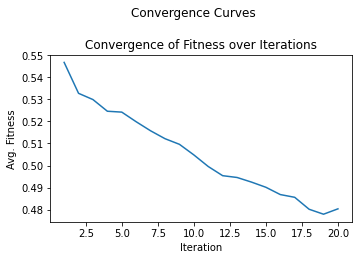

In [ ]:
from Py_FS.wrapper.nature_inspired.SCA import SCA as FS
solution = FS(num_agents=pop_size, max_iter=20, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
featr_index_woa

array([  0,   2,   3,   4,   5,   7,   8,  11,  12,  15,  21,  28,  30,
        36,  41,  42,  48,  50,  53,  54,  57,  58,  63,  68,  71,  72,
        74,  77,  80,  83,  86,  88, 110, 115, 116, 120, 123, 124, 126,
       139, 140, 141, 142, 144, 145, 148, 150, 151, 153, 158, 159, 160,
       161, 163, 168, 171, 183, 185, 187, 197, 207, 211, 212, 216, 227,
       229, 230, 231, 237, 239, 244, 247, 248, 255, 256, 261, 264, 266,
       267, 272, 282, 287, 292, 293, 294, 296, 298, 299, 300, 301, 308,
       310, 313, 326, 336, 340, 342, 343, 345, 348, 349, 352, 354, 355,
       357, 362, 364, 366, 370, 371, 374, 377, 378, 381, 383, 388, 389,
       390, 394, 395, 396, 397, 398, 402, 407, 410, 416, 417, 418, 421,
       422, 428, 432, 435, 437, 442, 445, 455, 461, 462, 464, 469, 474,
       478, 481, 484, 485, 490, 492, 494, 495, 497, 498, 501, 508])

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[500   1]
 [  0 498]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501
         1.0       1.00      1.00      1.00       498

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999
 

The accuracy on test dataset: 99.89990%


#PSO with ABHC

In [ ]:
! git clone https://github.com/consigliere19/Py-FS.git

Cloning into 'Py-FS'...
remote: Enumerating objects: 1411, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 1411 (delta 172), reused 168 (delta 168), pack-reused 1217
Receiving objects: 100% (1411/1411), 7.40 MiB | 17.86 MiB/s, done.
Resolving deltas: 100% (878/878), done.


In [ ]:
cd '/content/Py-FS/Py_FS/wrapper/nature_inspired'

/content/Py-FS/Py_FS/wrapper/nature_inspired


In [ ]:
def AdaptiveBetaHC(offspring, offspring_fitness, classifier, arr_train, arr_val):
  b_min=1
  b_max = 100
  iters = 5
  for value in range(iters):
    neighbor = offspring
    percent = 0.3
    upper = int(percent*offspring.shape[0])
    if upper<=1:
      upper = offspring.shape[0]
    x = random.randint(1,upper)
    pos = random.sample(range(0, offspring.shape[0]-1),x)
    for i in pos:
      neighbor[i] = 1-neighbor[i]
    beta = b_min + (value/iters)*(b_max-b_min)
    for i in range(offspring.shape[0]):
      random.seed(0)
      if random.random() <= beta:
        neighbor[i] = offspring[i]
    neighbor_fitness = eval_pop_fitness(np.asarray([neighbor]), classifier, arr_train, arr_val)
    if neighbor_fitness[0] > offspring_fitness:
      offspring = neighbor


  return offspring



def classifier_acc(val_pred, labels):
  count_list = np.where(val_pred==labels)
  acc = count_list[0].shape[0]/val_pred.shape[0]
  return acc


def eval_pop_fitness(initial_parents, classifier, arr_train, arr_val):
  accuracies = np.zeros(initial_parents.shape[0])
  id=0
  for sol in initial_parents:
    train_space, val_space = reduced_features(sol, arr_train, arr_val)
    if classifier == 'KNN':
      from sklearn.neighbors import KNeighborsClassifier
      model = KNeighborsClassifier(n_neighbors=5)
      model.fit(train_space[:,:-1], train_space[:,-1])
      val_pred = model.predict(val_space[:,:-1])
      accuracies[id] = classifier_acc(val_pred, val_space[:,-1])
      id +=1
  return accuracies


def reduced_features(sol, arr_train, arr_val):
  sol = np.append(sol,[1])
  indices = np.where(sol==1)[0]
  train_space = arr_train[:,indices]
  val_space = arr_val[:,indices]
  return train_space, val_space

In [ ]:
"""
Programmer: Ali Hussain Khan
Date of Development: 15/10/2020
This code has been developed according to the procedures mentioned in the following research article:
"Khanesar, M. A., Teshnehlab, M., & Shoorehdeli, M. A. (2007, June).
A novel binary particle swarm optimization.
In 2007 Mediterranean conference on control & automation (pp. 1-6). IEEE."
"""
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

from Py_FS.wrapper.nature_inspired._utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot
from Py_FS.wrapper.nature_inspired._transfer_functions import get_trans_function


def PSO(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, trans_func_shape='s', save_conv_graph=False):

    # Particle Swarm Optimizer
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of particles                                           #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################

    short_name = 'PSO'
    agent_name = 'Particle'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)

    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):
        weight_acc = float(input('Weight for the classification accuracy [0-1]: '))
    obj = (obj_function, weight_acc)
    compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

    # initialize particles and Leader (the agent with the max fitness)
    particles = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)

    # initialize data class
    data = Data()
    val_size = float(input('Enter the percentage of data wanted for valdiation [0, 100]: '))/100
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=val_size)
    data_train = np.concatenate((data.train_X,data.train_Y.reshape(-1,1)), axis=1)
    data_val = np.concatenate((data.val_X,data.val_Y.reshape(-1,1)), axis=1)

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial particles
    particles, fitness = sort_agents(particles, obj, data)

    # start timer
    start_time = time.time()

    # initialize global and local best particles
    globalBestParticle = [0 for i in range(num_features)]
    globalBestFitness = float("-inf")
    localBestParticle = [ [ 0 for i in range(num_features) ] for j in range(num_agents) ]
    localBestFitness = [float("-inf") for i in range(num_agents) ]
    weight = 1.0
    velocity = [ [ 0.0 for i in range(num_features) ] for j in range(num_agents) ]

    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')

        # update weight
        weight = 1.0 - (iter_no / max_iter)

        # update the velocity
        for i in range(num_agents):
            for j in range(num_features):
                velocity[i][j] = (weight*velocity[i][j])
                r1, r2 = np.random.random(2)
                velocity[i][j] = velocity[i][j] + (r1 * (localBestParticle[i][j] - particles[i][j]))
                velocity[i][j] = velocity[i][j] + (r2 * (globalBestParticle[j] - particles[i][j]))

        # updating position of particles
        for i in range(num_agents):
            for j in range(num_features):
                trans_value = trans_function(velocity[i][j])
                if (np.random.random() < trans_value):
                    particles[i][j] = 1
                else:
                    particles[i][j] = 0

        # updating fitness of particles
        particles, fitness = sort_agents(particles, obj, data)

        #ABHC
        for i in range(particles.shape[0]):
          off = particles[i]
          particles[i] = AdaptiveBetaHC(off, fitness[i], classifier, data_train, data_val)

        display(particles, fitness, agent_name)


        # updating the global best and local best particles
        for i in range(num_agents):
            if fitness[i]>localBestFitness[i]:
                localBestFitness[i]=fitness[i]
                localBestParticle[i]=particles[i][:]

            if fitness[i]>globalBestFitness:
                globalBestFitness=fitness[i]
                globalBestParticle=particles[i][:]

        # update Leader (best agent)
        if globalBestFitness > Leader_fitness:
            Leader_agent = globalBestParticle.copy()
            Leader_fitness = globalBestFitness.copy()

        convergence_curve['fitness'][iter_no] = np.mean(fitness)

    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    particles, accuracy = sort_agents(particles, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # plot convergence graph
    fig, axes = Conv_plot(convergence_curve)
    if(save_conv_graph):
        plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_particles = particles
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution


# if __name__ == '__main__':

#     data = datasets.load_digits()
#     PSO(20, 100, data.data, data.target, save_conv_graph=True)

In [ ]:
solution = PSO(num_agents=pop_size, max_iter=20, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)


                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.7848214285714286
Number of Features: 526
----------------------------------------

Whale 1 - Fitness: 0.7848214285714286, Number of Features: 526
Whale 2 - Fitness: 0.7745535714285714, Number of Features: 656
Whale 3 - Fitness: 0.7665178571428573, Number of Features: 718
Whale 4 - Fitness: 0.7348214285714285, Number of Features: 723
Whale 5 - Fitness: 0.7191964285714285, Number of Features: 764
Whale 6 - Fitness: 0.7174107142857145, Number of Features: 702
Whale 7 - Fitness: 0.7147321428571429, Number of Features: 768
Whale 8 - Fitness: 0.7125000000000001, Number of Features: 789
Whale 9 - Fitness: 0.6977678571428572, Number of Features: 768
Whale 10 - Fitness: 0.6901785714285715, Number of Features: 797
Whale 11 - Fitness: 0.6888392857142858, Number of Features: 814
Whale 12 - Fitness: 0.6848214285714286, Number of Features: 801
Whale 13 - Fitness: 0.6839285714285714, N

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
featr_index_woa

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[500   1]
 [  0 498]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501
         1.0       1.00      1.00      1.00       498

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999
 

The accuracy on test dataset: 99.89990%


#SCA with ABHC

In [ ]:
! git clone https://github.com/consigliere19/Py-FS.git

Cloning into 'Py-FS'...
remote: Enumerating objects: 1411, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 1411 (delta 172), reused 168 (delta 168), pack-reused 1217
Receiving objects: 100% (1411/1411), 7.40 MiB | 17.86 MiB/s, done.
Resolving deltas: 100% (878/878), done.


In [ ]:
cd '/content/Py-FS/Py_FS/wrapper/nature_inspired'

/content/Py-FS/Py_FS/wrapper/nature_inspired


In [ ]:
def AdaptiveBetaHC(offspring, offspring_fitness, classifier, arr_train, arr_val):
  b_min=1
  b_max = 100
  iters = 5
  for value in range(iters):
    neighbor = offspring
    percent = 0.3
    upper = int(percent*offspring.shape[0])
    if upper<=1:
      upper = offspring.shape[0]
    x = random.randint(1,upper)
    pos = random.sample(range(0, offspring.shape[0]-1),x)
    for i in pos:
      neighbor[i] = 1-neighbor[i]
    beta = b_min + (value/iters)*(b_max-b_min)
    for i in range(offspring.shape[0]):
      random.seed(0)
      if random.random() <= beta:
        neighbor[i] = offspring[i]
    neighbor_fitness = eval_pop_fitness(np.asarray([neighbor]), classifier, arr_train, arr_val)
    if neighbor_fitness[0] > offspring_fitness:
      offspring = neighbor


  return offspring



def classifier_acc(val_pred, labels):
  count_list = np.where(val_pred==labels)
  acc = count_list[0].shape[0]/val_pred.shape[0]
  return acc


def eval_pop_fitness(initial_parents, classifier, arr_train, arr_val):
  accuracies = np.zeros(initial_parents.shape[0])
  id=0
  for sol in initial_parents:
    train_space, val_space = reduced_features(sol, arr_train, arr_val)
    if classifier == 'KNN':
      from sklearn.neighbors import KNeighborsClassifier
      model = KNeighborsClassifier(n_neighbors=5)
      model.fit(train_space[:,:-1], train_space[:,-1])
      val_pred = model.predict(val_space[:,:-1])
      accuracies[id] = classifier_acc(val_pred, val_space[:,-1])
      id +=1
  return accuracies


def reduced_features(sol, arr_train, arr_val):
  sol = np.append(sol,[1])
  indices = np.where(sol==1)[0]
  train_space = arr_train[:,indices]
  val_space = arr_val[:,indices]
  return train_space, val_space

In [ ]:
"""
Programmer: Shameem Ahmed
Date of Development: 19/10/2020
This code has been developed according to the procedures mentioned in the following research article:
"Mirjalili, S. (2016). Sine Cosine Algorithm.
Knowledge Based Systems, 96, 120-133."
"""
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

from Py_FS.wrapper.nature_inspired._utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot
from Py_FS.wrapper.nature_inspired._transfer_functions import get_trans_function



def SCA(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, trans_func_shape='s', save_conv_graph=False):

    # Sine Cosine Algorithm
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of agents                                              #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################

    short_name = 'SCA'
    agent_name = 'Agent'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)

    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):
        weight_acc = float(input('Weight for the classification accuracy [0-1]: '))
    obj = (obj_function, weight_acc)
    compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

    # initialize agents and Leader (the agent with the max fitness)
    population = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)

    # initialize data class
    data = Data()
    val_size = float(input('Enter the percentage of data wanted for valdiation [0, 100]: '))/100
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=val_size)
    data_train = np.concatenate((data.train_X,data.train_Y.reshape(-1,1)), axis=1)
    data_val = np.concatenate((data.val_X,data.val_Y.reshape(-1,1)), axis=1)

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial population
    population, fitness = sort_agents(population, obj, data)
    Leader_agent = population[0].copy()
    Leader_fitness = fitness[0].copy()

    # start timer
    start_time = time.time()

    # Eq. (3.4)
    a = 3

    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')

        # Eq. (3.4)
        r1 = a-iter_no*((a)/max_iter)  # r1 decreases linearly from a to 0

        # update the Position of search agents
        for i in range(num_agents):
            for j in range(num_features):

                # update r2, r3, and r4 for Eq. (3.3)
                r2 = (2 * np.pi) * np.random.random()
                r3 = 2 * np.random.random()
                r4 = np.random.random()

                # Eq. (3.3)
                if r4 < 0.5:
                    # Eq. (3.1)
                    population[i, j] = population[i, j] + \
                        (r1*np.sin(r2)*abs(r3*Leader_agent[j]-population[i, j]))
                else:
                    # Eq. (3.2)
                    population[i, j] = population[i, j] + \
                        (r1*np.cos(r2)*abs(r3*Leader_agent[j]-population[i, j]))

                temp = population[i, j].copy()
                temp = trans_function(temp)
                if temp > np.random.random():
                    population[i, j] = 1
                else:
                    population[i, j] = 0


        # update final information
        population, fitness = sort_agents(population, obj, data)

        #ABHC
        for i in range(population.shape[0]):
          off = population[i]
          population[i] = AdaptiveBetaHC(off, fitness[i], classifier, data_train, data_val)

        display(population, fitness)

        if fitness[0] > Leader_fitness:
            Leader_agent = population[0].copy()
            Leader_fitness = fitness[0].copy()


        convergence_curve['fitness'][iter_no] = np.mean(fitness)

    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    population, accuracy = sort_agents(population, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # plot convergence graph
    fig, axes = Conv_plot(convergence_curve)
    if(save_conv_graph):
        plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_particles = population
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution


if __name__ == '__main__':

    data = datasets.load_digits()
    SCA(20, 100, data.data, data.target, save_conv_graph=True)

In [ ]:
solution = SCA(num_agents=pop_size, max_iter=20, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)


                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.7848214285714286
Number of Features: 526
----------------------------------------

Whale 1 - Fitness: 0.7848214285714286, Number of Features: 526
Whale 2 - Fitness: 0.7745535714285714, Number of Features: 656
Whale 3 - Fitness: 0.7665178571428573, Number of Features: 718
Whale 4 - Fitness: 0.7348214285714285, Number of Features: 723
Whale 5 - Fitness: 0.7191964285714285, Number of Features: 764
Whale 6 - Fitness: 0.7174107142857145, Number of Features: 702
Whale 7 - Fitness: 0.7147321428571429, Number of Features: 768
Whale 8 - Fitness: 0.7125000000000001, Number of Features: 789
Whale 9 - Fitness: 0.6977678571428572, Number of Features: 768
Whale 10 - Fitness: 0.6901785714285715, Number of Features: 797
Whale 11 - Fitness: 0.6888392857142858, Number of Features: 814
Whale 12 - Fitness: 0.6848214285714286, Number of Features: 801
Whale 13 - Fitness: 0.6839285714285714, N

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
featr_index_woa

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[500   1]
 [  0 498]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501
         1.0       1.00      1.00      1.00       498

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999
 

The accuracy on test dataset: 99.89990%


In [ ]:
#Genetic Algorithm

df_train = pd.concat([df_1,df_2], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_3)

pop_size = 50
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

2304


In [ ]:
! git clone https://github.com/consigliere19/Py-FS.git

Cloning into 'Py-FS'...
remote: Enumerating objects: 1411, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 1411 (delta 172), reused 168 (delta 168), pack-reused 1217
Receiving objects: 100% (1411/1411), 7.40 MiB | 17.86 MiB/s, done.
Resolving deltas: 100% (878/878), done.


In [ ]:
cd '/content/Py-FS/Py_FS/wrapper/nature_inspired'

/content/Py-FS/Py_FS/wrapper/nature_inspired


In [ ]:
def AdaptiveBetaHC(offspring, offspring_fitness, classifier, arr_train, arr_val):
  b_min=1
  b_max = 100
  iters = 5
  for value in range(iters):
    neighbor = offspring
    percent = 0.3
    upper = int(percent*offspring.shape[0])
    if upper<=1:
      upper = offspring.shape[0]
    x = random.randint(1,upper)
    pos = random.sample(range(0, offspring.shape[0]-1),x)
    for i in pos:
      neighbor[i] = 1-neighbor[i]
    beta = b_min + (value/iters)*(b_max-b_min)
    for i in range(offspring.shape[0]):
      random.seed(0)
      if random.random() <= beta:
        neighbor[i] = offspring[i]
    neighbor_fitness = eval_pop_fitness(np.asarray([neighbor]), classifier, arr_train, arr_val)
    if neighbor_fitness[0] > offspring_fitness:
      offspring = neighbor


  return offspring



def classifier_acc(val_pred, labels):
  count_list = np.where(val_pred==labels)
  acc = count_list[0].shape[0]/val_pred.shape[0]
  return acc


def eval_pop_fitness(initial_parents, classifier, arr_train, arr_val):
  accuracies = np.zeros(initial_parents.shape[0])
  id=0
  for sol in initial_parents:
    train_space, val_space = reduced_features(sol, arr_train, arr_val)
    if classifier == 'KNN':
      from sklearn.neighbors import KNeighborsClassifier
      model = KNeighborsClassifier(n_neighbors=5)
      model.fit(train_space[:,:-1], train_space[:,-1])
      val_pred = model.predict(val_space[:,:-1])
      accuracies[id] = classifier_acc(val_pred, val_space[:,-1])
      id +=1
  return accuracies


def reduced_features(sol, arr_train, arr_val):
  sol = np.append(sol,[1])
  indices = np.where(sol==1)[0]
  train_space = arr_train[:,indices]
  val_space = arr_val[:,indices]
  return train_space, val_space

In [ ]:
#WOA

"""

Programmer: Ritam Guha
Date of Development: 8/10/2020
This code has been developed according to the procedures mentioned in the following research article:
"Mafarja, M., & Mirjalili, S. (2018). Whale optimization approaches for wrapper feature selection.
Applied Soft Computing, 62, 441-453."

"""

import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

from Py_FS.wrapper.nature_inspired._utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot
from Py_FS.wrapper.nature_inspired._transfer_functions import get_trans_function


def WOA(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, trans_function_shape='s', save_conv_graph=False):

    # Whale Optimization Algorithm
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of whales                                              #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################

    short_name = 'WOA'
    agent_name = 'Whale'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    cross_limit = 5
    trans_function = get_trans_function(trans_function_shape)

    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):
        weight_acc = float(input('Weight for the classification accuracy [0-1]: '))
    obj = (obj_function, weight_acc)
    compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

    # initialize whales and Leader (the agent with the max fitness)
    whales = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)

    # format the data
    data = Data()
    val_size = float(input('Enter the percentage of data wanted for valdiation [0, 100]: '))/100
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=val_size)
    data_train = np.concatenate((data.train_X,data.train_Y.reshape(-1,1)), axis=1)
    data_val = np.concatenate((data.val_X,data.val_Y.reshape(-1,1)), axis=1)

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial population
    whales, fitness = sort_agents(whales, obj, data)

    # start timer
    start_time = time.time()

    # main loop
    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')

        a = 2 - iter_no * (2/max_iter)  # a decreases linearly fron 2 to 0
        # update the position of each whale
        for i in range(num_agents):
            # update the parameters
            r = np.random.random() # r is a random number in [0, 1]
            A = (2 * a * r) - a  # Eq. (3)
            C = 2 * r  # Eq. (4)
            l = -1 + (np.random.random() * 2)   # l is a random number in [-1, 1]
            p = np.random.random()  # p is a random number in [0, 1]
            b = 1  # defines shape of the spiral

            if p<0.5:
                # Shrinking Encircling mechanism
                if abs(A)>=1:
                    rand_agent_index = np.random.randint(0, num_agents)
                    rand_agent = whales[rand_agent_index, :]
                    mod_dist_rand_agent = abs(C * rand_agent - whales[i,:])
                    whales[i,:] = rand_agent - (A * mod_dist_rand_agent)   # Eq. (9)

                else:
                    mod_dist_Leader = abs(C * Leader_agent - whales[i,:])
                    whales[i,:] = Leader_agent - (A * mod_dist_Leader)  # Eq. (2)

            else:
                # Spiral-Shaped Attack mechanism
                dist_Leader = abs(Leader_agent - whales[i,:])
                whales[i,:] = dist_Leader * np.exp(b * l) * np.cos(l * 2 * np.pi) + Leader_agent

            # Apply transformation function on the updated whale
            for j in range(num_features):
                trans_value = trans_function(whales[i,j])
                if (np.random.random() < trans_value):
                    whales[i,j] = 1
                else:
                    whales[i,j] = 0


        # update final information
        whales, fitness = sort_agents(whales, obj, data)

        #ABHC
        for i in range(whales.shape[0]):
          off = whales[i]
          whales[i] = AdaptiveBetaHC(off, fitness[i], classifier, data_train, data_val)

        display(whales, fitness, agent_name)
        if fitness[0]>Leader_fitness:
            Leader_agent = whales[0].copy()
            Leader_fitness = fitness[0].copy()

        convergence_curve['fitness'][iter_no] = np.mean(fitness)

        # convergence_curve['fitness'][iter_no] = np.mean(fitness)
        # convergence_curve['feature_count'][iter_no] = np.mean(np.sum(whales,axis=1))

    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    whales, accuracy = sort_agents(whales, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # plot convergence graph
    fig, axes = Conv_plot(convergence_curve)
    if(save_conv_graph):
        plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_population = whales
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution





# ############# for testing purpose ################

# if __name__ == '__main__':
#     data = datasets.load_digits()
#     WOA(20, 100, data.data, data.target, save_conv_graph=True)
# ############# for testing purpose ################


In [ ]:
solution = WOA(num_agents=pop_size, max_iter=20, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)


                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.7848214285714286
Number of Features: 526
----------------------------------------

Whale 1 - Fitness: 0.7848214285714286, Number of Features: 526
Whale 2 - Fitness: 0.7745535714285714, Number of Features: 656
Whale 3 - Fitness: 0.7665178571428573, Number of Features: 718
Whale 4 - Fitness: 0.7348214285714285, Number of Features: 723
Whale 5 - Fitness: 0.7191964285714285, Number of Features: 764
Whale 6 - Fitness: 0.7174107142857145, Number of Features: 702
Whale 7 - Fitness: 0.7147321428571429, Number of Features: 768
Whale 8 - Fitness: 0.7125000000000001, Number of Features: 789
Whale 9 - Fitness: 0.6977678571428572, Number of Features: 768
Whale 10 - Fitness: 0.6901785714285715, Number of Features: 797
Whale 11 - Fitness: 0.6888392857142858, Number of Features: 814
Whale 12 - Fitness: 0.6848214285714286, Number of Features: 801
Whale 13 - Fitness: 0.6839285714285714, N

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
featr_index_woa

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=7, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[500   1]
 [  0 498]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501
         1.0       1.00      1.00      1.00       498

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999
 

The accuracy on test dataset: 99.89990%


In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_train_val[:,:-1], arr_train_val[:,-1])
test_pred = model.predict(arr_test[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

In [ ]:
df_train

0         1         2         3         4         5         6  \
664   0.135846  0.308309  0.458632  0.281488  0.059493 -0.086680 -0.072981   
6019 -0.036512 -0.099275 -0.087520 -0.189154 -0.036129  0.190041 -0.146409   
6722  0.017380  0.582058  0.571722  0.469715  0.705962 -0.144659  0.352568   
4289 -0.027419 -0.104199 -0.073598 -0.197360 -0.089578 -0.028483 -0.074258   
5624  0.145087  0.737927  0.780412  0.555325  0.895632  0.218866  0.625550   
...        ...       ...       ...       ...       ...       ...       ...   
869   0.068717 -0.095214 -0.055665 -0.179316 -0.086304  0.292581 -0.178256   
1280 -0.091411 -0.135720 -0.083241 -0.213363 -0.106040 -0.013884 -0.003958   
824   0.128843  0.954476  0.657425  0.517553  0.488640  0.156419  0.450036   
771  -0.032576 -0.050549 -0.101205 -0.208361 -0.108617  0.021094 -0.152125   
916   0.252266  1.401501  1.032668  1.129246  1.749848 -0.076224  1.047472   

             7         8         9  ...       503       504       505  \
664   0.306675 -0.036374 -0.115928  ...  0.459065  0.746834  2.440104   
6019 -0.179987  0.229279  0.014669  ...  0.555188  1.094902  0.614072   
6722  0.377726 -0.100270 -0.142220  ...  0.611611  1.200984  0.601575   
4289 -0.177857  0.395606  0.132314  ...  0.544759  1.005979  0.593789   
5624  0.798644 -0.069992 -0.145546  ...  0.534845  0.960318  0.636163   
...        ...       ...       ...  ...       ...       ...       ...   
869  -0.160884  0.465832  0.212862  ...  0.415305  0.735901  2.398322   
1280 -0.176135  0.470467  0.449224  ...  0.565660  1.028059  0.625089   
824   0.685170  0.041910 -0.128537  ...  0.408301  0.740631  2.813132   
771  -0.196362  0.533534  0.110331  ...  0.491924  0.861886  2.207248   
916   1.524579 -0.160075 -0.159001  ...  0.629023  1.053347  0.782800   

           506       507       508       509       510       511  512  
664   0.055425  0.648958  0.429656  0.329437  3.790567  0.190658  0.0  
6019  1.123768  1.242171  0.487262  1.151884  0.705182  1.142354  1.0  
6722  1.262433  1.191765  0.537026  1.122120  0.702473  1.111818  1.0  
4289  1.060183  1.259170  0.488086  1.047607  0.695854  0.966405  1.0  
5624  0.930598  1.108475  0.488445  0.972583  0.610461  1.041893  1.0  
...        ...       ...       ...       ...       ...       ...  ...  
869   0.144451  0.647650  0.578440  0.323276  3.128090  0.281169  0.0  
1280  1.055130  1.149892  0.396589  1.095724  0.571753  1.043567  1.0  
824   0.109390  0.487323  0.479151  0.215070  3.544840  0.139942  0.0  
771   0.076883  0.627622  0.387666  0.249885  3.325951  0.120817  0.0  
916   1.231331  1.165180  0.486952  1.026456  0.783542  1.009958  1.0  

[9018 rows x 2305 columns]

In [ ]:
df2

0         1         2         3         4         5         6  \
0    -0.101488  0.464454  0.008453 -0.075608 -0.007687 -0.130211  0.218230   
1    -0.114727 -0.149854  0.014510  0.804767 -0.144650 -0.092144 -0.232939   
2    -0.071902  0.151726  0.519848  0.152724 -0.014382 -0.108470  0.018763   
3     1.128637  0.298912 -0.115428 -0.135238  0.187530  0.416558  0.174888   
4    -0.074799  0.195286 -0.070735  0.067097 -0.088860 -0.150430  0.331967   
...        ...       ...       ...       ...       ...       ...       ...   
1136  0.268489 -0.035582  0.106025 -0.154831  0.847037  0.035058 -0.082552   
1137 -0.083800  0.168150  0.100975  0.110553 -0.075280 -0.138634  0.124461   
1138 -0.115248 -0.154808 -0.063980  0.709354 -0.141723 -0.095787 -0.227400   
1139 -0.089508  0.048113  1.005846  0.205739 -0.084067 -0.167864  0.083931   
1140 -0.146146 -0.140388 -0.035846  1.066098  0.092544 -0.079348 -0.220251   

             7         8         9  ...      1783      1784      1785  \
0     0.561062 -0.100065 -0.012133  ... -0.006253 -0.084748  0.404487   
1    -0.185447 -0.066493 -0.172505  ... -0.017171 -0.080284 -0.205832   
2     0.279061 -0.087522  0.428845  ...  0.054444 -0.063029  0.115047   
3    -0.127589  0.547701  0.006816  ... -0.134569  0.712865 -0.132954   
4     0.865280 -0.113924  0.098196  ...  0.060362 -0.073375  0.216143   
...        ...       ...       ...  ...       ...       ...       ...   
1136 -0.060716  0.983054 -0.117920  ... -0.137774  0.254270  0.043767   
1137  0.332456 -0.118246  0.309593  ...  0.196535 -0.108055  0.196956   
1138 -0.039556 -0.145376 -0.115751  ...  0.097502 -0.110381 -0.212836   
1139 -0.001351 -0.108312  0.134926  ...  0.084496 -0.101817  0.166306   
1140 -0.076751 -0.084303 -0.169237  ...  0.283622 -0.064280 -0.180654   

          1786      1787      1788      1789      1790      1791  1792  
0     0.512572 -0.021363  0.045272  0.595862 -0.078887  0.154617   2.0  
1    -0.183062 -0.180271 -0.232557 -0.177891 -0.153601 -0.180145   1.0  
2     0.884046 -0.048302 -0.062142  0.667193 -0.148396  0.313139   2.0  
3    -0.091737  0.519595  0.149149 -0.130807  0.537424  0.212648   0.0  
4     0.122132 -0.071466  0.145962  0.294979 -0.123082  0.137498   2.0  
...        ...       ...       ...       ...       ...       ...   ...  
1136 -0.068018  0.171503  0.425086 -0.155719 -0.025966  0.631614   0.0  
1137  0.443517 -0.043318 -0.055292  0.310220 -0.163115 -0.043239   2.0  
1138 -0.093363 -0.147210 -0.216523 -0.209795 -0.198448 -0.160063   1.0  
1139  0.841139 -0.084130 -0.177719  0.848041 -0.183048 -0.107409   2.0  
1140 -0.111658 -0.181068 -0.231263 -0.122807 -0.176006 -0.195425   1.0  

[1141 rows x 1793 columns]

In [ ]:
df_dense_tr[:,:2]

SyntaxError: ignored

In [ ]:
df_tr.shape

(718, 4865)

In [ ]:
arr_tr = np.asarray(df_tr)
arr_val = np.asarray(df_val)

In [ ]:
df_dense_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Densenet121_IBLoss.csv').drop(columns=['1024'])
df_eff_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Effnet.csv').drop(columns=['1792'])
df_res_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Resnet.csv')
df_res_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Resnet.csv')
df_res_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Resnet.csv')

In [ ]:
df_3

0         1         2         3         4         5         6  \
169  0.015765  0.007090  0.011807  0.015772  0.184959  0.243341  0.015442   
369  0.015516  0.015688  0.018914  0.012277  0.180502  0.481212  0.015661   
286  0.015626  0.015600  0.013872  0.014223  0.239424  0.270817  0.015549   
24   0.015366  0.012251  0.014662  0.019018 -0.025445  0.426380  0.015297   
290  0.016074  0.000203  0.010417  0.014516  0.146716  0.480064  0.015812   
..        ...       ...       ...       ...       ...       ...       ...   
141  0.015574  0.014622  0.016885  0.015508  0.035762  0.174118  0.014976   
376  0.015744  0.017517  0.009755  0.013639  0.457127 -0.166836  0.015369   
240  0.015666  0.013272  0.019110  0.013870  0.095015  0.403838  0.015492   
192  0.015766  0.012659  0.010823  0.013884  0.452446  0.269783  0.016043   
67   0.015423  0.012704  0.016154  0.016684 -0.114352  0.700603  0.014820   

            7         8         9  ...      2039      2040      2041  \
169  0.012467  0.339215  0.010269  ...  1.191175  0.588488  0.274036   
369  0.012532  0.558079  0.009717  ...  1.123141  0.688131  0.221780   
286  0.012563  0.389315  0.009722  ...  0.585860  0.525896  0.173776   
24   0.016487  0.749401  0.009730  ...  0.505433  1.121404  0.035391   
290  0.013442  0.811234  0.010703  ...  0.116094  1.497899  0.390502   
..        ...       ...       ...  ...       ...       ...       ...   
141  0.015792  0.201523  0.009374  ...  1.073153  0.279137  0.288499   
376  0.012343  0.701263  0.010481  ...  0.191427  1.234528  0.187083   
240  0.011699  0.719921  0.009692  ...  1.250578  0.469827  0.188422   
192  0.009869  0.684829  0.010346  ...  0.329707  0.963555  0.281196   
67   0.010555  0.408764  0.009712  ...  0.559147  0.441182  0.425068   

         2042      2043      2044      2045      2046      2047  2048  
169  0.383231  0.157043  0.434142  0.308920  0.624451  0.879569   0.0  
369  0.078029  0.201200  0.907105  0.272181  0.839140  0.675909   1.0  
286  0.631580  0.086189  0.724429  0.263994  0.497289  1.370316   0.0  
24   0.099757  0.095492  0.554123  0.202504  0.438950  0.529516   0.0  
290  0.000000  0.066229  1.080633  0.414044  0.911117  1.273459   0.0  
..        ...       ...       ...       ...       ...       ...   ...  
141  0.493567  0.112300  0.265958  0.233387  0.534162  1.166416   0.0  
376  0.007483  0.003643  1.337006  0.366070  1.137470  1.758658   1.0  
240  0.495992  0.065241  0.785214  0.359356  0.798242  1.089568   0.0  
192  0.018033  0.117544  0.776315  0.490931  0.960872  1.388672   0.0  
67   0.469217  0.532325  0.982317  0.474529  0.383115  0.723532   0.0  

[378 rows x 4865 columns]

In [ ]:
df_1 = pd.concat([df_dense_tr,df_eff_tr,df_res_tr], axis=1)
df_1 = df_1.fillna(0)
df_2 = pd.concat([df_dense_val,df_eff_val,df_res_val], axis=1)
df_2 = df_2.fillna(0)
df_3 = pd.concat([df_dense_test,df_eff_test,df_res_test], axis=1)
df_3 = df_3.fillna(0)
df_1 = sklearn.utils.shuffle(df_1)
df_2 = sklearn.utils.shuffle(df_2)
df_3 = sklearn.utils.shuffle(df_3)

In [ ]:
#Genetic Algorithm

df_train = pd.concat([df_1,df_2], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_3)

pop_size = 50
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

4864


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=6, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_train_val[:,:-1], arr_train_val[:,-1])
test_pred = model.predict(arr_test[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[500   2]
 [  0 497]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       502
         1.0       1.00      1.00      1.00       497

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999
 

The accuracy on test dataset: 99.79980%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_train_val[:,:-1], arr_train_val[:,-1])
test_pred = model.predict(arr_test[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[497   6]
 [  3 493]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       503
         1.0       0.99      0.99      0.99       496

    accuracy                           0.99       999
   macro avg       0.99      0.99      0.99       999
weighted avg       0.99      0.99      0.99       999
 

The accuracy on test dataset: 99.09910%



#Maximum accuracy achieved with Resnet Classification without GA

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_train_val[:,:-1], arr_train_val[:,-1])
test_pred = model.predict(arr_test[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[500   1]
 [  0 498]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501
         1.0       1.00      1.00      1.00       498

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999
 

The accuracy on test dataset: 99.89990%


Streaming output truncated to the last 5000 lines.
Chromosome 75 - Fitness: 0.5383928571428571, Number of Features: 1034
Chromosome 76 - Fitness: 0.5370535714285715, Number of Features: 1037
Chromosome 77 - Fitness: 0.5303571428571429, Number of Features: 1052
Chromosome 78 - Fitness: 0.5299107142857142, Number of Features: 1053
Chromosome 79 - Fitness: 0.525, Number of Features: 1064
Chromosome 80 - Fitness: 0.525, Number of Features: 1064


                          Iteration - 8

Crossover-Mutation phase starting....

Crossover no. 1
child 1 replaced with chromosome having id 60
child 2 replaced with chromosome having id 64

Crossover no. 2
child 1 replaced with chromosome having id 48
child 2 replaced with chromosome having id 55

Crossover no. 3
child 1 replaced with chromosome having id 50
child 2 replaced with chromosome having id 55

Crossover no. 4
child 1 replaced with chromosome having id 61
child 2 replaced with chromosome having id 62

Crossover no. 5
child 1 replaced with

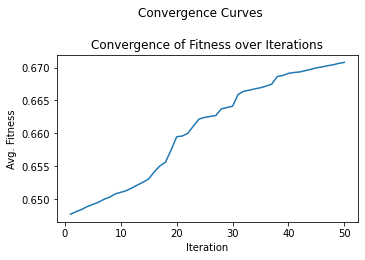

In [ ]:
from Py_FS.wrapper.nature_inspired.GA import GA as FS
solution = FS(num_agents=pop_size, max_iter=50, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

Weight for the classification accuracy [0-1]: 0.2
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.7742343403547671
Number of Features: 143
----------------------------------------

Whale 1 - Fitness: 0.7742343403547671, Number of Features: 143
Whale 2 - Fitness: 0.7638511640798227, Number of Features: 150
Whale 3 - Fitness: 0.7294761640798226, Number of Features: 172
Whale 4 - Fitness: 0.7063712583148559, Number of Features: 187
Whale 5 - Fitness: 0.7015728935698449, Number of Features: 190
Whale 6 - Fitness: 0.6954337583148559, Number of Features: 194
Whale 7 - Fitness: 0.6918652993348116, Number of Features: 196
Whale 8 - Fitness: 0.6889620288248337, Number of Features: 198
Whale 9 - Fitness: 0.6853935698447894, Number of Features: 200
Whale 10 - Fitness: 0.6852827050997783, Number of Features: 200
Whale 11 - Fitness: 0.6826011640798226, Number of Featu

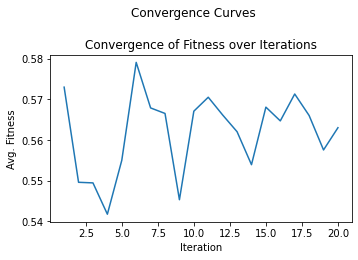

In [ ]:
from Py_FS.wrapper.nature_inspired.WOA import WOA as FS
solution = FS(num_agents=pop_size, max_iter=20, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

Weight for the classification accuracy [0-1]: 0.2
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.9043652993348116
Number of Features: 60
----------------------------------------

RedDeer 1 - Fitness: 0.9043652993348116, Number of Features: 60
RedDeer 2 - Fitness: 0.9043652993348116, Number of Features: 60
RedDeer 3 - Fitness: 0.9043652993348116, Number of Features: 60
RedDeer 4 - Fitness: 0.7255751108647451, Number of Features: 174
RedDeer 5 - Fitness: 0.7255751108647451, Number of Features: 174
RedDeer 6 - Fitness: 0.7122886640798226, Number of Features: 183
RedDeer 7 - Fitness: 0.7014620288248338, Number of Features: 190
RedDeer 8 - Fitness: 0.7012402993348116, Number of Features: 190
RedDeer 9 - Fitness: 0.7012402993348116, Number of Features: 190
RedDeer 10 - Fitness: 0.7012402993348116, Number of Features: 190
RedDeer 11 - Fitness: 0.701240299334811

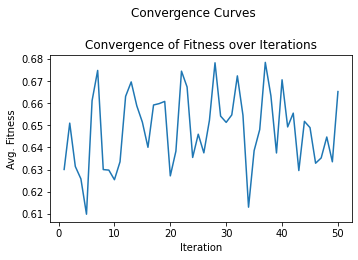

In [ ]:
from Py_FS.wrapper.nature_inspired.RDA import RDA as FS
solution = FS(num_agents=pop_size, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
featr_index_woa

array([   0,    2,    8,    9,   10,   11,   12,   14,   18,   23,   24,
         25,   36,   37,   38,   41,   54,   55,   59,   61,   73,   76,
         81,   84,   94,   95,   97,  101,  103,  104,  106,  109,  110,
        111,  113,  115,  116,  117,  124,  129,  130,  135,  142,  146,
        149,  155,  157,  167,  169,  170,  171,  174,  175,  179,  180,
        181,  182,  183,  187,  192,  198,  201,  208,  209,  211,  214,
        216,  217,  221,  223,  225,  227,  232,  236,  237,  239,  241,
        243,  244,  246,  249,  260,  261,  266,  268,  269,  276,  277,
        282,  285,  291,  293,  296,  298,  300,  305,  306,  316,  319,
        327,  329,  333,  334,  336,  338,  341,  349,  351,  355,  357,
        361,  362,  363,  366,  367,  368,  371,  382,  385,  386,  388,
        393,  394,  395,  396,  402,  403,  405,  409,  410,  411,  415,
        416,  417,  420,  423,  424,  426,  429,  430,  433,  435,  438,
        443,  444,  445,  447,  448,  452,  455,  4

In [ ]:
df = pd.DataFrame(featr_index_woa,columns=['0'])
df.to_csv('/content/drive/MyDrive/Lung_Carcinoma/data_folder_1/featr_index_rda')

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=5, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[ 499    0    0    0    0]
 [   0  500    0    0    0]
 [   0    0 1000    0    1]
 [   0    0    0 1000    0]
 [   0    0    0    0  999]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       499
         1.0       1.00      1.00      1.00       500
         2.0       1.00      1.00      1.00      1001
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00       999

    accuracy                           1.00      3999
   macro avg       1.00      1.00      1.00      3999
weighted avg       1.00      1.00      1.00      3999
 

The accuracy on test dataset: 99.97499%


In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_train_val[:,:-1], arr_train_val[:,-1])
test_pred = model.predict(arr_test[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[ 499    0    0    0    0]
 [   0  500    0    0    0]
 [   0    0 1000    0    1]
 [   0    0    0 1000    0]
 [   0    0    0    0  999]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       499
         1.0       1.00      1.00      1.00       500
         2.0       1.00      1.00      1.00      1001
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00       999

    accuracy                           1.00      3999
   macro avg       1.00      1.00      1.00      3999
weighted avg       1.00      1.00      1.00      3999
 

The accuracy on test dataset: 99.97499%


In [ ]:
from Py_FS.filter import PCC
obj = PCC(arr_train_val[:,:-1],arr_train_val[:,-1])

In [ ]:
 print(obj.ranks)

[2364 3340 3497 ... 4761 3257 2444]


In [ ]:
featr_rank = obj.ranks

In [ ]:
featr_index = np.where(featr_rank<0.6*len(featr_rank))[0]
len(featr_index)

2919

In [ ]:
df = pd.DataFrame(featr_index)
df.to_csv('featr_index_PCC_1.csv')

In [ ]:
arr_tr_new = arr_tr[:,featr_index]
arr_val_new = arr_val[:,featr_index]
arr_tr_new.shape

(718, 3892)

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_tr[:,-1])
test_pred = model.predict(arr_val_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_val[:,-1]),classification_report(test_pred, arr_val[:,-1])))
acc = accuracy_score(test_pred, arr_val[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[143  28]
 [  3   6]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.84      0.90       171
         1.0       0.18      0.67      0.28         9

    accuracy                           0.83       180
   macro avg       0.58      0.75      0.59       180
weighted avg       0.94      0.83      0.87       180
 

The accuracy on test dataset: 82.77778%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=7)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr[:,:-1], arr_tr[:,-1])
test_pred = model.predict(arr_val[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_val[:,-1]),classification_report(test_pred, arr_val[:,-1])))
acc = accuracy_score(test_pred, arr_val[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[144  28]
 [  2   6]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.84      0.91       172
         1.0       0.18      0.75      0.29         8

    accuracy                           0.83       180
   macro avg       0.58      0.79      0.60       180
weighted avg       0.95      0.83      0.88       180
 

The accuracy on test dataset: 83.33333%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_tr[:,-1])
test_pred = model.predict(arr_val_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_val[:,-1]),classification_report(test_pred, arr_val[:,-1])))
acc = accuracy_score(test_pred, arr_val[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[139  23]
 [  7  11]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       162
         1.0       0.32      0.61      0.42        18

    accuracy                           0.83       180
   macro avg       0.64      0.73      0.66       180
weighted avg       0.89      0.83      0.85       180
 

The accuracy on test dataset: 83.33333%


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Effnet.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Effnet.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Effnet.csv')

In [ ]:
# from PIL import Image
# image = Image.open('/content/drive/MyDrive/HAM10000/HAM10000/test/akiec/ISIC_0025264.jpg')
# img = val_transform(image)
# plt.imshow(img.permute(1,2,0))

In [ ]:
#img_tesnor = train_transform(image)
# plt.imshow(img_tesnor.permute(1,2,0))

In [ ]:
df_dense_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Densenet_121.csv').drop(columns=['1024'])
df_eff_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Effnet.csv').drop(columns=['1792'])
df_convnet_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_ConvNext_IBLoss.csv').drop(columns=['2048'])
df_convnet_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_ConvNext_IBLoss.csv').drop(columns=['2048'])
df_convnet_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_ConvNext_IBLoss.csv').drop(columns=['2048'])
df_gnet_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_GoogLeNet.csv').drop(columns=['1024'])
df_gnet_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_GoogLeNet.csv').drop(columns=['1024'])
df_gnet_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_GoogLeNet.csv').drop(columns=['1024'])
df_res_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Resnet.csv')
df_res_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Resnet.csv')
df_res_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Resnet.csv')

In [ ]:
df_1 = pd.concat([df_dense_tr,df_eff_tr,df_convnet_tr,df_gnet_tr,df_res_tr], axis=1)
df_1 = df_1.fillna(0)
df_2 = pd.concat([df_dense_val,df_eff_val,df_convnet_val,df_gnet_val,df_res_val], axis=1)
df_2 = df_2.fillna(0)
df_3 = pd.concat([df_dense_test,df_eff_test,df_convnet_test,df_gnet_test,df_res_test], axis=1)
df_3 = df_3.fillna(0)
df_1 = sklearn.utils.shuffle(df_1)
df_2 = sklearn.utils.shuffle(df_2)
df_3 = sklearn.utils.shuffle(df_3)

In [ ]:
#Genetic Algorithm

df_train = pd.concat([df_1,df_2], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_3)

pop_size = 50
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

7936


In [ ]:
# split dataset

train_idx = np.random.permutation(range(num_samples))
arr_train = arr_train_val[train_idx[:int(.8*num_samples)],:]
arr_val = arr_train_val[train_idx[int(.8*num_samples):],:]


In [ ]:
def reduced_features(sol, arr_train, arr_val):
  sol = np.append(sol,[1])
  indices = np.where(sol==1)[0]
  train_space = arr_train[:,indices]
  val_space = arr_val[:,indices]
  return train_space, val_space


def classifier_acc(val_pred, labels):
  count_list = np.where(val_pred==labels)
  acc = count_list[0].shape[0]/val_pred.shape[0]
  return acc


def eval_pop_fitness(initial_parents, classifier, arr_train, arr_val):
  accuracies = np.zeros(initial_parents.shape[0])
  id=0
  for sol in initial_parents:
    train_space, val_space = reduced_features(sol, arr_train, arr_val)
    if classifier == 'KNN':
      from sklearn.neighbors import KNeighborsClassifier
      model = KNeighborsClassifier(n_neighbors=5)
      model.fit(train_space[:,:-1], train_space[:,-1])
      val_pred = model.predict(val_space[:,:-1])
      accuracies[id] = classifier_acc(val_pred, val_space[:,-1])
      id +=1

    if classifier == 'RFC':
      from sklearn.ensemble import RandomForestClassifier
      model = RandomForestClassifier(max_depth=2, random_state=0)
      model.fit(train_space[:,:-1], train_space[:,-1])
      val_pred = model.predict(val_space[:,:-1])
      accuracies[id] = classifier_acc(val_pred, val_space[:,-1])
      id +=1
  return accuracies


def select_mating_pool(initial_parents, fitness, pop_for_mating):
  parents = np.zeros((pop_for_mating, initial_parents.shape[1]))
  for n in range(pop_for_mating):
    max_fitness_id = np.where(fitness == np.max(fitness))[0]
    max_fitness_id = max_fitness_id[0]
    parents[n,:] = initial_parents[max_fitness_id,:]
    fitness[max_fitness_id] = -99999999999
  return parents


def crossing_over(parents, offspring_size):
  crossed_offsprings = np.empty(offspring_size)
  crossover_point = np.uint8(offspring_size[1]/2)
  for n in range(offspring_size[0]):
    parent1_id = n%parents.shape[0]
    parent2_id = (n+1)%parents.shape[0]
    crossed_offsprings[n,:crossover_point] = parents[parent1_id, :crossover_point]
    crossed_offsprings[n,crossover_point:] = parents[parent2_id, crossover_point:]
  return crossed_offsprings


def mutation(crossed_offsprings, num_mutations):
  mutation_id = np.random.randint(low=0, high=crossed_offsprings.shape[1],size=num_mutations)
  for n in range(crossed_offsprings.shape[0]):
    crossed_offsprings[n,mutation_id] = 1-crossed_offsprings[n,mutation_id]
  return crossed_offsprings

Generation: 1
Best result:  1.0
Generation: 2
Best result:  1.0
Generation: 3
Best result:  1.0
Generation: 4
Best result:  1.0
Generation: 5
Best result:  1.0
Generation: 6
Best result:  1.0
Generation: 7
Best result:  1.0
Generation: 8
Best result:  1.0
Generation: 9
Best result:  1.0
Generation: 10
Best result:  1.0
Generation: 11
Best result:  1.0
Generation: 12
Best result:  1.0
Generation: 13
Best result:  1.0
Generation: 14
Best result:  1.0
Generation: 15
Best result:  1.0
Generation: 16
Best result:  1.0
Generation: 17
Best result:  1.0
Generation: 18
Best result:  1.0
Generation: 19
Best result:  1.0
Generation: 20
Best result:  1.0
Generation: 21
Best result:  1.0
Generation: 22
Best result:  1.0
Generation: 23
Best result:  1.0
Generation: 24
Best result:  1.0
Generation: 25
Best result:  1.0
Generation: 26
Best result:  1.0
Generation: 27
Best result:  1.0
Generation: 28
Best result:  1.0
Generation: 29
Best result:  1.0
Generation: 30
Best result:  1.0
Generation: 31
Best

Text(0, 0.5, 'Accuracy')

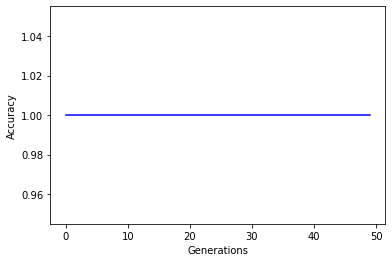

In [ ]:
best_outputs = []
best_outputs_sol = np.zeros((1,num_initial_featr))
initial_parents = np.random.randint(low=0, high=2, size=(pop_size,num_initial_featr))

for gen in range(num_gen):
  print("Generation:",(gen+1))

  fitness = eval_pop_fitness(initial_parents, classifier, arr_train, arr_val)

  best_outputs.append(np.max(fitness))
  print("Best result: ",np.max(fitness).item(0))

  parents = select_mating_pool(initial_parents, fitness, pop_for_mating)
  best_outputs_sol = np.append(best_outputs_sol, [parents[0,:]], axis=0)
  crossed_offsprings = crossing_over(parents, offspring_size=((pop_size-pop_for_mating),initial_parents.shape[1]))

  mutated_offsprings = mutation(crossed_offsprings, num_mutations)

  initial_parents[:pop_for_mating,:] = parents
  initial_parents[pop_for_mating:,:] = mutated_offsprings


best_output_id = np.where(best_outputs==np.max(best_outputs))[0][-1]
best_acc = (best_outputs[best_output_id])*100.0
best_solution = best_outputs_sol[best_output_id+1,:]
featr_selec_idx = np.where(best_solution==1)[0]
print("Best candidate solution has accuracy of {:.4f}".format(best_acc))
print("Number of features extracted by GA :",np.where(best_solution==1)[0].shape[0])
print("Feature indices that were exracted are: ",np.where(best_solution==1)[0])
print('\n')
plt.plot(range(num_gen), best_outputs,'b')
plt.xlabel('Generations')
plt.ylabel("Accuracy")

In [ ]:
arr_test = arr_test[:,np.append(featr_selec_idx,[num_initial_featr])]
arr_train = arr_train_val[:,np.append(featr_selec_idx,[num_initial_featr])]
# from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=5)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_train[:,:-1], arr_train[:,-1])
test_pred = model.predict(arr_test[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[143  23]
 [  3  11]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.86      0.92       166
         1.0       0.32      0.79      0.46        14

    accuracy                           0.86       180
   macro avg       0.65      0.82      0.69       180
weighted avg       0.93      0.86      0.88       180
 

The accuracy on test dataset: 85.55556%


## GA with KNN but with ABHC

In [ ]:
#Genetic Algorithm

arr_train_val = np.asarray(df1)
arr_test = np.asarray(df2)

pop_size = 50
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

1792


In [ ]:
# split dataset

train_idx = np.random.permutation(range(num_samples))
arr_train = arr_train_val[train_idx[:int(.8*num_samples)],:]
arr_val = arr_train_val[train_idx[int(.8*num_samples):],:]


In [ ]:
def reduced_features(sol, arr_train, arr_val):
  sol = np.append(sol,[1])
  indices = np.where(sol==1)[0]
  train_space = arr_train[:,indices]
  val_space = arr_val[:,indices]
  return train_space, val_space


def classifier_acc(val_pred, labels):
  count_list = np.where(val_pred==labels)
  acc = count_list[0].shape[0]/val_pred.shape[0]
  return acc


def eval_pop_fitness(initial_parents, classifier, arr_train, arr_val):
  accuracies = np.zeros(initial_parents.shape[0])
  id=0
  for sol in initial_parents:
    train_space, val_space = reduced_features(sol, arr_train, arr_val)
    if classifier == 'KNN':
      from sklearn.neighbors import KNeighborsClassifier
      model = KNeighborsClassifier(n_neighbors=5)
      model.fit(train_space[:,:-1], train_space[:,-1])
      val_pred = model.predict(val_space[:,:-1])
      accuracies[id] = classifier_acc(val_pred, val_space[:,-1])
      id +=1
  return accuracies


def select_mating_pool(initial_parents, fitness, pop_for_mating):
  parents = np.zeros((pop_for_mating, initial_parents.shape[1]))
  for n in range(pop_for_mating):
    max_fitness_id = np.where(fitness == np.max(fitness))[0]
    max_fitness_id = max_fitness_id[0]
    parents[n,:] = initial_parents[max_fitness_id,:]
    fitness[max_fitness_id] = -99999999999
  return parents


def crossing_over(parents, offspring_size):
  crossed_offsprings = np.empty(offspring_size)
  crossover_point = np.uint8(offspring_size[1]/2)
  for n in range(offspring_size[0]):
    parent1_id = n%parents.shape[0]
    parent2_id = (n+1)%parents.shape[0]
    crossed_offsprings[n,:crossover_point] = parents[parent1_id, :crossover_point]
    crossed_offsprings[n,crossover_point:] = parents[parent2_id, crossover_point:]
  return crossed_offsprings


def mutation(crossed_offsprings, num_mutations):
  mutation_id = np.random.randint(low=0, high=crossed_offsprings.shape[1],size=num_mutations)
  for n in range(crossed_offsprings.shape[0]):
    crossed_offsprings[n,mutation_id] = 1-crossed_offsprings[n,mutation_id]
  return crossed_offsprings


def AdaptiveBetaHC(offspring, offspring_fitness, classifier, arr_train, arr_val):
  b_min=1
  b_max = 100
  iters = 20
  for value in range(iters):
    neighbor = offspring
    percent = 0.3
    upper = int(percent*offspring.shape[0])
    if upper<=1:
      upper = offspring.shape[0]
    x = random.randint(1,upper)
    pos = random.sample(range(0, offspring.shape[0]-1),x)
    for i in pos:
      neighbor[i] = 1-neighbor[i]
    beta = b_min + (value/iters)*(b_max-b_min)
    for i in range(offspring.shape[0]):
      random.seed(0)
      if random.random() <= beta:
        neighbor[i] = offspring[i]
    neighbor_fitness = eval_pop_fitness(np.asarray([neighbor]), classifier, arr_train, arr_val)
    if neighbor_fitness[0] > offspring_fitness:
      offspring = neighbor


  return offspring

In [ ]:
best_outputs = []
best_outputs_sol = np.zeros((1,num_initial_featr))
initial_parents = np.random.randint(low=0, high=2, size=(pop_size,num_initial_featr))

for gen in range(num_gen):
  print("Generation:",(gen+1))

  fitness = eval_pop_fitness(initial_parents, classifier, arr_train, arr_val)

  best_outputs.append(np.max(fitness))
  print("Best result: ",np.max(fitness).item(0))

  parents = select_mating_pool(initial_parents, fitness, pop_for_mating)
  best_outputs_sol = np.append(best_outputs_sol, [parents[0,:]], axis=0)
  crossed_offsprings = crossing_over(parents, offspring_size=((pop_size-pop_for_mating),initial_parents.shape[1]))

  mutated_offsprings = mutation(crossed_offsprings, num_mutations)
  mut_offsprings_fitness = eval_pop_fitness(mutated_offsprings, classifier, arr_train, arr_val)

  for i in range(mutated_offsprings.shape[0]):
    off = mutated_offsprings[i]
    mutated_offsprings[i] = AdaptiveBetaHC(off,mut_offsprings_fitness[i], classifier, arr_train, arr_val)

  initial_parents[:pop_for_mating,:] = parents
  initial_parents[pop_for_mating:,:] = mutated_offsprings


best_output_id = np.where(best_outputs==np.max(best_outputs))[0][-1]
best_acc = (best_outputs[best_output_id])*100.0
best_solution = best_outputs_sol[best_output_id+1,:]
featr_selec_idx = np.where(best_solution==1)[0]
print("Best candidate solution has accuracy of {:.4f}".format(best_acc))
print("Number of features extracted by GA :",np.where(best_solution==1)[0].shape[0])
print("Feature indices that were exracted are: ",np.where(best_solution==1)[0])
print('\n')
plt.plot(range(num_gen), best_outputs,'b')
plt.xlabel('Generations')
plt.ylabel("Accuracy")

Generation: 1
Best result:  0.9577464788732394
Generation: 2
Best result:  0.9577464788732394
Generation: 3
Best result:  0.9577464788732394
Generation: 4
Best result:  0.9577464788732394


KeyboardInterrupt: ignored

In [ ]:
arr_test = arr_test[:,np.append(featr_selec_idx,[num_initial_featr])]
arr_train = arr_train_val[:,np.append(featr_selec_idx,[num_initial_featr])]
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_train[:,:-1], arr_train[:,-1])
test_pred = model.predict(arr_test[:,:-1])
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[  30    2    8    1    2    1    1]
 [   8   78    6    3    0    7    0]
 [  13    6  133    1   11   10    0]
 [   0    0    0   10    0    0    0]
 [   5    3   21    1  150   49    0]
 [  10   14   54    7   62 1290    4]
 [   0    1    0    0    0    0   23]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.45      0.67      0.54        45
         1.0       0.75      0.76      0.76       102
         2.0       0.60      0.76      0.67       174
         3.0       0.43      1.00      0.61        10
         4.0       0.67      0.66      0.66       229
         5.0       0.95      0.90      0.92      1441
         6.0       0.82      0.96      0.88        24

    accuracy                           0.85      2025
   macro avg       0.67      0.81      0.72      2025
weighted avg       0.86      0.85      0.85      2025
 

The accuracy on test dataset: 84.64198%


#Py-FS
GA

In [ ]:
! git clone https://github.com/consigliere19/Py-FS.git

Cloning into 'Py-FS'...
remote: Enumerating objects: 1411, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 1411 (delta 172), reused 168 (delta 168), pack-reused 1217
Receiving objects: 100% (1411/1411), 7.40 MiB | 12.69 MiB/s, done.
Resolving deltas: 100% (878/878), done.


In [ ]:
cd '/content/Py-FS/Py_FS/wrapper/nature_inspired'

/content/Py-FS/Py_FS/wrapper/nature_inspired


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import time

# from Py_FS.wrapper.nature_inspired._utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot
from _utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot


def GA(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, prob_cross=0.4, prob_mut=0.3, save_conv_graph=False, seed=0):


    short_name = 'GA'
    agent_name = 'Chromosome'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    cross_limit = 5
    np.random.seed(seed)

    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):
        weight_acc = float(input('Weight for the classification accuracy [0-1]: '))

    obj = (obj_function, weight_acc)
    compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

    # initialize chromosomes and Leader (the agent with the max fitness)
    chromosomes = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)
    convergence_curve['feature_count'] = np.zeros(max_iter)

    # initialize data class
    data = Data()
    val_size = float(input('Enter the percentage of data wanted for valdiation [0, 100]: '))/100
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=val_size)
    data_train = np.concatenate((data.train_X,data.train_Y.reshape(-1,1)), axis=1)
    data_val = np.concatenate((data.val_X,data.val_Y.reshape(-1,1)), axis=1)

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial population
    chromosomes, fitness = sort_agents(chromosomes, obj, data)

    # start timer
    start_time = time.time()

    # main loop
    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')

        # perform crossover, mutation and replacement
        chromosomes, fitness = cross_mut(chromosomes, fitness, obj, data, prob_cross, cross_limit, prob_mut)
        # perform ABHC
        for i in range(chromosomes.shape[0]):
          off = chromosomes[i]
          chromosomes[i] = AdaptiveBetaHC(off, fitness[i], classifier, data_train, data_val)

        # update final information
        chromosomes, fitness = sort_agents(chromosomes, obj, data, fitness)
        display(chromosomes, fitness, agent_name)

        if fitness[0]>Leader_fitness:
            Leader_agent = chromosomes[0].copy()
            Leader_fitness = fitness[0].copy()
        # convergence_curve['fitness'][iter_no] = Leader_fitness
        # convergence_curve['feature_count'][iter_no] = int(np.sum(Leader_agent))
        convergence_curve['fitness'][iter_no] = np.mean(fitness)
        convergence_curve['feature_count'][iter_no] = np.mean(np.sum(chromosomes,axis=1))

    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    chromosomes, accuracy = sort_agents(chromosomes, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # Plot
    fig, axes = Conv_plot(convergence_curve)
    if(save_conv_graph):
        plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_population = chromosomes
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution



def classifier_acc(val_pred, labels):
  count_list = np.where(val_pred==labels)
  acc = count_list[0].shape[0]/val_pred.shape[0]
  return acc


def eval_pop_fitness(initial_parents, classifier, arr_train, arr_val):
  accuracies = np.zeros(initial_parents.shape[0])
  id=0
  for sol in initial_parents:
    train_space, val_space = reduced_features(sol, arr_train, arr_val)
    if classifier == 'KNN':
      from sklearn.neighbors import KNeighborsClassifier
      model = KNeighborsClassifier(n_neighbors=5)
      model.fit(train_space[:,:-1], train_space[:,-1])
      val_pred = model.predict(val_space[:,:-1])
      accuracies[id] = classifier_acc(val_pred, val_space[:,-1])
      id +=1
  return accuracies


def reduced_features(sol, arr_train, arr_val):
  sol = np.append(sol,[1])
  indices = np.where(sol==1)[0]
  train_space = arr_train[:,indices]
  val_space = arr_val[:,indices]
  return train_space, val_space


def crossover(parent_1, parent_2, prob_cross):
    # perform crossover with crossover probability prob_cross
    num_features = parent_1.shape[0]
    child_1 = parent_1.copy()
    child_2 = parent_2.copy()

    for i in range(num_features):
        if(np.random.rand()<prob_cross):
            child_1[i] = parent_2[i]
            child_2[i] = parent_1[i]

    return child_1, child_2


def mutation(chromosome, prob_mut):
    # perform mutation with mutation probability prob_mut
    num_features = chromosome.shape[0]
    mut_chromosome = chromosome.copy()

    for i in range(num_features):
        if(np.random.rand()<prob_mut):
            mut_chromosome[i] = 1-mut_chromosome[i]

    return mut_chromosome


def roulette_wheel(fitness):
    # Perform roulette wheel selection
    maximum = sum([f for f in fitness])
    selection_probs = [f/maximum for f in fitness]
    return np.random.choice(len(fitness), p=selection_probs)


def cross_mut(chromosomes, fitness, obj, data, prob_cross, cross_limit, prob_mut):
    # perform crossover, mutation and replacement
    count = 0
    num_agents = chromosomes.shape[0]
    print('Crossover-Mutation phase starting....')

    while(count<cross_limit):
        print('\nCrossover no. {}'.format(count+1))
        id_1 = roulette_wheel(fitness)
        id_2 = roulette_wheel(fitness)

        if(id_1 != id_2):
            child_1, child_2 = crossover(chromosomes[id_1], chromosomes[id_2], prob_cross)
            child_1 = mutation(child_1, prob_mut)
            child_2 = mutation(child_2, prob_mut)

            child = np.array([child_1, child_2])
            child, child_fitness = sort_agents(child, obj, data)

            for i in range(2):
                print(fitness[0])
                for j in range(num_agents):
                    print('i:', i, child_fitness[i], 'j:', j, fitness[j])
                    if(child_fitness[i] > fitness[j]):
                        print('child {} replaced with chromosome having id {}'.format(i+1, j+1))
                        chromosomes[j] = child[i]
                        fitness[j] = child_fitness[i]
                        break

            count = count+1


        else:
            print('Crossover failed....')
            print('Restarting crossover....\n')

    return chromosomes, fitness


In [ ]:
def AdaptiveBetaHC(offspring, offspring_fitness, classifier, arr_train, arr_val):
  b_min=1
  b_max = 100
  iters = 20
  for value in range(iters):
    neighbor = offspring
    percent = 0.3
    upper = int(percent*offspring.shape[0])
    if upper<=1:
      upper = offspring.shape[0]
    x = random.randint(1,upper)
    pos = random.sample(range(0, offspring.shape[0]-1),x)
    for i in pos:
      neighbor[i] = 1-neighbor[i]
    beta = b_min + (value/iters)*(b_max-b_min)
    for i in range(offspring.shape[0]):
      random.seed(0)
      if random.random() <= beta:
        neighbor[i] = offspring[i]
    neighbor_fitness = eval_pop_fitness(np.asarray([neighbor]), classifier, arr_train, arr_val)
    if neighbor_fitness[0] > offspring_fitness:
      offspring = neighbor


  return offspring

Streaming output truncated to the last 5000 lines.
i: 1 0.6207163742690059 j: 45 0.6284904970760234
i: 1 0.6207163742690059 j: 46 0.625405701754386
i: 1 0.6207163742690059 j: 47 0.6219115497076023
i: 1 0.6207163742690059 j: 48 0.6209649122807017
i: 1 0.6207163742690059 j: 49 0.6208845029239767

Number of agents: 50

------------- Best Agent ---------------
Fitness: 0.7511476608187135
Number of Features: 1486
----------------------------------------

Chromosome 1 - Fitness: 0.7511476608187135, Number of Features: 1486
Chromosome 2 - Fitness: 0.7487207602339182, Number of Features: 1494
Chromosome 3 - Fitness: 0.7474049707602339, Number of Features: 1502
Chromosome 4 - Fitness: 0.7454312865497076, Number of Features: 1514
Chromosome 5 - Fitness: 0.7390570175438597, Number of Features: 1546
Chromosome 6 - Fitness: 0.7385635964912282, Number of Features: 1549
Chromosome 7 - Fitness: 0.7335051169590643, Number of Features: 1573
Chromosome 8 - Fitness: 0.7293128654970761, Number of Features:

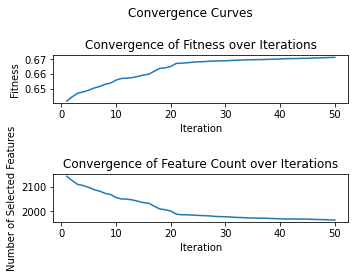

In [ ]:
solution = GA(num_agents=50, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
arr_train_val.shape

(898, 4865)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index = np.where(featr_binary==1)[0]
print(len(featr_index))

1486


In [ ]:
arr_tr_new = arr_train_val[:,featr_index]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[675  55]
 [  9  19]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       730
         1.0       0.26      0.68      0.37        28

    accuracy                           0.92       758
   macro avg       0.62      0.80      0.66       758
weighted avg       0.96      0.92      0.93       758
 

The accuracy on test dataset: 91.55673%


#MRFGRO


In [ ]:
df_dense_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Densenet.csv').drop(columns=['1024'])
df_eff_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Effnet.csv').drop(columns=['1792'])
df_res_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Resnet.csv')
df_res_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Resnet.csv')
df_res_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Resnet.csv')

In [ ]:
df_1 = pd.concat([df_dense_tr,df_eff_tr,df_res_tr], axis=1)
df_1 = df_1.fillna(0)
df_2 = pd.concat([df_dense_val,df_eff_val,df_res_val], axis=1)
df_2 = df_2.fillna(0)
df_3 = pd.concat([df_dense_test,df_eff_test,df_res_test], axis=1)
df_3 = df_3.fillna(0)
df_1 = sklearn.utils.shuffle(df_1)
df_2 = sklearn.utils.shuffle(df_2)
df_3 = sklearn.utils.shuffle(df_3)

In [ ]:
#Genetic Algorithm

df_train = pd.concat([df_1,df_2], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_3)

pop_size = 50
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

4864


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
from datetime import datetime
import sys
import time

def sigmoid1(gamma):     #convert to probability
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))

def sigmoid2(gamma):
	gamma /= 2
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))

def sigmoid3(gamma):
	gamma /= 3
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))

def sigmoid4(gamma):
	gamma *= 2
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))


def Vfunction1(gamma):
	return abs(np.tanh(gamma))

def Vfunction2(gamma):
	val = (math.pi)**(0.5)
	val /= 2
	val *= gamma
	val = math.erf(val)
	return abs(val)

def Vfunction3(gamma):
	val = 1 + gamma*gamma
	val = math.sqrt(val)
	val = gamma/val
	return abs(val)

def Vfunction4(gamma):
	val=(math.pi/2)*gamma
	val=np.arctan(val)
	val=(2/math.pi)*val
	return abs(val)


def fitness(position):
	cols=np.flatnonzero(position)
	val=1
	if np.shape(cols)[0]==0:
		return val
	#clf = RandomForestClassifier(n_estimators=300)
	clf=KNeighborsClassifier(n_neighbors=5)
	# clf=MLPClassifier( alpha=0.01, max_iter=1000) #hidden_layer_sizes=(1000,500,100)
	#cross=3
	#test_size=(1/cross)
	#X_train, X_test, y_train, y_test = train_test_split(trainX, trainy,  stratify=trainy,test_size=test_size)
	train_data=trainX[:,cols]
	test_data=testX[:,cols]
	clf.fit(train_data,trainy)
	val=1-clf.score(test_data,testy)

	#in case of multi objective  []
	set_cnt=sum(position)
	set_cnt=set_cnt/np.shape(position)[0]
	val=omega*val+(1-omega)*set_cnt
	return val

def onecount(position):
	cnt=0
	for i in position:
		if i==1.0:
			cnt+=1
	return cnt


def allfit(population):
	x=np.shape(population)[0]
	acc=np.zeros(x)
	for i in range(x):
		acc[i]=fitness(population[i])
		#print(acc[i])
	return acc

def initialize(popSize,dim):
	population=np.zeros((popSize,dim))
	minn = 1
	maxx = math.floor(0.8*dim)
	if maxx<minn:
		minn = maxx

	for i in range(popSize):
		random.seed(i**3 + 10 + time.time() )
		no = random.randint(minn,maxx)
		if no == 0:
			no = 1
		random.seed(time.time()+ 100)
		pos = random.sample(range(0,dim-1),no)
		for j in pos:
			population[i][j]=1

		# print(population[i])

	return population

def toBinary(population,popSize,dimension,oldPop):

	for i in range(popSize):
		for j in range(dimension):
			temp = Vfunction3(population[i][j])

			# if temp > 0.5: # sfunction
			# 	population[i][j] = 1
			# else:
			# 	population[i][j] = 0

			if temp > 0.5: # vfunction
				population[i][j] = (1 - oldPop[i][j])
			else:
				population[i][j] = oldPop[i][j]
	return population


#####################################################################################
omega = 0.85 #weightage for no of features and accuracy
popSize = 50
max_iter = 50
S = 2


df = df_train
(a,b)=np.shape(df)
print(a,b)
data = df.values[:,0:b-1]
label = df.values[:,b-1]
dimension = np.shape(data)[1] #particle dimension


best_accuracy = -1
best_no_features = -1
average_accuracy = 0
global_count = 0
accuracy_list = []
features_list = []

for train_iteration in range(51):

	#---------------------------------------------------------------------

	cross = 5
	test_size = (1/cross)
	trainX, testX, trainy, testy = train_test_split(data, label,stratify=label ,test_size=test_size)


	# clf = RandomForestClassifier(n_estimators=300)
	clf=KNeighborsClassifier(n_neighbors=5)
	# clf=MLPClassifier(alpha=0.001, max_iter=1000) #hidden_layer_sizes=(1000,500,100)
	clf.fit(trainX,trainy)
	val=clf.score(testX,testy)
	whole_accuracy = val
	print("Total Acc: ",val)

	# for population_iteration in range(2):
	global_count += 1
	print('global: ',global_count)

	x_axis = []
	y_axis = []

	population = initialize(popSize,dimension)
	# print(population)

	start_time = datetime.now()
	fitList = allfit(population)
	bestInx = np.argmin(fitList)
	fitBest = min(fitList)
	Mbest = population[bestInx].copy()
	for currIter in range(max_iter):

		popnew = np.zeros((popSize,dimension))
		x_axis.append(currIter)
		y_axis.append(min(fitList))
		for i in range(popSize):
			random.seed(time.time() + 10.01)
			randNo = random.random()
			if randNo<0.5 :
				#chain foraging
				random.seed(time.time())
				r = random.random()
				alpha = 2*r*(abs(math.log(r))**0.5)
				if i == 1:
					popnew[i] = population[i] + r * (Mbest - population[i]) + alpha*(Mbest - population[i])
				else:
					popnew[i] = population[i] + r * (population[i-1] - population[i]) + alpha*(Mbest - population[i])
			else:
				#cyclone foraging
				cutOff = random.random()
				r = random.random()
				r1 = random.random()
				beta = 2 * math.exp(r1 * (max_iter - currIter + 1) / max_iter) * math.sin(2 * math.pi * r1)
				if currIter/max_iter < cutOff:
					# exploration
					Mrand = np.zeros(np.shape(population[0]))
					no = random.randint(1,max(int(0.1*dimension),2))
					random.seed(time.time()+ 100)
					pos = random.sample(range(0,dimension-1),no)
					for j in pos:
						Mrand[j] = 1

					if i==1 :
						popnew[i] = Mrand + r * (Mrand - population[i]) + beta * (Mrand - population[i])
					else:
						popnew[i] = Mrand + r * (population[i-1] - population[i]) + beta * (Mrand - population[i])
				else:
					# exploitation
					if i == 1:
						popnew[i] = Mbest + r * (Mbest - population[i]) + beta * (Mbest - population[i])
					else:
						popnew[i] = Mbest + r * (population[i-1] - population[i]) + beta * (Mbest - population[i])

		# print(popnew)

		popnew = toBinary(popnew,popSize,dimension,population)
		popnewTemp = popnew.copy()
		#compute fitness for each individual
		fitList = allfit(popnew)
		if min(fitList)<fitBest :
			bestInx = np.argmin(fitList)
			fitBest = min(fitList)
			Mbest = popnew[bestInx].copy()
		# print(fitList,fitBest)

		#somersault foraging
		for i in range(popSize):
			r2 = random.random()
			random.seed(time.time())
			r3 = random.random()
			popnew[i] = popnew[i] + S * (r2*Mbest - r3*popnew[i])

		popnew = toBinary(popnew,popSize,dimension,popnewTemp)
		#compute fitness for each individual
		fitList = allfit(popnew)
		if min(fitList)<fitBest :
			bestInx = np.argmin(fitList)
			fitBest = min(fitList)
			Mbest = popnew[bestInx].copy()
		# print(fitList,fitBest)

		population = popnew.copy()


	time_required = datetime.now() - start_time

	# pyplot.plot(x_axis,y_axis)
	# pyplot.xlim(0,max_iter)
	# pyplot.ylim(max(0,min(y_axis)-0.1),min(max(y_axis)+0.1,1))
	# pyplot.show()


	output = Mbest.copy()
	print(output)

	#test accuracy
	cols=np.flatnonzero(output)
	#print(cols)
	X_test=testX[:,cols]
	X_train=trainX[:,cols]
	#print(np.shape(feature))

	# clf = RandomForestClassifier(n_estimators=300)
	clf=KNeighborsClassifier(n_neighbors=5)
	#clf=MLPClassifier( alpha=0.001, max_iter=2000) #hidden_layer_sizes=(1000,500,100 ),
	clf.fit(X_train,trainy)
	val=clf.score(X_test, testy )
	print(val,onecount(output))

	accuracy_list.append(val)
	features_list.append(onecount(output))
	if ( val == best_accuracy ) and ( onecount(output) < best_no_features ):
		best_accuracy = val
		best_no_features = onecount( output )
		best_time_req = time_required
		best_whole_accuracy = whole_accuracy

	if val > best_accuracy :
		best_accuracy = val
		best_no_features = onecount( output )
		best_time_req = time_required
		best_whole_accuracy = whole_accuracy

print('best: ',best_accuracy, best_no_features)

9018 513
Total Acc:  0.9905764966740577
global:  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index = np.where(featr_binary==1)[0]
print(len(featr_index))

In [ ]:
arr_tr_new = arr_train_val[:,cols]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,cols]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_tr[:,-1])
test_pred = model.predict(arr_val_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_val[:,-1]),classification_report(test_pred, arr_val[:,-1])))
acc = accuracy_score(test_pred, arr_val[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[143  28]
 [  3   6]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.84      0.90       171
         1.0       0.18      0.67      0.28         9

    accuracy                           0.83       180
   macro avg       0.58      0.75      0.59       180
weighted avg       0.94      0.83      0.87       180
 

The accuracy on test dataset: 82.77778%


In [ ]:
featr_rda = np.asarray(pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_RDA.csv'))[:,-1]
featr_woa = np.asarray(pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_WOA.csv'))[:,-1]

In [ ]:
featr_rda

array([[   0,    5],
       [   1,    8],
       [   2,   11],
       ...,
       [1491, 4855],
       [1492, 4856],
       [1493, 4861]])

In [ ]:
list_final = []
for i in range(4865):
  a=0
  for j in range(len(featr_woa)):
    if featr_woa[j] == i:
      a+=1
  for j in range(len(featr_rda)):
    if featr_rda[j] == i:
      a+=1
  if a==2 or a==1:
    list_final.append([i])

In [ ]:
list_final = (np.asarray(list_final).reshape((1,-1)))[0]
list_final

array([   5,    6,    8, ..., 4860, 4861, 4862])

In [ ]:
from Py_FS.wrapper.nature_inspired.GA import GA as FS
solution = FS(num_agents=50, max_iter=num_gen, train_data=arr_train_val[:,featr_index], train_label=arr_train_val[:,-1], save_conv_graph=True)

NameError: ignored

In [ ]:
arr_train_val.shape

(898, 4865)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index = np.where(featr_binary==1)[0]
print(len(featr_index))

940


In [ ]:
arr_tr_new = arr_train_val[:,featr_index]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[682  61]
 [  2  13]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       743
         1.0       0.18      0.87      0.29        15

    accuracy                           0.92       758
   macro avg       0.59      0.89      0.62       758
weighted avg       0.98      0.92      0.94       758
 

The accuracy on test dataset: 91.68865%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[682  61]
 [  2  13]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       743
         1.0       0.18      0.87      0.29        15

    accuracy                           0.92       758
   macro avg       0.59      0.89      0.62       758
weighted avg       0.98      0.92      0.94       758
 

The accuracy on test dataset: 91.68865%


Weight for the classification accuracy [0-1]: 0.05
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 50

------------- Best Agent ---------------
Fitness: 0.6928209863994831
Number of Features: 2543
----------------------------------------

Whale 1 - Fitness: 0.6928209863994831, Number of Features: 2543
Whale 2 - Fitness: 0.6813382752628765, Number of Features: 2632
Whale 3 - Fitness: 0.6806936848378186, Number of Features: 2642
Whale 4 - Fitness: 0.6451405094345928, Number of Features: 2939
Whale 5 - Fitness: 0.6344496998084119, Number of Features: 3026
Whale 6 - Fitness: 0.6235931304023347, Number of Features: 3119
Whale 7 - Fitness: 0.6131785638700767, Number of Features: 3206
Whale 8 - Fitness: 0.6097438694639993, Number of Features: 3237
Whale 9 - Fitness: 0.6032888801015862, Number of Features: 3284
Whale 10 - Fitness: 0.5847617960256639, Number of Features: 3448
Whale 11 - Fitness: 0.5846420883643735, Num

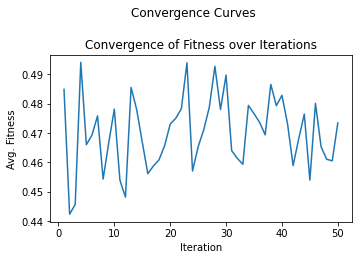

In [ ]:
from Py_FS.wrapper.nature_inspired.WOA import WOA as FS
solution = FS(num_agents=pop_size, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
arr_train_val.shape

(898, 4865)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
featr_index_woa

array([   0,    4,   13, ..., 7926, 7928, 7932])

In [ ]:
df_featr = pd.DataFrame(featr_index_)
df_featr.to_csv('featr_WOA_2.csv')

In [ ]:
df_1

0         1         2         3         4         5         6  \
483  0.015330  0.019014  0.014855  0.014355  0.075107  0.471692  0.014578   
348  0.015586  0.013530  0.014164  0.013689  0.006508  0.251475  0.015126   
670  0.015396  0.015614  0.016548  0.013034  0.068441 -0.317318  0.014994   
500  0.015303  0.019076  0.017950  0.013603  0.087415  0.496374  0.015339   
209  0.015586  0.013311  0.016903  0.013468  0.095931  0.408994  0.015575   
..        ...       ...       ...       ...       ...       ...       ...   
225  0.015847  0.019813  0.012413  0.014875  0.027656 -0.019839  0.015280   
208  0.015874  0.010827  0.015945  0.013042 -0.079953  0.546249  0.014609   
613  0.015529  0.012335  0.015975  0.014535 -0.047605  0.738811  0.015360   
520  0.015654  0.015677  0.016583  0.015065  0.071533  0.017323  0.014697   
556  0.015680  0.012360  0.015551  0.014488  0.025052 -0.124021  0.014653   

            7         8         9  ...      2039      2040      2041  \
483  0.014344 -0.001627  0.009666  ...  0.655175  0.700127  0.335002   
348  0.014092 -0.177222  0.009932  ...  1.345256  0.650158  0.199820   
670  0.014825 -0.208816  0.009811  ...  0.668197  0.279148  0.768721   
500  0.015992 -0.211245  0.009665  ...  0.928961  0.750528  0.152119   
209  0.015394  0.135044  0.009683  ...  1.048827  0.838439  0.344374   
..        ...       ...       ...  ...       ...       ...       ...   
225  0.014842  0.120283  0.009621  ...  1.131006  1.063558  0.296422   
208  0.011486  0.201613  0.009764  ...  1.292944  0.699383  0.180396   
613  0.013778  0.009486  0.009336  ...  0.476117  0.344951  1.024229   
520  0.014152 -0.041119  0.009581  ...  1.180396  0.647755  0.310017   
556  0.011983 -0.034808  0.009515  ...  1.184821  0.391288  0.202484   

         2042      2043      2044      2045      2046      2047  2048  
483  0.865504  0.353651  0.542114  0.539843  0.522502  0.796063   0.0  
348  0.950289  0.549921  0.551999  0.714647  0.472245  0.624268   0.0  
670  0.955208  1.486396  1.203456  0.593832  0.301480  0.020009   1.0  
500  0.676121  0.579130  0.440149  0.689052  0.329631  0.451938   0.0  
209  0.557666  0.482501  0.481356  0.414994  0.632820  0.259832   0.0  
..        ...       ...       ...       ...       ...       ...   ...  
225  0.629420  0.239045  0.724937  0.773914  0.625150  1.386205   0.0  
208  0.614675  0.652694  0.452067  0.629706  0.470088  0.389767   0.0  
613  0.649333  1.033292  1.213471  0.420575  0.451832  0.242818   1.0  
520  0.470362  0.523660  0.459049  0.393147  0.703205  0.360573   0.0  
556  0.463687  0.242663  0.425618  0.333003  0.509421  0.483386   0.0  

[718 rows x 4865 columns]

In [ ]:
df_featr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_WOA.csv')
featr_index_woa = np.asarray(df_featr)[0]

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[304  74]
 [  0   0]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.80      0.89       378
         1.0       0.00      0.00      0.00         0

    accuracy                           0.80       378
   macro avg       0.50      0.40      0.45       378
weighted avg       1.00      0.80      0.89       378
 

The accuracy on test dataset: 80.42328%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[677  56]
 [  7  18]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       733
         1.0       0.24      0.72      0.36        25

    accuracy                           0.92       758
   macro avg       0.62      0.82      0.66       758
weighted avg       0.97      0.92      0.94       758
 

The accuracy on test dataset: 91.68865%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=5, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[673  54]
 [ 11  20]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       727
         1.0       0.27      0.65      0.38        31

    accuracy                           0.91       758
   macro avg       0.63      0.79      0.67       758
weighted avg       0.95      0.91      0.93       758
 

The accuracy on test dataset: 91.42480%


Weight for the classification accuracy [0-1]: 0.1
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 50

------------- Best Agent ---------------
Fitness: 0.5146559758771929
Number of Features: 2605
----------------------------------------

Agent 1 - Fitness: 0.5146559758771929, Number of Features: 2605
Agent 2 - Fitness: 0.513545778508772, Number of Features: 2611
Agent 3 - Fitness: 0.5096591739766082, Number of Features: 2626
Agent 4 - Fitness: 0.5094750548245615, Number of Features: 2633
Agent 5 - Fitness: 0.5081793676900586, Number of Features: 2637
Agent 6 - Fitness: 0.5067000182748538, Number of Features: 2651
Agent 7 - Fitness: 0.5059594298245614, Number of Features: 2652
Agent 8 - Fitness: 0.5055898209064328, Number of Features: 2657
Agent 9 - Fitness: 0.5055889071637427, Number of Features: 2651
Agent 10 - Fitness: 0.5039245248538012, Number of Features: 2666
Agent 11 - Fitness: 0.5028143274853801, Numbe

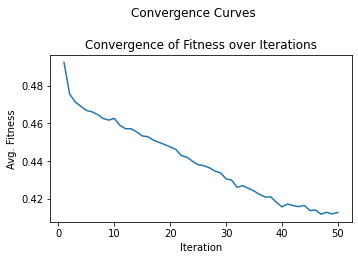

In [ ]:
from Py_FS.wrapper.nature_inspired.SCA import SCA as FS
solution = FS(num_agents=pop_size, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
arr_train_val.shape

(898, 4865)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index = np.where(featr_binary==1)[0]
featr_index

array([   0,    5,    7, ..., 4853, 4855, 4863])

In [ ]:
arr_tr_new = arr_train_val[:,featr_index]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[672  54]
 [ 12  20]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       726
         1.0       0.27      0.62      0.38        32

    accuracy                           0.91       758
   macro avg       0.63      0.78      0.67       758
weighted avg       0.95      0.91      0.93       758
 

The accuracy on test dataset: 91.29288%


In [ ]:
df_featr_WOA = pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_WOA.csv')
arr_featr_woa = np.asarray(df_featr_WOA)[:,-1]
arr_featr_woa

array([   6,    8,   11, ..., 4860, 4861, 4862])

Weight for the classification accuracy [0-1]: 0.2
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 50

------------- Best Agent ---------------
Fitness: 0.908200678236585
Number of Features: 117
----------------------------------------

RedDeer 1 - Fitness: 0.908200678236585, Number of Features: 117
RedDeer 2 - Fitness: 0.908200678236585, Number of Features: 117
RedDeer 3 - Fitness: 0.908200678236585, Number of Features: 117
RedDeer 4 - Fitness: 0.7488430081787353, Number of Features: 342
RedDeer 5 - Fitness: 0.7488430081787353, Number of Features: 342
RedDeer 6 - Fitness: 0.7111749451426292, Number of Features: 396
RedDeer 7 - Fitness: 0.7111749451426292, Number of Features: 396
RedDeer 8 - Fitness: 0.7111749451426292, Number of Features: 396
RedDeer 9 - Fitness: 0.7078416118092958, Number of Features: 396
RedDeer 10 - Fitness: 0.7078416118092958, Number of Features: 396
RedDeer 11 - Fitness: 0.707841611809295

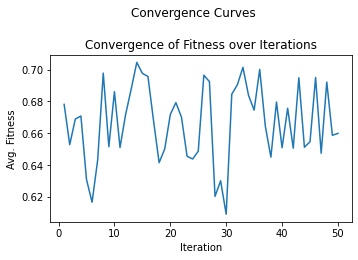

In [ ]:
from Py_FS.wrapper.nature_inspired.RDA import RDA as FS
solution = FS(num_agents=pop_size, max_iter=50, train_data=arr_train_val[:,arr_featr_woa], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
arr_train_val.shape

(898, 4865)

In [ ]:
featr_binary = solution.best_agent
len(featr_binary)

1114

In [ ]:
featr_index_rda = np.where(featr_binary==1)[0]
featr_index_rda

array([  63,   74,  156,  198,  222,  430,  459,  531,  585,  628,  711,
        718,  722,  725,  783,  943, 1009, 1068, 1091])

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_rda]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_rda]

In [ ]:
df_featr = pd.DataFrame(featr_index)
df_featr.to_csv('featr_RDA.csv')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[664  66]
 [ 20   8]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       730
         1.0       0.11      0.29      0.16        28

    accuracy                           0.89       758
   macro avg       0.54      0.60      0.55       758
weighted avg       0.94      0.89      0.91       758
 

The accuracy on test dataset: 88.65435%


Weight for the classification accuracy [0-1]: 0.1
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 50

------------- Best Agent ---------------
Fitness: 0.5590647843567251
Number of Features: 2371
----------------------------------------

Particle 1 - Fitness: 0.5590647843567251, Number of Features: 2371
Particle 2 - Fitness: 0.5583241959064328, Number of Features: 2372
Particle 3 - Fitness: 0.5546239948830409, Number of Features: 2395
Particle 4 - Fitness: 0.5538838633040936, Number of Features: 2399
Particle 5 - Fitness: 0.5535137975146198, Number of Features: 2401
Particle 6 - Fitness: 0.5527727521929824, Number of Features: 2399
Particle 7 - Fitness: 0.552218110380117, Number of Features: 2405
Particle 8 - Fitness: 0.552218110380117, Number of Features: 2405
Particle 9 - Fitness: 0.5520330774853802, Number of Features: 2406
Particle 10 - Fitness: 0.5516634685672515, Number of Features: 2411
Particle 11 - Fi

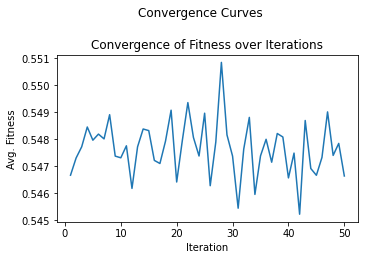

In [ ]:
from Py_FS.wrapper.nature_inspired.EO import EO as FS
solution = FS(num_agents=pop_size, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
arr_train_val.shape

(898, 4865)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index = np.where(featr_binary==1)[0]
print(len(featr_index))

2308


In [ ]:
arr_tr_new = arr_train_val[:,featr_index]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[672  56]
 [ 12  18]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       728
         1.0       0.24      0.60      0.35        30

    accuracy                           0.91       758
   macro avg       0.61      0.76      0.65       758
weighted avg       0.95      0.91      0.93       758
 

The accuracy on test dataset: 91.02902%


# Golden Ratio

In [ ]:
df_dense_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Densenet.csv').drop(columns=['1024'])
df_eff_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Effnet.csv').drop(columns=['1792'])
df_eff_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Effnet.csv').drop(columns=['1792'])
df_res_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Resnet.csv')
df_res_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Resnet.csv')
df_res_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Resnet.csv')

In [ ]:
df_1 = pd.concat([df_dense_tr,df_eff_tr,df_res_tr], axis=1)
df_1 = df_1.fillna(0)
df_2 = pd.concat([df_dense_val,df_eff_val,df_res_val], axis=1)
df_2 = df_2.fillna(0)
df_3 = pd.concat([df_dense_test,df_eff_test,df_res_test], axis=1)
df_3 = df_3.fillna(0)
df_1 = sklearn.utils.shuffle(df_1)
df_2 = sklearn.utils.shuffle(df_2)
df_3 = sklearn.utils.shuffle(df_3)

In [ ]:
#Genetic Algorithm

df_train = pd.concat([df_1,df_2], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_3)

pop_size = 50
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

4864


In [ ]:
# Golden Ratio Optimization

import numpy as np
import pandas as pd
import random
import math,time,sys
from matplotlib import pyplot
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#==================================================================
def sigmoid1(gamma):     #convert to probability
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))

def sigmoid1i(gamma):     #convert to probability
	gamma = -gamma
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))

def sigmoid2(gamma):
	gamma /= 2
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))

def sigmoid3(gamma):
	gamma /= 3
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))

def sigmoid4(gamma):
	gamma *= 2
	if gamma < 0:
		return 1 - 1/(1 + math.exp(gamma))
	else:
		return 1/(1 + math.exp(-gamma))


def Vfunction1(gamma):
	return abs(np.tanh(gamma))

def Vfunction2(gamma):
	val = (math.pi)**(0.5)
	val /= 2
	val *= gamma
	val = math.erf(val)
	return abs(val)

def Vfunction3(gamma):
	val = 1 + gamma*gamma
	val = math.sqrt(val)
	val = gamma/val
	return abs(val)

def Vfunction4(gamma):
	val=(math.pi/2)*gamma
	val=np.arctan(val)
	val=(2/math.pi)*val
	return abs(val)

def initialize(popSize,dim):
	population=np.zeros((popSize,dim))
	minn = 1
	maxx = math.floor(0.8*dim)
	if maxx<minn:
		minn = maxx

	for i in range(popSize):
		random.seed(i**3 + 10 + time.time() )
		no = random.randint(minn,maxx)
		if no == 0:
			no = 1
		random.seed(time.time()+ 100)
		pos = random.sample(range(0,dim-1),no)
		for j in pos:
			population[i][j]=1

		# print(population[i])
	return population

def fitness(solution, trainX, testX, trainy, testy):
	cols=np.flatnonzero(solution)
	val=1
	if np.shape(cols)[0]==0:
		return val
	clf=KNeighborsClassifier(n_neighbors=5)
	train_data=trainX[:,cols]
	test_data=testX[:,cols]
	clf.fit(train_data,trainy)
	val=1-clf.score(test_data,testy)

	#in case of multi objective  []
	set_cnt=sum(solution)
	set_cnt=set_cnt/np.shape(solution)[0]
	val=omega*val+(1-omega)*set_cnt
	return val

def allfit(population, trainX, testX, trainy, testy):
	x=np.shape(population)[0]
	acc=np.zeros(x)
	for i in range(x):
		acc[i]=fitness(population[i],trainX,testX,trainy,testy)
		#print(acc[i])
	return acc

def toBinary(solution,dimension):
	# print("continuous",solution)
	Xnew = np.zeros(np.shape(solution))
	for i in range(dimension):
		temp = Vfunction3(abs(solution[i]))

		random.seed(time.time()+i)
		if temp > random.random(): # sfunction
			Xnew[i] = 1
		else:
			Xnew[i] = 0
		# if temp > 0.5: # vfunction
		# 	Xnew[i] = 1 - abs(solution[i])
		# else:
		# 	Xnew[i] = abs(solution[i])
	# print("binary",Xnew)
	return Xnew

def toBinaryX(solution,dimension,oldsol,trainX, testX, trainy, testy):
	Xnew = np.zeros(np.shape(solution))
	Xnew1 = np.zeros(np.shape(solution))
	Xnew2 = np.zeros(np.shape(solution))
	for i in range(dimension):
		temp = sigmoid1(abs(solution[i]))
		random.seed(time.time()+i)
		r1 = random.random()
		if temp > r1: # sfunction
			Xnew1[i] = 1
		else:
			Xnew1[i] = 0

		temp = sigmoid1i(abs(solution[i]))
		if temp > r1: # sfunction
			Xnew2[i] = 1
		else:
			Xnew2[i] = 0

	fit1 = fitness(Xnew1,trainX,testX,trainy,testy)
	fit2 = fitness(Xnew2,trainX,testX,trainy,testy)
	fitOld =  fitness(oldsol,trainX,testX,trainy,testy)
	if fit1<fitOld or fit2<fitOld:
		if fit1 < fit2:
			Xnew = Xnew1.copy()
		else:
			Xnew = Xnew2.copy()
	return Xnew
	# else: CROSSOVER
	Xnew3 = Xnew1.copy()
	Xnew4 = Xnew2.copy()
	for i in range(dimension):
		random.seed(time.time() + i)
		r2 = random.random()
		if r2>0.5:
			tx = Xnew3[i]
			Xnew3[i] = Xnew4[i]
			Xnew4[i] = tx
	fit1 = fitness(Xnew3,trainX,testX,trainy,testy)
	fit2 = fitness(Xnew4,trainX,testX,trainy,testy)
	if fit1<fit2:
		return Xnew3
	else:
		return Xnew4
	# print("binary",Xnew)


#==================================================================
def goldenratiomethod(dataset,popSize,maxIter):

	#---------------------------------------------------------------------
	#I know I should not put not it here, but still ...
	df=pd.DataFrame(dataset, columns=range(1793))
	(a,b)=np.shape(df)
	print(a,b)
	data = df.values[:,0:b-1]
	label = df.values[:,b-1]
	dimension = np.shape(data)[1] #particle dimension
	#---------------------------------------------------------------------

	cross = 5
	test_size = (1/cross)
	trainX, testX, trainy, testy = train_test_split(data, label,stratify=label ,test_size=test_size)


	clf=KNeighborsClassifier(n_neighbors=5)
	clf.fit(trainX,trainy)
	val=clf.score(testX,testy)
	whole_accuracy = val
	print("Total Acc: ",val)

	x_axis = []
	y_axis = []
	population = initialize(popSize,dimension)
	BESTANS = np.zeros(np.shape(population[0]))
	BESTACC = 1000

	start_time = datetime.now()

	for currIter in range(1,maxIter):

		fitList = allfit(population,trainX,testX,trainy,testy)
		y_axis.append(min(fitList))
		x_axis.append(currIter)
		worstInx = np.argmax(fitList)
		fitWorst = max(fitList)
		Xworst = population[worstInx].copy()

		Xave = population.sum(axis=0)
		Xave = np.divide(Xave,popSize)
		# for x in Xave:
		# 	print("%.2f"%x,end=',')
		# print()
		XaveBin= toBinary(Xave,dimension)
		FITave = fitness(XaveBin, trainX, testX, trainy, testy)
		if FITave<fitWorst:
			population[worstInx] = XaveBin.copy()
			fitList[worstInx] = FITave



		for i in range(popSize):
			Xi = population[i].copy()
			j = i
			while j == i:
				random.seed(time.time()+j)
				j = random.randint(0, popSize-1)
			Xj = population[j].copy()
			FITi = fitList[i]
			FITj = fitList[j]

			Xave = population.sum(axis=0)
			Xave = np.subtract(Xave,population[i])
			Xave = np.subtract(Xave,population[j])
			Xave = np.divide(Xave,(popSize-2))
			XaveBin = toBinary(Xave,dimension)
			FITave = fitness(XaveBin, trainX, testX, trainy, testy)
			# print(i,j,FITi,FITj,FITave)
			Xbest = np.zeros(np.shape(Xi))
			Xmedium = np.zeros(np.shape(Xi))
			Xworst = np.zeros(np.shape(Xi))

			if FITi < FITj < FITave:
				Xbest = Xi.copy()
				Xmedium = Xj.copy()
				Xworst = Xave.copy()
			elif FITi < FITave < FITj:
				Xbest = Xi.copy()
				Xmedium = Xave.copy()
				Xworst = Xj.copy()
			elif FITj < FITi < FITave:
				Xbest = Xj.copy()
				Xmedium = Xi.copy()
				Xworst = Xave.copy()
			elif FITj < FITave < FITi:
				Xbest = Xj.copy()
				Xmedium = Xave.copy()
				Xworst = Xi.copy()
			elif FITave < FITi < FITj:
				Xbest = Xave.copy()
				Xmedium = Xi.copy()
				Xworst = Xj.copy()
			elif FITave < FITj < FITi:
				Xbest = Xave.copy()
				Xmedium = Xj.copy()
				Xworst = Xi.copy()

			Xt = np.subtract(Xmedium,Xworst)
			T = currIter/maxIter
			Ft = (golden/(5**0.5)) * (golden**T - (1 - golden)**T)
			random.seed(19*time.time() + 10.01)
			Xnew = np.multiply(Xbest,(1-Ft)) + np.multiply(Xt,random.random()*Ft)
			Xnew = toBinaryX(Xnew,dimension,population[i],trainX, testX, trainy, testy)
			FITnew = fitness(Xnew, trainX, testX, trainy, testy)
			# if FITnew < fitList[i]:
				# print(i,j,"updated2")
			population[i] = Xnew.copy()
			fitList[i] = FITnew

		#second phase
		worstInx = np.argmax(fitList)
		fitWorst = max(fitList)
		Xworst = population[worstInx].copy()
		bestInx = np.argmin(fitList)
		fitBest = min(fitList)
		Xbest = population[bestInx].copy()
		for i in range(popSize):
			Xi = population[i].copy()
			random.seed(29*time.time() + 391.97 )
			Xnew = np.add(Xi , np.multiply(np.subtract(Xbest,Xworst),random.random()*(1/golden)) )
			Xnew = toBinaryX(Xnew,dimension,population[i],trainX, testX, trainy, testy)
			FITnew = fitness(Xnew, trainX, testX, trainy, testy)
			# if FITnew < fitList[i]:
			fitList[i] = FITnew
			population[i] = Xnew.copy()

			if fitList[i]< BESTACC:
				BESTACC = fitList[i]
				BESTANS = population[i].copy()

		# pyplot.plot(x_axis,y_axis)
		# pyplot.show()
		# bestInx = np.argmin(fitList)
		# fitBest = min(fitList)
		# Xbest = population[bestInx].copy()
	cols = np.flatnonzero(BESTANS)
	val = 1
	if np.shape(cols)[0]==0:
		return Xbest
	clf = KNeighborsClassifier(n_neighbors=5)
	train_data = trainX[:,cols]
	test_data = testX[:,cols]
	clf.fit(train_data,trainy)
	val = clf.score(test_data,testy)
	return BESTANS,val




#==================================================================
golden = (1 + 5 ** 0.5) / 2
popSize = 50
maxIter = 50
omega = 1
accuList = []
featList = []
dataset=df_train.to_numpy()
answer,testAcc = goldenratiomethod(dataset,popSize,maxIter)
print(testAcc,answer.sum())
accuList.append(testAcc)
featList.append(answer.sum())
inx = np.argmax(accuList)
best_accuracy = accuList[inx]
best_no_features = featList[inx]
print(dataset,"best:",accuList[inx],featList[inx])

898 1793
Total Acc:  0.9611111111111111
0.9722222222222222 702.0
[[ 0.00305555 -0.01215466  0.0326811  ... -0.13176639  0.40794659
   0.        ]
 [-0.05449551  0.03925681  0.26836953 ...  0.0944107   0.33233267
   0.        ]
 [ 0.07586116  0.19188637  0.25737116 ...  0.08581372  0.17722715
   0.        ]
 ...
 [ 0.57159573  0.26097721  0.02819426 ...  0.10552293  0.61364788
   1.        ]
 [ 0.69989419  0.12160247  0.02690514 ...  0.18892071  0.12839444
   1.        ]
 [ 0.33733949  0.23294494  0.13737167 ...  0.02005444  0.35331598
   1.        ]] best: 0.9722222222222222 702.0


In [ ]:
answer

array([1., 1., 0., ..., 1., 1., 0.])

In [ ]:
arr_tr_new = arr_train_val[:,featr_index]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index]

In [ ]:
featr_index = np.where(answer==1)[0]
print(len(featr_index))

702


In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(max_depth=6, random_state=0)
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[289  48]
 [ 15  26]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       337
         1.0       0.35      0.63      0.45        41

    accuracy                           0.83       378
   macro avg       0.65      0.75      0.68       378
weighted avg       0.89      0.83      0.85       378
 

The accuracy on test dataset: 83.33333%


In [ ]:
df_woa = pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_WOA.csv')
df_rda = pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_RDA.csv')

In [ ]:
featr_woa = (np.asarray(df_woa))[:,1]
featr_rda = (np.asarray(df_rda))[:,1]

In [ ]:
# len(featr_woa[:,1])
featr_woa[0]

6

In [ ]:
len(featr_rda[:,1])

1494

In [ ]:
list_final = []
for i in range(4865):
  a=0
  for j in range(len(featr_woa)):
    if featr_woa[j] == i:
      a+=1
  for j in range(len(featr_rda)):
    if featr_rda[j] == i:
      a+=1
  if a==2 or a==1:
    list_final.append([i])

In [ ]:
list_final = np.asarray(list_final).reshape(1,-1)
list_final = list_final[0]

In [ ]:
list_final

array([   5,    6,    8, ..., 4860, 4861, 4862])

In [ ]:
arr_tr_new = arr_train_val[:,list_final]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,list_final]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=5, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[670  53]
 [ 14  21]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       723
         1.0       0.28      0.60      0.39        35

    accuracy                           0.91       758
   macro avg       0.63      0.76      0.67       758
weighted avg       0.95      0.91      0.93       758
 

The accuracy on test dataset: 91.16095%


In [ ]:
df_dense_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Densenet.csv').drop(columns=['1024'])
df_dense_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Densenet121_IBLoss.csv').drop(columns=['1024'])
# df_eff_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Effnet.csv').drop(columns=['1792'])
# df_eff_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Effnet.csv').drop(columns=['1792'])
# df_eff_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Effnet.csv').drop(columns=['1792'])
df_res_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Resnet.csv')
df_res_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Resnet.csv')
df_res_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Resnet.csv')

In [ ]:
df_1 = pd.concat([df_dense_tr, df_res_tr], axis=1)
df_1 = df_1.fillna(0)
df_2 = pd.concat([df_dense_val, df_res_val], axis=1)
df_2 = df_2.fillna(0)
df_3 = pd.concat([df_dense_test, df_res_test], axis=1)
df_3 = df_3.fillna(0)
# df_1 = sklearn.utils.shuffle(df_1)
# df_2 = sklearn.utils.shuffle(df_2)
# df_3 = sklearn.utils.shuffle(df_3)

In [ ]:
df_dense_test

0         1         2         3         4         5         6  \
0    0.015537  0.011106  0.015555  0.014737  0.071880  0.105779  0.014615   
1    0.015607  0.023021  0.013703  0.016577  0.133229  0.499462  0.014562   
2    0.015537  0.012819  0.015167  0.016480  0.066672  0.264719  0.014490   
3    0.015974  0.013468  0.014044  0.017411  0.069974  0.469677  0.014983   
4    0.015341  0.013146  0.017547  0.015950  0.076682  0.458038  0.015162   
..        ...       ...       ...       ...       ...       ...       ...   
373  0.015273  0.016741  0.017218  0.014374  0.202727 -0.051685  0.015623   
374  0.015687  0.011697  0.016985  0.014219  0.080446  0.162618  0.015560   
375  0.015444  0.011795  0.020306  0.014484  0.025177  1.645995  0.015185   
376  0.015744  0.017517  0.009755  0.013639  0.457127 -0.166836  0.015369   
377  0.015716  0.018869  0.016144  0.013670  0.188801  0.795703  0.015562   

            7         8         9  ...      1014      1015      1016  \
0    0.012760  0.304377  0.009665  ... -0.328109  0.471989  0.334018   
1    0.009509  0.738335  0.009443  ... -0.649640  1.588692  0.572056   
2    0.013337  0.203402  0.009675  ... -0.140392  0.123527  0.908379   
3    0.009508  0.722765  0.009650  ... -0.887285  0.715109  0.032352   
4    0.014635  0.568776  0.009723  ...  0.627255  0.363217  3.024575   
..        ...       ...       ...  ...       ...       ...       ...   
373  0.012543  0.344211  0.009737  ... -0.187598  0.917910  0.319950   
374  0.013453  0.547210  0.009839  ... -0.378850  1.767461  0.204352   
375  0.011569  0.218649  0.009656  ...  0.335214 -2.021773  7.740279   
376  0.012343  0.701263  0.010481  ... -0.710798  0.724323 -0.681710   
377  0.010139  0.257072  0.009837  ... -0.258575 -0.014991  0.589297   

         1017      1018      1019      1020      1021      1022      1023  
0   -0.729980  0.153069 -0.066845  0.822968  2.364219  0.000737  0.088008  
1    0.703467  0.040860 -0.832457 -0.391034  1.862113  2.508063  0.250963  
2   -1.291428  1.039337  1.591242  0.204652  0.453357 -0.054806  2.824054  
3    0.740986  0.256270 -0.071003  0.583846  2.751524  1.657272 -0.256202  
4    0.046473  0.258365 -0.097713  3.035412 -1.095934 -0.170371  3.285885  
..        ...       ...       ...       ...       ...       ...       ...  
373  0.443330  1.293074  1.302456  1.459288  1.203114  0.796445  3.040180  
374  0.521130  0.308469  1.042630  1.254067  1.805143  0.824409  0.608089  
375 -0.405765  1.287637  0.549167  3.184898 -2.208808  1.420522  3.088095  
376  0.943892  0.526271 -0.354724  0.805175  1.745439  0.257547  0.133260  
377 -0.026028  0.374875 -0.008976  1.780490 -0.108925 -0.388412  3.466766  

[378 rows x 1024 columns]

In [ ]:
df_train.columns = range(3073)

In [ ]:
df_train

0         1         2         3         4         5         6     \
0    0.015582  0.015020  0.015379  0.015259 -0.012977  0.519855  0.014969   
1    0.015583  0.016198  0.010355  0.015589  0.089653  0.106421  0.014923   
2    0.015744  0.011301  0.015692  0.015053  0.114005 -0.113913  0.014800   
3    0.015819  0.015389  0.010175  0.015776  0.039948  0.230540  0.015172   
4    0.015855  0.016062  0.014215  0.014981 -0.006719  0.427305  0.014355   
..        ...       ...       ...       ...       ...       ...       ...   
175  0.015448  0.015892  0.014540  0.014865  0.243892  0.452326  0.015085   
176  0.015585  0.014972  0.014951  0.015692  0.074738  0.062874  0.014976   
177  0.015506  0.011799  0.014996  0.013340  0.198540  0.309877  0.015216   
178  0.015295  0.015195  0.018001  0.014119  0.183094  0.032707  0.015794   
179  0.015647  0.012782  0.008471  0.017338  0.354855 -0.713934  0.015691   

         7         8         9     ...      3063      3064      3065  \
0    0.011449  0.265477  0.009297  ...  0.810813  0.624251  0.306716   
1    0.015203  0.061936  0.009501  ...  0.683358  0.346739  0.271167   
2    0.015924  0.024695  0.009471  ...  1.415880  0.391900  0.168624   
3    0.013718  0.342143  0.009564  ...  1.033176  0.469288  0.379097   
4    0.015971 -0.130224  0.009515  ...  0.945401  0.543579  0.253514   
..        ...       ...       ...  ...       ...       ...       ...   
175  0.012606  0.460259  0.010229  ...  0.444169  0.934499  0.654721   
176  0.013023  0.580123  0.009655  ...  0.619439  0.220235  0.419474   
177  0.011354  0.638236  0.009976  ...  0.376805  0.615120  0.511914   
178  0.011912  0.376344  0.010024  ...  0.786905  0.396265  0.362613   
179  0.013661  0.626418  0.010074  ...  0.301789  0.690945  0.530849   

         3066      3067      3068      3069      3070      3071  3072  
0    0.227529  0.167517  0.506715  0.408501  0.642743  0.290479   0.0  
1    0.876720  0.261289  0.280619  0.590272  0.358581  0.720643   0.0  
2    0.804067  0.594709  0.136582  0.604662  0.440517  0.423645   0.0  
3    0.846772  0.529665  0.236403  0.545547  0.394557  0.591824   0.0  
4    0.635609  0.319675  0.375574  0.762371  0.436262  0.419575   0.0  
..        ...       ...       ...       ...       ...       ...   ...  
175  0.132543  0.567350  0.759127  0.584166  0.641656  0.553973   1.0  
176  0.485806  0.442338  0.289506  0.406859  0.593812  0.641078   1.0  
177  0.425208  0.268238  1.564774  0.449134  0.592602  0.846390   1.0  
178  0.223400  0.105411  0.671380  0.393870  0.598065  0.716691   1.0  
179  0.211081  0.613397  0.587427  0.655598  0.570162  1.078828   1.0  

[898 rows x 3073 columns]

In [ ]:
#Genetic Algorithm

df_train = pd.concat([df_1,df_2], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_3)

pop_size = 80
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

3072


Weight for the classification accuracy [0-1]: 0.2
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 80

------------- Best Agent ---------------
Fitness: 0.8143055555555556
Number of Features: 696
----------------------------------------

Whale 1 - Fitness: 0.8143055555555556, Number of Features: 696
Whale 2 - Fitness: 0.8002430555555556, Number of Features: 750
Whale 3 - Fitness: 0.798420138888889, Number of Features: 757
Whale 4 - Fitness: 0.7941145833333334, Number of Features: 765
Whale 5 - Fitness: 0.7757638888888889, Number of Features: 844
Whale 6 - Fitness: 0.7465972222222224, Number of Features: 956
Whale 7 - Fitness: 0.7462673611111111, Number of Features: 953
Whale 8 - Fitness: 0.7186631944444445, Number of Features: 1059
Whale 9 - Fitness: 0.7184027777777777, Number of Features: 1060
Whale 10 - Fitness: 0.7005034722222223, Number of Features: 1133
Whale 11 - Fitness: 0.6992013888888889, Number of Fea

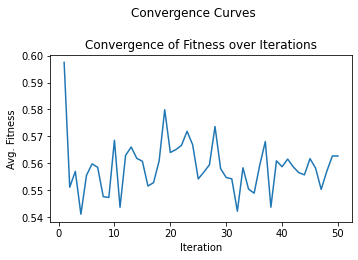

In [ ]:
from Py_FS.wrapper.nature_inspired.WOA import WOA as FS
solution = FS(num_agents=pop_size, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
len(featr_index_woa)

622

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[292  54]
 [ 12  20]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.84      0.90       346
         1.0       0.27      0.62      0.38        32

    accuracy                           0.83       378
   macro avg       0.62      0.73      0.64       378
weighted avg       0.90      0.83      0.85       378
 

The accuracy on test dataset: 82.53968%


In [ ]:
df_refined = df_train[df_train.columns[featr_index_woa]]

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[296  57]
 [  8  17]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.84      0.90       353
         1.0       0.23      0.68      0.34        25

    accuracy                           0.83       378
   macro avg       0.60      0.76      0.62       378
weighted avg       0.92      0.83      0.86       378
 

The accuracy on test dataset: 82.80423%


In [ ]:
df_refined

1         5         14        17        18        19        21    \
0    0.015020  0.519855  0.000709  0.052207  0.014055  0.016273  0.013341   
1    0.016198  0.106421 -0.020114 -0.236419  0.014181  0.016312  0.013271   
2    0.011301 -0.113913 -0.013806 -0.340301  0.014717  0.015611  0.014299   
3    0.015389  0.230540 -0.026568 -0.189982  0.011099  0.016531  0.012682   
4    0.016062  0.427305  0.009550 -0.007985  0.016258  0.015197  0.013488   
..        ...       ...       ...       ...       ...       ...       ...   
175  0.015892  0.452326  0.039526  0.769156  0.009788  0.015377  0.016988   
176  0.014972  0.062874 -0.006312 -0.475530  0.015330  0.015598  0.013882   
177  0.011799  0.309877  0.035072  0.506272  0.012465  0.015165  0.016286   
178  0.015195  0.032707  0.022285 -0.091595  0.015193  0.015548  0.012701   
179  0.012782 -0.713934  0.018954  0.250653  0.009116  0.016341  0.017344   

         22        24        33    ...      3036      3041      3042  \
0    0.011956  0.013349  0.013655  ...  1.475443  0.644997  0.267394   
1    0.011942  0.013058  0.013162  ...  0.472526  0.311733  0.679495   
2    0.011753  0.014013  0.013435  ...  0.228564  0.494855  0.517598   
3    0.011940  0.013275  0.013398  ...  0.981463  0.388514  0.519910   
4    0.011740  0.014030  0.013605  ...  0.888374  0.551384  0.871752   
..        ...       ...       ...  ...       ...       ...       ...   
175  0.011742  0.014219  0.013822  ...  0.287450  0.819702  0.185693   
176  0.011729  0.014424  0.013287  ...  0.509789  0.520098  0.565020   
177  0.011924  0.015252  0.013284  ...  0.374579  0.486518  0.519994   
178  0.011725  0.015319  0.013803  ...  0.265508  0.490317  0.100144   
179  0.011875  0.012896  0.013999  ...  0.272446  0.220391  0.845140   

         3048      3055      3056      3062      3066      3068      3071  
0    0.376323  0.552398  1.031956  1.194022  0.227529  0.506715  0.290479  
1    0.410489  0.712378  0.880729  0.504209  0.876720  0.280619  0.720643  
2    0.740392  0.450746  1.077343  0.507028  0.804067  0.136582  0.423645  
3    0.525685  0.557273  1.406693  0.544291  0.846772  0.236403  0.591824  
4    0.579273  0.742261  1.012218  0.790867  0.635609  0.375574  0.419575  
..        ...       ...       ...       ...       ...       ...       ...  
175  0.470206  0.639177  0.441462  0.695456  0.132543  0.759127  0.553973  
176  0.277641  0.763767  0.435065  0.671702  0.485806  0.289506  0.641078  
177  0.503397  0.541489  0.141817  0.767742  0.425208  1.564774  0.846390  
178  0.197813  0.432263  0.089449  0.713123  0.223400  0.671380  0.716691  
179  0.526833  0.921381  0.200229  0.927225  0.211081  0.587427  1.078828  

[898 rows x 644 columns]

In [ ]:
df_refined.index = df_refined.index.sort_values()

In [ ]:
df_refined

1         5         14        17        18        19        21    \
0    0.015020  0.519855  0.000709  0.052207  0.014055  0.016273  0.013341   
1    0.016198  0.106421 -0.020114 -0.236419  0.014181  0.016312  0.013271   
2    0.011301 -0.113913 -0.013806 -0.340301  0.014717  0.015611  0.014299   
3    0.015389  0.230540 -0.026568 -0.189982  0.011099  0.016531  0.012682   
4    0.016062  0.427305  0.009550 -0.007985  0.016258  0.015197  0.013488   
..        ...       ...       ...       ...       ...       ...       ...   
175  0.015892  0.452326  0.039526  0.769156  0.009788  0.015377  0.016988   
176  0.014972  0.062874 -0.006312 -0.475530  0.015330  0.015598  0.013882   
177  0.011799  0.309877  0.035072  0.506272  0.012465  0.015165  0.016286   
178  0.015195  0.032707  0.022285 -0.091595  0.015193  0.015548  0.012701   
179  0.012782 -0.713934  0.018954  0.250653  0.009116  0.016341  0.017344   

         22        24        33    ...      3036      3041      3042  \
0    0.011956  0.013349  0.013655  ...  1.475443  0.644997  0.267394   
1    0.011942  0.013058  0.013162  ...  0.472526  0.311733  0.679495   
2    0.011753  0.014013  0.013435  ...  0.228564  0.494855  0.517598   
3    0.011940  0.013275  0.013398  ...  0.981463  0.388514  0.519910   
4    0.011740  0.014030  0.013605  ...  0.888374  0.551384  0.871752   
..        ...       ...       ...  ...       ...       ...       ...   
175  0.011742  0.014219  0.013822  ...  0.287450  0.819702  0.185693   
176  0.011729  0.014424  0.013287  ...  0.509789  0.520098  0.565020   
177  0.011924  0.015252  0.013284  ...  0.374579  0.486518  0.519994   
178  0.011725  0.015319  0.013803  ...  0.265508  0.490317  0.100144   
179  0.011875  0.012896  0.013999  ...  0.272446  0.220391  0.845140   

         3048      3055      3056      3062      3066      3068      3071  
0    0.376323  0.552398  1.031956  1.194022  0.227529  0.506715  0.290479  
1    0.410489  0.712378  0.880729  0.504209  0.876720  0.280619  0.720643  
2    0.740392  0.450746  1.077343  0.507028  0.804067  0.136582  0.423645  
3    0.525685  0.557273  1.406693  0.544291  0.846772  0.236403  0.591824  
4    0.579273  0.742261  1.012218  0.790867  0.635609  0.375574  0.419575  
..        ...       ...       ...       ...       ...       ...       ...  
175  0.470206  0.639177  0.441462  0.695456  0.132543  0.759127  0.553973  
176  0.277641  0.763767  0.435065  0.671702  0.485806  0.289506  0.641078  
177  0.503397  0.541489  0.141817  0.767742  0.425208  1.564774  0.846390  
178  0.197813  0.432263  0.089449  0.713123  0.223400  0.671380  0.716691  
179  0.526833  0.921381  0.200229  0.927225  0.211081  0.587427  1.078828  

[898 rows x 644 columns]

In [ ]:
df_eff_tr=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_tr_ISB_Effnet.csv')
df_eff_val=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_val_ISB_Effnet.csv')
df_eff_test=pd.read_csv('/content/drive/MyDrive/ISBI-2016_pre-processed/featr_test_ISB_Effnet.csv')

In [ ]:
df_1 = pd.concat([df_eff_tr, df_eff_val], axis=0)
df_1 = df_1.fillna(0)
df_2 = pd.concat([df_refined, df_1], axis=1)
df_2 = df_2.fillna(0)
df_3 = pd.concat([df_3[df_3.columns[featr_index_woa]], df_eff_test], axis=1)
df_3 = df_3.fillna(0)
df_1 = sklearn.utils.shuffle(df_1)
df_2 = sklearn.utils.shuffle(df_2)
df_3 = sklearn.utils.shuffle(df_3)

In [ ]:
df_dense_test

0         1         2         3         4         5         6  \
0    0.000000  1.000000  2.000000  3.000000  4.000000  5.000000  6.000000   
1    0.015537  0.011106  0.015555  0.014737  0.071880  0.105779  0.014615   
2    0.015607  0.023021  0.013703  0.016577  0.133229  0.499462  0.014562   
3    0.015537  0.012819  0.015167  0.016480  0.066672  0.264719  0.014490   
4    0.015974  0.013468  0.014044  0.017411  0.069974  0.469677  0.014983   
..        ...       ...       ...       ...       ...       ...       ...   
753  0.015273  0.016741  0.017218  0.014374  0.202727 -0.051685  0.015623   
754  0.015687  0.011697  0.016985  0.014219  0.080446  0.162618  0.015560   
755  0.015444  0.011795  0.020306  0.014484  0.025177  1.645995  0.015185   
756  0.015744  0.017517  0.009755  0.013639  0.457127 -0.166836  0.015369   
757  0.015716  0.018869  0.016144  0.013670  0.188801  0.795703  0.015562   

            7         8         9  ...         1014         1015         1016  \
0    7.000000  8.000000  9.000000  ...  1014.000000  1015.000000  1016.000000   
1    0.012760  0.304377  0.009665  ...    -0.328109     0.471989     0.334018   
2    0.009509  0.738335  0.009443  ...    -0.649640     1.588693     0.572057   
3    0.013337  0.203402  0.009675  ...    -0.140392     0.123527     0.908379   
4    0.009508  0.722765  0.009650  ...    -0.887285     0.715109     0.032352   
..        ...       ...       ...  ...          ...          ...          ...   
753  0.012543  0.344211  0.009737  ...    -0.187598     0.917910     0.319950   
754  0.013453  0.547210  0.009839  ...    -0.378850     1.767461     0.204352   
755  0.011569  0.218649  0.009656  ...     0.335214    -2.021773     7.740279   
756  0.012343  0.701263  0.010481  ...    -0.710798     0.724323    -0.681710   
757  0.010139  0.257072  0.009837  ...    -0.258574    -0.014991     0.589297   

            1017         1018         1019         1020         1021  \
0    1017.000000  1018.000000  1019.000000  1020.000000  1021.000000   
1      -0.729980     0.153069    -0.066845     0.822968     2.364219   
2       0.703468     0.040860    -0.832457    -0.391034     1.862113   
3      -1.291428     1.039337     1.591242     0.204652     0.453357   
4       0.740986     0.256270    -0.071003     0.583845     2.751523   
..           ...          ...          ...          ...          ...   
753     0.443329     1.293074     1.302456     1.459288     1.203115   
754     0.521130     0.308469     1.042630     1.254067     1.805143   
755    -0.405765     1.287638     0.549167     3.184898    -2.208808   
756     0.943891     0.526271    -0.354724     0.805175     1.745440   
757    -0.026028     0.374875    -0.008976     1.780491    -0.108925   

            1022         1023  
0    1022.000000  1023.000000  
1       0.000737     0.088008  
2       2.508063     0.250963  
3      -0.054806     2.824053  
4       1.657272    -0.256202  
..           ...          ...  
753     0.796445     3.040179  
754     0.824408     0.608089  
755     1.420522     3.088095  
756     0.257547     0.133260  
757    -0.388412     3.466767  

[758 rows x 1024 columns]

In [ ]:
#Genetic Algorithm

df_train = pd.concat([df_eff_tr, df_eff_val], axis=0)
arr_train_val = np.asarray(df_train)
arr_test = np.asarray(df_eff_test)

pop_size = 50
pop_for_mating = 25
num_mutations = 50
num_gen = 50

num_initial_featr = arr_train_val.shape[1]-1
num_samples = arr_train_val.shape[0]
classifier = 'KNN'
print(num_initial_featr)

1792


Weight for the classification accuracy [0-1]: 0.2
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 50

------------- Best Agent ---------------
Fitness: 0.817232142857143
Number of Features: 387
----------------------------------------

Whale 1 - Fitness: 0.817232142857143, Number of Features: 387
Whale 2 - Fitness: 0.7420138888888889, Number of Features: 553
Whale 3 - Fitness: 0.7268353174603175, Number of Features: 587
Whale 4 - Fitness: 0.7216964285714287, Number of Features: 601
Whale 5 - Fitness: 0.6857638888888888, Number of Features: 679
Whale 6 - Fitness: 0.6629960317460317, Number of Features: 730
Whale 7 - Fitness: 0.6545138888888888, Number of Features: 749
Whale 8 - Fitness: 0.6446924603174604, Number of Features: 771
Whale 9 - Fitness: 0.6433531746031746, Number of Features: 774
Whale 10 - Fitness: 0.6308531746031746, Number of Features: 802
Whale 11 - Fitness: 0.6299603174603174, Number of Feature

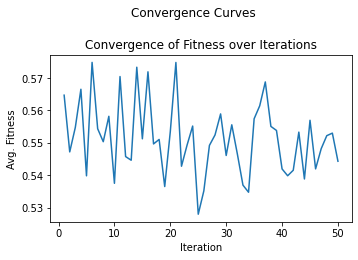

In [ ]:
from Py_FS.wrapper.nature_inspired.WOA import WOA as FS
solution = FS(num_agents=pop_size, max_iter=num_gen, train_data=arr_train_val[:,:-1], train_label=arr_train_val[:,-1], save_conv_graph=True)

In [ ]:
featr_binary = solution.best_agent

In [ ]:
featr_index_woa = np.where(featr_binary==1)[0]
len(featr_index_woa)

387

In [ ]:
arr_tr_new = arr_train_val[:,featr_index_woa]
#arr_val_new = arr_val[:,featr_index]
#arr_tr_new.shape
arr_test_new = arr_test[:,featr_index_woa]

In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(max_depth=7, random_state=0)
from sklearn.svm import SVC
model = SVC(kernel='rbf')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
model.fit(arr_tr_new, arr_train_val[:,-1])
test_pred = model.predict(arr_test_new)
print("Confusion Matrix:\n {} \n Classification Report:\n {} \n".format(confusion_matrix(test_pred, arr_test[:,-1]),classification_report(test_pred, arr_test[:,-1])))
acc = accuracy_score(test_pred, arr_test[:,-1])
print("The accuracy on test dataset: {:.5f}%".format(acc*100))

Confusion Matrix:
 [[290  48]
 [ 14  26]] 
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       338
         1.0       0.35      0.65      0.46        40

    accuracy                           0.84       378
   macro avg       0.65      0.75      0.68       378
weighted avg       0.89      0.84      0.86       378
 

The accuracy on test dataset: 83.59788%
